<a href="https://colab.research.google.com/github/anhpdd/ml-property-valuation-klang-valley/blob/main/notebooks/4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import re

# Clustering
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors

# Clustering Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Settings
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

# Colors
COLORS = {
    'blue': '#174A7E',
    'orange': '#FAA43A',
    'red': '#F15854',
    'grey': '#808080',
    'green': '#2ECC71'
}

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import the dataset
df_raw = pd.read_excel('/content/drive/MyDrive/Colab/Capstone 1/optimized_distances_df.xlsx')
print(df_raw.shape)
df_raw.head()

(68677, 41)


Unnamed: 0  index  records_id                   property_type     district  \
0           0      0           1  1 - 1 1/2 storey semi-detached       gombak   
1           1      1           2  1 - 1 1/2 storey semi-detached       gombak   
2           2      2           3  1 - 1 1/2 storey semi-detached       gombak   
3           3      3           4  1 - 1 1/2 storey semi-detached       gombak   
4           4      4           5  1 - 1 1/2 storey semi-detached  hulu langat   

             mukim             scheme_name           road_name       date  \
0  bandar selayang  taman selayang mutiara  jalan mutiara 3/8a 2023-10-01   
1  bandar selayang  taman selayang mutiara  jalan mutiara 4/4a 2023-12-01   
2  bandar selayang  taman selayang mutiara   jalan mutiara 5/2 2023-12-01   
3  bandar selayang  taman selayang mutiara            jalan 43 2023-09-01   
4  bandar selayang  taman selayang mutiara   jalan mutiara 3/3 2023-09-01   

   land_m2  ...  walk_dist_to_park  walk_dist_to_river  walk_dist_to_lake  \
0   201.00  ...               0.98                1.52               5.16   
1   205.00  ...               1.13                1.47               4.89   
2   205.00  ...               1.49                1.08               4.49   
3   224.00  ...               0.93                0.32               4.01   
4   303.00  ...               1.72                1.08               1.75   

   walk_dist_to_rail_station  dist_to_mall dist_to_school  dist_to_park  \
0                       9.74          1.51           1.15          0.98   
1                       9.93          1.57           1.30          1.13   
2                      10.29          1.17           1.17          1.49   
3                      10.01          0.69           0.39          0.93   
4                      14.37          4.94           4.05          2.31   

   dist_to_river  dist_to_lake  dist_to_rail_station  
0           1.52          5.22                  8.82  
1           1.49          5.03                  9.02  
2           1.10          4.64                  9.37  
3           0.32          4.15                  9.41  
4           1.08          2.31                 14.36  

[5 rows x 41 columns]

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68677 entries, 0 to 68676
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     68677 non-null  int64         
 1   index                          68677 non-null  int64         
 2   records_id                     68677 non-null  int64         
 3   property_type                  68677 non-null  object        
 4   district                       68677 non-null  object        
 5   mukim                          68677 non-null  object        
 6   scheme_name                    68677 non-null  object        
 7   road_name                      68677 non-null  object        
 8   date                           68677 non-null  datetime64[ns]
 9   land_m2                        68677 non-null  float64       
 10  property_m2                    68677 non-null  float64       
 11  transaction_pri

# Data Cleaning

In [ ]:
# Consolidated column dropping
columns_to_drop = ['Unnamed: 0','index', 'total_amenity_count']
df_clean = df_raw.drop(columns=columns_to_drop)

print(f"DataFrame shape after initial drops: {df_raw.shape}")
print("-" * 50)
print("DataFrame head after initial cleaning and renaming:")
print(df_clean.head())
print("-" * 50)

DataFrame shape after initial drops: (68677, 41)
DataFrame head after initial cleaning and renaming:
   records_id                   property_type     district            mukim  \
0           1  1 - 1 1/2 storey semi-detached       gombak  bandar selayang   
1           2  1 - 1 1/2 storey semi-detached       gombak  bandar selayang   
2           3  1 - 1 1/2 storey semi-detached       gombak  bandar selayang   
3           4  1 - 1 1/2 storey semi-detached       gombak  bandar selayang   
4           5  1 - 1 1/2 storey semi-detached  hulu langat  bandar selayang   

              scheme_name           road_name       date  land_m2  \
0  taman selayang mutiara  jalan mutiara 3/8a 2023-10-01   201.00   
1  taman selayang mutiara  jalan mutiara 4/4a 2023-12-01   205.00   
2  taman selayang mutiara   jalan mutiara 5/2 2023-12-01   205.00   
3  taman selayang mutiara            jalan 43 2023-09-01   224.00   
4  taman selayang mutiara   jalan mutiara 3/3 2023-09-01   303.00   

   proper

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68677 entries, 0 to 68676
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   records_id                     68677 non-null  int64         
 1   property_type                  68677 non-null  object        
 2   district                       68677 non-null  object        
 3   mukim                          68677 non-null  object        
 4   scheme_name                    68677 non-null  object        
 5   road_name                      68677 non-null  object        
 6   date                           68677 non-null  datetime64[ns]
 7   land_m2                        68677 non-null  float64       
 8   property_m2                    68677 non-null  float64       
 9   transaction_price              68677 non-null  int64         
 10  year                           68677 non-null  int64         
 11  unit_level     

# Extract Coordinates from LineString

In [ ]:
def extract_coordinates_from_linestring(geometry_series):
    """Extract x, y coordinates from LINESTRING WKT strings"""
    x_coords, y_coords = [], []

    for geom_str in geometry_series:
        try:
            if pd.isna(geom_str):
                x_coords.append(np.nan)
                y_coords.append(np.nan)
                continue

            match = re.search(r'LINESTRING\s*\((.*)\)', str(geom_str).strip())
            if not match:
                x_coords.append(np.nan)
                y_coords.append(np.nan)
                continue

            coords_content = match.group(1)
            first_pair = coords_content.split(', ')[0].strip().split()

            if len(first_pair) >= 2:
                x_coords.append(float(first_pair[0]))
                y_coords.append(float(first_pair[1]))
            else:
                x_coords.append(np.nan)
                y_coords.append(np.nan)
        except:
            x_coords.append(np.nan)
            y_coords.append(np.nan)

    return x_coords, y_coords

# First, let's check what columns we actually have
print("\nCurrent columns in df_clean:")
print(df_clean.columns.tolist())
print(f"\nDataFrame shape: {df_clean.shape}")


# Re-run coordinate extraction
df_clean['x_coord'], df_clean['y_coord'] = extract_coordinates_from_linestring(df_clean['geometry'])

print(f"✓ Coordinates extracted: {len(df_clean):,} valid properties")
print(f"  X range: {df_clean['x_coord'].min():.6f} to {df_clean['x_coord'].max():.6f}")
print(f"  Y range: {df_clean['y_coord'].min():.6f} to {df_clean['y_coord'].max():.6f}")


Current columns in df_clean:
['records_id', 'property_type', 'district', 'mukim', 'scheme_name', 'road_name', 'date', 'land_m2', 'property_m2', 'transaction_price', 'year', 'unit_level', 'way_id', 'geometry', 'freehold', 'price_m2', 'mall_count', 'school_count', 'park_count', 'river_count', 'lake_count', 'rail_station_count', 'train_ids', 'incoming_ridership_within_1km', 'outgoing_ridership_within_1km', 'total_ridership_within_1km', 'walk_dist_to_mall', 'walk_dist_to_school', 'walk_dist_to_park', 'walk_dist_to_river', 'walk_dist_to_lake', 'walk_dist_to_rail_station', 'dist_to_mall', 'dist_to_school', 'dist_to_park', 'dist_to_river', 'dist_to_lake', 'dist_to_rail_station']

DataFrame shape: (68677, 38)
✓ Coordinates extracted: 68,677 valid properties
  X range: 100.840810 to 101.898674
  Y range: 2.598541 to 3.809657


#EDA

## Transit Segmentation

In [ ]:
mask = ((df_clean['rail_station_count'] > 0) & (df_clean['walk_dist_to_rail_station'] < 2)) | (df_clean['walk_dist_to_rail_station'] < 2) | (df_clean['walk_dist_to_rail_station'] < 5)
df_clean['transit'] = np.where(mask, 1, 0)

transit_seg = df_clean[df_clean['transit'] == 1]
non_transit_seg = df_clean[df_clean['transit'] == 0]

## Summary stats by district

### Transit

In [ ]:
# Summary statistics by district for transit
print(transit_seg.shape)
for district in transit_seg['district'].unique():
    print(f"\n{district.upper()}")
    print("-"*70)
    display(transit_seg[transit_seg['district'] == district].describe())

(38260, 41)

GOMBAK
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      939.00                            939   939.00       939.00   
mean    33,628.20  2023-11-29 03:27:01.725239808   187.58       124.87   
min          9.00            2023-01-01 00:00:00     5.20         5.20   
25%     19,756.50            2023-07-01 00:00:00    83.12        71.53   
50%     35,346.00            2023-11-01 00:00:00   130.06        93.00   
75%     44,425.00            2024-05-01 00:00:00   195.55       143.55   
max     68,363.00            2025-03-01 00:00:00 1,807.37     1,021.00   
std     19,934.48                            NaN   195.00        91.47   

       transaction_price     year  unit_level           way_id  freehold  \
count             939.00   939.00      939.00           939.00    939.00   
mean          781,004.26 2,023.48        2.08   298,281,476.13      0.39   
min            50,000.00 2,023.00        0.00    25,230,548.00      0.00   
25%           310,000.00 2,023.00        0.00    94,124,304.50      0.00   
50%           475,000.00 2,023.00        0.00   160,462,678.00      0.00   
75%           750,000.00 2,024.00        2.00   261,696,674.00      1.00   
max         6,050,000.00 2,025.00       36.00 1,426,567,174.00      1.00   
std           911,584.10     0.56        5.13   327,515,522.04      0.49   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count    939.00  ...                     939.00        926.00          932.00   
mean   6,337.00  ...                       3.29          0.95            0.94   
min      717.67  ...                       0.31          0.00            0.00   
25%    3,728.87  ...                       2.05          0.37            0.46   
50%    4,958.68  ...                       3.74          0.67            0.79   
75%    6,730.98  ...                       4.32          1.07            1.25   
max   44,666.67  ...                       5.00          5.31            3.42   
std    5,774.88  ...                       1.27          0.95            0.74   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count        932.00         926.00        926.00                926.00   
mean           1.50           1.82          2.90                 10.76   
min            0.00           0.00          0.00                  0.00   
25%            0.19           0.83          1.99                  3.64   
50%            0.81           1.41          2.59                  4.42   
75%            1.79           2.62          4.24                  5.64   
max           10.09           7.04         12.13                 45.79   
std            2.17           1.41          1.68                 14.39   

       x_coord  y_coord  transit  
count   939.00   939.00   939.00  
mean    101.70     3.21     1.00  
min     101.55     3.15     1.00  
25%     101.70     3.17     1.00  
50%     101.71     3.23     1.00  
75%     101.74     3.23     1.00  
max     101.78     3.25     1.00  
std       0.06     0.03     0.00  

[8 rows x 34 columns]


HULU LANGAT
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    6,773.00                           6773 6,773.00     6,773.00   
mean    36,270.51  2023-11-21 05:23:48.200206848   137.79       110.59   
min         31.00            2023-01-01 00:00:00     3.72         3.72   
25%     21,916.00            2023-06-01 00:00:00    78.00        72.00   
50%     37,449.00            2023-11-01 00:00:00   104.00        93.00   
75%     54,407.00            2024-05-01 00:00:00   145.00       129.00   
max     68,663.00            2025-03-01 00:00:00 6,520.00     4,570.81   
std     19,481.90                            NaN   151.12        90.15   

       transaction_price     year  unit_level           way_id  freehold  \
count           6,773.00 6,773.00    6,773.00         6,773.00  6,773.00   
mean          534,493.13 2,023.47        3.65   393,505,065.04      0.60   
min            20,000.00 2,023.00        0.00    14,371,164.00      0.00   
25%           280,000.00 2,023.00        0.00   135,660,705.00      0.00   
50%           413,000.00 2,023.00        1.00   201,239,343.00      1.00   
75%           620,000.00 2,024.00        5.00   606,864,780.00      1.00   
max        17,000,000.00 2,025.00       38.00 1,425,006,812.00      1.00   
std           547,547.38     0.56        6.00   380,924,810.08      0.49   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  6,773.00  ...                   6,773.00      6,693.00        6,679.00   
mean   5,216.39  ...                       2.74          0.92            1.17   
min      400.00  ...                       0.26          0.00            0.00   
25%    3,220.34  ...                       1.87          0.48            0.57   
50%    4,301.08  ...                       2.86          0.77            1.00   
75%    5,674.42  ...                       3.60          1.34            1.68   
max   58,823.53  ...                       4.99          5.38            5.69   
std    5,255.54  ...                       1.18          0.64            0.78   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      6,690.00       6,679.00      6,679.00              6,679.00   
mean           0.97           2.29          5.04                  3.15   
min            0.00           0.00          0.22                  0.09   
25%            0.44           1.32          2.90                  2.33   
50%            0.82           2.20          5.00                  3.18   
75%            1.33           3.12          6.42                  3.89   
max            5.12           6.51         11.38                  7.84   
std            0.72           1.24          2.52                  1.17   

       x_coord  y_coord  transit  
count 6,773.00 6,773.00 6,773.00  
mean    101.77     3.06     1.00  
min     101.74     2.95     1.00  
25%     101.76     3.01     1.00  
50%     101.77     3.05     1.00  
75%     101.79     3.12     1.00  
max     101.82     3.16     1.00  
std       0.02     0.06     0.00  

[8 rows x 34 columns]


KLANG
----------------------------------------------------------------------


records_id                           date   land_m2  property_m2  \
count    4,170.00                           4170  4,170.00     4,170.00   
mean    28,639.90  2023-11-11 01:55:41.007194112    158.25       115.02   
min         87.00            2023-01-01 00:00:00     10.30        10.30   
25%     11,343.25            2023-06-01 00:00:00     87.00        74.00   
50%     27,898.50            2023-11-01 00:00:00    130.20       102.19   
75%     46,736.75            2024-05-01 00:00:00    172.46       139.00   
max     68,635.00            2025-03-01 00:00:00 17,920.00       689.00   
std     18,860.85                            NaN    293.91        57.11   

       transaction_price     year  unit_level           way_id  freehold  \
count           4,170.00 4,170.00    4,170.00         4,170.00  4,170.00   
mean          552,485.37 2,023.44        1.13   446,887,974.71      0.91   
min            22,000.00 2,023.00        0.00    23,322,216.00      0.00   
25%           312,000.00 2,023.00        0.00   246,966,849.00      1.00   
50%           460,000.00 2,023.00        0.00   393,233,778.00      1.00   
75%           680,000.00 2,024.00        1.00   608,564,873.00      1.00   
max         6,150,000.00 2,025.00       26.00 1,416,237,850.00      1.00   
std           426,116.00     0.55        2.70   332,341,614.94      0.28   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  4,170.00  ...                   4,170.00      4,159.00        4,159.00   
mean   4,664.96  ...                       2.72          1.08            1.43   
min      297.50  ...                       0.02          0.00            0.00   
25%    3,506.59  ...                       1.71          0.45            0.72   
50%    4,530.68  ...                       2.75          0.82            1.24   
75%    5,495.58  ...                       3.69          1.38            1.99   
max   95,890.41  ...                       4.99          9.50            8.85   
std    3,290.78  ...                       1.19          0.95            0.95   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      4,163.00       4,159.00      4,159.00              4,159.00   
mean           1.08           2.66          4.36                  3.11   
min            0.00           0.00          0.00                  0.14   
25%            0.47           1.47          2.80                  2.12   
50%            0.92           2.40          4.48                  3.03   
75%            1.51           3.38          5.66                  4.06   
max           15.53          12.48         19.07                 19.06   
std            0.84           1.63          2.08                  1.40   

       x_coord  y_coord  transit  
count 4,170.00 4,170.00 4,170.00  
mean    101.45     3.02     1.00  
min     101.40     2.95     1.00  
25%     101.43     2.99     1.00  
50%     101.45     3.01     1.00  
75%     101.46     3.04     1.00  
max     101.56     3.09     1.00  
std       0.02     0.03     0.00  

[8 rows x 34 columns]


KUALA LUMPUR
----------------------------------------------------------------------


records_id                           date   land_m2  property_m2  \
count   12,288.00                          12288 12,288.00    12,288.00   
mean    43,259.15  2023-11-29 08:41:43.125000192     77.74        54.44   
min        337.00            2023-01-01 00:00:00      1.20         1.20   
25%     25,906.75            2023-06-01 00:00:00      8.50         8.50   
50%     48,851.50            2023-11-01 00:00:00     11.60        11.60   
75%     59,910.25            2024-06-01 00:00:00     97.00        78.00   
max     68,671.00            2025-03-01 00:00:00  5,684.09     2,292.00   
std     19,046.16                            NaN    164.09        91.83   

       transaction_price      year  unit_level           way_id  freehold  \
count          12,288.00 12,288.00   12,288.00        12,288.00 12,288.00   
mean          950,045.65  2,023.49        8.33   431,161,910.27      0.57   
min            23,000.00  2,023.00       -1.00     4,579,533.00      0.00   
25%           350,000.00  2,023.00        0.00   129,508,022.00      0.00   
50%           550,000.00  2,023.00        5.00   254,742,752.00      1.00   
75%         1,002,750.00  2,024.00       13.00   757,659,456.00      1.00   
max        38,000,000.00  2,025.00       57.00 1,428,241,870.00      1.00   
std         1,375,181.87      0.56        9.71   377,930,192.44      0.50   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count  12,288.00  ...                  12,288.00     12,207.00   
mean   42,160.98  ...                       1.95          0.76   
min       781.25  ...                       0.00          0.00   
25%    11,998.36  ...                       0.94          0.35   
50%    38,812.81  ...                       1.66          0.61   
75%    55,056.18  ...                       2.78          0.89   
max   424,318.18  ...                       4.99          7.32   
std    34,897.21  ...                       1.24          0.71   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count       12,229.00     12,223.00      12,207.00     12,207.00   
mean             0.85          1.23           2.22          3.00   
min              0.00          0.00           0.00          0.00   
25%              0.36          0.55           1.46          1.68   
50%              0.68          0.98           2.23          2.63   
75%              1.18          1.62           2.87          3.93   
max              7.57         16.23           9.98         11.01   
std              0.74          1.10           1.07          1.86   

       dist_to_rail_station   x_coord   y_coord   transit  
count             12,207.00 12,288.00 12,288.00 12,288.00  
mean                   2.46    101.69      3.14      1.00  
min                    0.00    101.62      3.05      1.00  
25%                    1.31    101.66      3.09      1.00  
50%                    2.17    101.69      3.15      1.00  
75%                    3.51    101.72      3.19      1.00  
max                   16.37    101.76      3.24      1.00  
std                    1.50      0.03      0.05      0.00  

[8 rows x 34 columns]


SEPANG
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      536.00                            536   536.00       536.00   
mean    36,587.12  2023-10-11 21:42:59.104477696   196.32       158.55   
min        431.00            2023-01-01 00:00:00    43.00        43.00   
25%     19,058.00            2023-05-01 00:00:00   110.75       103.00   
50%     36,524.00            2023-09-01 00:00:00   161.00       139.50   
75%     52,986.25            2024-03-01 00:00:00   247.96       178.00   
max     68,678.00            2025-01-01 00:00:00 1,372.00       953.00   
std     18,990.13                            NaN   133.42        86.15   

       transaction_price     year  unit_level           way_id  freehold  \
count             536.00   536.00      536.00           536.00    536.00   
mean          845,701.49 2,023.37        2.25   552,658,738.68      0.62   
min           100,000.00 2,023.00        0.00   124,764,439.00      0.00   
25%           396,000.00 2,023.00        0.00   234,791,343.75      0.00   
50%           734,000.00 2,023.00        0.00   401,325,429.00      1.00   
75%         1,238,000.00 2,024.00        3.00   793,248,778.00      1.00   
max         4,800,000.00 2,025.00       28.00 1,386,603,536.00      1.00   
std           597,225.67     0.51        4.39   372,416,597.92      0.49   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count    536.00  ...                     536.00        525.00          525.00   
mean   5,064.93  ...                       3.11          2.11            2.09   
min    1,538.46  ...                       0.00          0.00            0.08   
25%    3,471.22  ...                       2.08          0.37            1.07   
50%    4,904.21  ...                       3.24          1.93            1.75   
75%    6,201.55  ...                       4.43          4.00            2.57   
max   14,923.61  ...                       4.99          6.54            6.76   
std    2,110.38  ...                       1.27          1.83            1.39   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count        529.00         525.00        525.00                525.00   
mean           1.11           2.78          3.72                  5.09   
min            0.00           0.01          0.37                  0.00   
25%            0.13           1.38          1.50                  2.75   
50%            0.82           1.93          3.46                  4.45   
75%            1.81           5.25          4.90                  8.39   
max            4.92           8.54         10.39                 10.01   
std            1.17           2.31          2.60                  3.09   

       x_coord  y_coord  transit  
count   536.00   536.00   536.00  
mean    101.64     2.96     1.00  
min     101.58     2.91     1.00  
25%     101.62     2.95     1.00  
50%     101.64     2.97     1.00  
75%     101.66     2.98     1.00  
max     101.68     2.98     1.00  
std       0.03     0.02     0.00  

[8 rows x 34 columns]


PETALING
----------------------------------------------------------------------


records_id                           date   land_m2  property_m2  \
count   13,415.00                          13415 13,415.00    13,415.00   
mean    36,732.27  2023-11-20 00:50:52.821468672    154.00       118.47   
min        362.00            2023-01-01 00:00:00      6.00         6.00   
25%     21,508.50            2023-06-01 00:00:00     78.96        75.00   
50%     33,748.00            2023-11-01 00:00:00    115.00       100.00   
75%     51,828.50            2024-05-01 00:00:00    165.00       143.00   
max     68,677.00            2025-03-01 00:00:00  2,801.00     1,137.00   
std     17,918.04                            NaN    142.22        70.92   

       transaction_price      year  unit_level           way_id  freehold  \
count          13,415.00 13,415.00   13,415.00        13,415.00 13,415.00   
mean          741,381.51  2,023.47        3.75   388,851,286.90      0.51   
min            25,000.00  2,023.00       -1.00     5,012,439.00      0.00   
25%           310,000.00  2,023.00        0.00   107,916,700.00      0.00   
50%           520,000.00  2,023.00        1.00   202,512,736.00      1.00   
75%           900,000.00  2,024.00        5.00   609,104,965.00      1.00   
max        10,239,000.00  2,025.00       42.00 1,424,733,880.00      1.00   
std           730,036.90      0.56        5.80   382,867,629.16      0.50   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count  13,415.00  ...                  13,415.00     12,874.00   
mean    5,896.61  ...                       1.91          0.87   
min       446.43  ...                       0.00          0.00   
25%     3,783.78  ...                       0.94          0.43   
50%     5,137.61  ...                       1.76          0.77   
75%     6,844.67  ...                       2.59          1.20   
max   108,695.65  ...                       4.99          7.32   
std     4,670.70  ...                       1.16          0.64   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count       12,862.00     12,881.00      12,862.00     12,862.00   
mean             1.15          0.86           2.78          3.84   
min              0.00          0.00           0.00          0.00   
25%              0.48          0.33           1.72          2.25   
50%              0.91          0.69           2.68          3.43   
75%              1.57          1.25           3.75          4.81   
max              7.57         16.23           8.82         12.97   
std              0.96          0.77           1.37          2.38   

       dist_to_rail_station   x_coord   y_coord   transit  
count             12,862.00 13,415.00 13,415.00 13,415.00  
mean                   2.37    101.61      3.08      1.00  
min                    0.00    101.47      2.98      1.00  
25%                    1.36    101.59      3.04      1.00  
50%                    2.27    101.61      3.07      1.00  
75%                    3.10    101.63      3.12      1.00  
max                   16.37    101.73      3.23      1.00  
std                    1.40      0.04      0.06      0.00  

[8 rows x 34 columns]


PUTRAJAYA
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      138.00                            138   138.00       138.00   
mean    37,526.01  2023-11-27 23:49:33.913043456   112.31        93.06   
min      6,338.00            2023-01-01 00:00:00     6.50         6.50   
25%     25,851.25            2023-06-01 00:00:00     6.50         6.50   
50%     26,022.50            2023-11-01 00:00:00    12.25        12.25   
75%     58,253.75            2024-05-01 00:00:00   189.25       153.00   
max     67,661.00            2025-02-01 00:00:00   647.27       472.00   
std     18,957.11                            NaN   147.97       118.92   

       transaction_price     year  unit_level           way_id  freehold  \
count             138.00   138.00      138.00           138.00    138.00   
mean          878,978.26 2,023.53        4.78   387,794,698.43      1.00   
min           235,000.00 2,023.00        0.00    29,325,681.00      1.00   
25%           305,000.00 2,023.00        0.00   139,732,606.75      1.00   
50%           675,000.00 2,023.00        3.00   401,328,520.00      1.00   
75%           903,000.00 2,024.00        8.00   532,739,288.25      1.00   
max         3,844,000.00 2,025.00       21.00 1,174,214,867.00      1.00   
std           819,456.60     0.62        5.72   276,303,913.12      0.00   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count    138.00  ...                     138.00        138.00          138.00   
mean  33,212.57  ...                       2.10          1.08            0.61   
min    4,305.56  ...                       0.55          0.14            0.05   
25%    6,257.55  ...                       0.55          0.53            0.23   
50%   40,384.62  ...                       1.92          1.24            0.51   
75%   53,461.54  ...                       2.71          1.24            0.76   
max   71,875.00  ...                       4.95          3.22            2.57   
std   24,201.96  ...                       1.52          0.73            0.53   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count        138.00           0.00        138.00                138.00   
mean           0.99            NaN          1.95                  2.22   
min            0.03            NaN          0.21                  0.82   
25%            0.87            NaN          0.87                  0.97   
50%            0.87            NaN          2.40                  1.89   
75%            1.31            NaN          2.79                  2.41   
max            2.16            NaN          3.95                  5.29   
std            0.47            NaN          1.08                  1.40   

       x_coord  y_coord  transit  
count   138.00   138.00   138.00  
mean    101.68     2.94     1.00  
min     101.67     2.91     1.00  
25%     101.67     2.93     1.00  
50%     101.68     2.93     1.00  
75%     101.68     2.94     1.00  
max     101.70     2.96     1.00  
std       0.01     0.01     0.00  

[8 rows x 34 columns]


SABAK BERNAM
----------------------------------------------------------------------


records_id                 date  land_m2  property_m2  \
count        1.00                    1     1.00         1.00   
mean    42,496.00  2024-01-01 00:00:00   158.00        93.00   
min     42,496.00  2024-01-01 00:00:00   158.00        93.00   
25%     42,496.00  2024-01-01 00:00:00   158.00        93.00   
50%     42,496.00  2024-01-01 00:00:00   158.00        93.00   
75%     42,496.00  2024-01-01 00:00:00   158.00        93.00   
max     42,496.00  2024-01-01 00:00:00   158.00        93.00   
std           NaN                  NaN      NaN          NaN   

       transaction_price     year  unit_level        way_id  freehold  \
count               1.00     1.00        1.00          1.00      1.00   
mean          200,000.00 2,024.00        0.00 39,901,304.00      1.00   
min           200,000.00 2,024.00        0.00 39,901,304.00      1.00   
25%           200,000.00 2,024.00        0.00 39,901,304.00      1.00   
50%           200,000.00 2,024.00        0.00 39,901,304.00      1.00   
75%           200,000.00 2,024.00        0.00 39,901,304.00      1.00   
max           200,000.00 2,024.00        0.00 39,901,304.00      1.00   
std                  NaN      NaN         NaN           NaN       NaN   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count      1.00  ...                       1.00          1.00            1.00   
mean   2,150.54  ...                       1.31          1.94            0.65   
min    2,150.54  ...                       1.31          1.94            0.65   
25%    2,150.54  ...                       1.31          1.94            0.65   
50%    2,150.54  ...                       1.31          1.94            0.65   
75%    2,150.54  ...                       1.31          1.94            0.65   
max    2,150.54  ...                       1.31          1.94            0.65   
std         NaN  ...                        NaN           NaN             NaN   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count          1.00           1.00          1.00                  1.00   
mean           0.83           1.91          2.47                  2.32   
min            0.83           1.91          2.47                  2.32   
25%            0.83           1.91          2.47                  2.32   
50%            0.83           1.91          2.47                  2.32   
75%            0.83           1.91          2.47                  2.32   
max            0.83           1.91          2.47                  2.32   
std             NaN            NaN           NaN                   NaN   

       x_coord  y_coord  transit  
count     1.00     1.00     1.00  
mean    101.69     3.15     1.00  
min     101.69     3.15     1.00  
25%     101.69     3.15     1.00  
50%     101.69     3.15     1.00  
75%     101.69     3.15     1.00  
max     101.69     3.15     1.00  
std        NaN      NaN      NaN  

[8 rows x 34 columns]

### Non-Transit

In [ ]:
print(non_transit_seg.shape)
# Summary statistics by district for transit
for district in non_transit_seg['district'].unique():
    print(f"\n{district.upper()}")
    print("-"*70)
    display(non_transit_seg[non_transit_seg['district'] == district].describe())

(30417, 41)

GOMBAK
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    4,934.00                           4934 4,934.00     4,934.00   
mean    29,566.04  2023-11-11 12:01:10.044588544   150.01       113.75   
min          1.00            2023-01-01 00:00:00     5.10         5.10   
25%      7,506.25            2023-06-01 00:00:00    79.00        75.00   
50%     30,545.50            2023-11-01 00:00:00   120.77       100.00   
75%     44,116.75            2024-05-01 00:00:00   167.00       130.10   
max     68,654.00            2025-03-01 00:00:00 2,410.41       725.00   
std     18,838.60                            NaN   121.14        62.78   

       transaction_price     year  unit_level           way_id  freehold  \
count           4,934.00 4,934.00    4,934.00         4,934.00  4,934.00   
mean          526,831.78 2,023.46        1.92   481,129,763.16      0.48   
min            25,000.00 2,023.00        0.00    24,352,344.00      0.00   
25%           255,000.00 2,023.00        0.00   192,055,572.25      0.00   
50%           410,000.00 2,023.00        0.00   307,664,073.00      0.00   
75%           630,000.00 2,024.00        2.00   660,465,567.75      1.00   
max         9,999,000.00 2,025.00       30.00 1,430,900,415.00      1.00   
std           496,840.91     0.55        3.82   370,895,524.11      0.50   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count   4,934.00  ...                   4,934.00      4,876.00   
mean    4,700.54  ...                      13.43          1.20   
min       454.55  ...                       5.00          0.00   
25%     3,026.60  ...                       9.12          0.25   
50%     3,940.28  ...                      12.21          0.79   
75%     5,277.78  ...                      18.87          1.67   
max   133,320.00  ...                      24.88          6.35   
std     4,842.05  ...                       5.44          1.25   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count        4,891.00      4,894.00       4,864.00      4,721.00   
mean             1.44          1.68           1.78          3.63   
min              0.00          0.00           0.00          0.00   
25%              0.42          0.39           0.54          1.85   
50%              1.08          1.19           1.74          2.86   
75%              2.23          2.57           2.74          4.45   
max              6.33          7.66           4.99         12.97   
std              1.25          1.65           1.31          2.94   

       dist_to_rail_station  x_coord  y_coord  transit  
count              4,721.00 4,934.00 4,934.00 4,934.00  
mean                  21.62   101.61     3.26     0.00  
min                    0.62   101.43     3.16     0.00  
25%                    6.30   101.53     3.22     0.00  
50%                   24.54   101.61     3.27     0.00  
75%                   35.20   101.67     3.30     0.00  
max                   45.42   101.79     3.35     0.00  
std                   14.51     0.09     0.04     0.00  

[8 rows x 34 columns]


HULU LANGAT
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    4,251.00                           4251 4,251.00     4,251.00   
mean    31,898.25  2023-11-19 02:11:46.280875008   175.48       134.08   
min          5.00            2023-01-01 00:00:00     4.90         4.90   
25%      9,360.50            2023-06-01 00:00:00    92.00        79.00   
50%     32,228.00            2023-11-01 00:00:00   130.06       120.00   
75%     45,979.50            2024-05-01 00:00:00   193.20       151.00   
max     68,664.00            2025-03-01 00:00:00 2,013.00     1,616.00   
std     19,591.03                            NaN   157.77        95.07   

       transaction_price     year  unit_level           way_id  freehold  \
count           4,251.00 4,251.00    4,251.00         4,251.00  4,251.00   
mean          642,667.14 2,023.48        2.25   511,977,694.70      0.77   
min            33,000.00 2,023.00       -1.00     5,202,735.00      0.00   
25%           320,000.00 2,023.00        0.00   197,997,570.00      1.00   
50%           500,000.00 2,023.00        0.00   497,810,689.00      1.00   
75%           756,000.00 2,024.00        2.00   749,179,149.00      1.00   
max         7,600,000.00 2,025.00       32.00 1,418,847,517.00      1.00   
std           587,027.67     0.56        4.76   352,538,088.29      0.42   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  4,251.00  ...                   4,251.00      4,214.00        4,214.00   
mean   5,055.16  ...                       9.74          1.92            2.05   
min      330.71  ...                       5.00          0.00            0.00   
25%    3,500.00  ...                       6.03          0.92            0.91   
50%    4,391.61  ...                       8.96          1.67            1.61   
75%    5,400.00  ...                      13.25          2.88            2.78   
max   76,829.27  ...                      32.60         12.67            6.38   
std    4,908.48  ...                       3.96          1.31            1.50   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      4,214.00       4,214.00      4,214.00              4,214.00   
mean           1.43           3.05          4.51                  9.96   
min            0.00           0.00          0.00                  2.38   
25%            0.54           1.53          2.73                  6.59   
50%            1.20           2.50          4.40                  9.16   
75%            2.08           4.70          6.02                 13.42   
max            7.35           7.64         11.51                 19.47   
std            1.14           1.94          2.34                  3.89   

       x_coord  y_coord  transit  
count 4,251.00 4,251.00 4,251.00  
mean    101.80     2.97     0.00  
min     101.66     2.87     0.00  
25%     101.77     2.91     0.00  
50%     101.81     2.95     0.00  
75%     101.84     3.02     0.00  
max     101.90     3.26     0.00  
std       0.05     0.08     0.00  

[8 rows x 34 columns]


HULU SELANGOR
----------------------------------------------------------------------


records_id                           date    land_m2  property_m2  \
count    2,852.00                           2852   2,852.00     2,852.00   
mean    28,484.45  2023-11-21 06:43:25.329593088     245.57        97.09   
min         47.00            2023-01-01 00:00:00       3.50         3.50   
25%      9,946.75            2023-06-01 00:00:00      89.00        65.03   
50%     28,633.50            2023-11-01 00:00:00     120.77        84.00   
75%     46,256.25            2024-05-01 00:00:00     152.80       111.00   
max     68,633.00            2025-03-01 00:00:00 249,240.00       776.00   
std     19,096.88                            NaN   4,666.36        52.74   

       transaction_price     year  unit_level           way_id  freehold  \
count           2,852.00 2,852.00    2,852.00         2,852.00  2,852.00   
mean          316,106.24 2,023.48        0.67   583,182,279.92      0.62   
min            22,000.00 2,023.00       -1.00    24,452,698.00      0.00   
25%           170,000.00 2,023.00        0.00   402,319,802.00      0.00   
50%           280,000.00 2,023.00        0.00   422,985,047.00      1.00   
75%           419,000.00 2,024.00        0.00   604,167,937.25      1.00   
max         3,000,000.00 2,025.00       28.00 1,410,849,805.00      1.00   
std           215,354.09     0.56        2.15   321,458,061.70      0.49   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  2,852.00  ...                       0.00      2,840.00        2,840.00   
mean   3,608.77  ...                        NaN          2.01            1.32   
min      313.14  ...                        NaN          0.02            0.00   
25%    2,143.41  ...                        NaN          1.01            0.46   
50%    3,239.93  ...                        NaN          1.45            1.00   
75%    4,138.60  ...                        NaN          2.62            1.84   
max   63,815.79  ...                        NaN         27.09           13.24   
std    4,380.16  ...                        NaN          1.97            1.17   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      2,840.00       2,840.00      2,840.00                  1.00   
mean           5.21           1.54          3.70                 28.14   
min            0.00           0.00          0.08                 28.14   
25%            2.80           0.69          1.98                 28.14   
50%            4.83           1.29          3.02                 28.14   
75%            7.15           2.13          4.41                 28.14   
max           33.96           6.14         39.15                 28.14   
std            3.73           1.19          3.23                   NaN   

       x_coord  y_coord  transit  
count 2,852.00 2,852.00 2,852.00  
mean    101.59     3.44     0.00  
min     101.36     3.35     0.00  
25%     101.57     3.40     0.00  
50%     101.59     3.42     0.00  
75%     101.63     3.46     0.00  
max     101.68     3.80     0.00  
std       0.04     0.08     0.00  

[8 rows x 34 columns]


KLANG
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    4,951.00                           4951 4,951.00     4,951.00   
mean    26,226.05  2023-11-11 20:46:17.620682496   164.88       117.75   
min         91.00            2023-01-01 00:00:00    44.96        44.96   
25%     10,488.50            2023-06-01 00:00:00   117.00        78.00   
50%     24,378.00            2023-11-01 00:00:00   140.00       110.00   
75%     41,091.50            2024-05-01 00:00:00   180.00       140.00   
max     68,665.00            2025-03-01 00:00:00 1,499.82       978.00   
std     19,776.20                            NaN    95.07        51.45   

       transaction_price     year  unit_level           way_id  freehold  \
count           4,951.00 4,951.00    4,951.00         4,951.00  4,951.00   
mean          582,340.94 2,023.44        0.46   567,131,510.69      0.80   
min            28,000.00 2,023.00        0.00    24,997,740.00      0.00   
25%           360,000.00 2,023.00        0.00   304,652,810.50      1.00   
50%           462,000.00 2,023.00        0.00   405,448,193.00      1.00   
75%           750,000.00 2,024.00        0.00   764,024,550.00      1.00   
max        14,500,000.00 2,025.00       17.00 1,424,642,500.00      1.00   
std           440,698.45     0.55        1.65   360,792,493.63      0.40   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  4,951.00  ...                   4,950.00      4,882.00        4,882.00   
mean   4,747.00  ...                      10.24          1.80            1.62   
min      362.27  ...                       5.00          0.00            0.00   
25%    3,804.35  ...                       7.03          0.92            0.85   
50%    4,741.38  ...                       9.79          1.56            1.38   
75%    5,614.15  ...                      12.92          2.38            2.10   
max   21,428.57  ...                      20.92          7.15            7.60   
std    1,501.08  ...                       3.83          1.19            1.10   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      4,882.00       4,882.00      4,882.00              4,881.00   
mean           3.35           4.77          7.27                 10.48   
min            0.00           0.00          0.40                  4.11   
25%            1.02           2.45          3.51                  7.21   
50%            1.89           4.26          5.78                  9.85   
75%            5.38           6.85         10.41                 12.89   
max           14.43          13.46         21.02                 22.65   
std            3.16           2.91          4.93                  4.11   

       x_coord  y_coord  transit  
count 4,951.00 4,951.00 4,951.00  
mean    101.45     3.04     0.00  
min     101.30     2.92     0.00  
25%     101.40     2.99     0.00  
50%     101.44     3.03     0.00  
75%     101.52     3.10     0.00  
max     101.70     3.23     0.00  
std       0.07     0.07     0.00  

[8 rows x 34 columns]


KUALA LANGAT
----------------------------------------------------------------------


records_id                           date    land_m2  property_m2  \
count    3,108.00                           3108   3,108.00     3,108.00   
mean    24,673.41  2023-10-31 11:23:51.660231424     412.53       110.54   
min        210.00            2023-01-01 00:00:00       5.10         5.10   
25%      3,337.75            2023-06-01 00:00:00     121.00        74.00   
50%     19,448.50            2023-10-01 00:00:00     143.08        93.00   
75%     41,446.25            2024-04-01 00:00:00     209.41       130.00   
max     68,637.00            2025-03-01 00:00:00 728,424.00       507.00   
std     19,597.91                            NaN  13,064.96        52.37   

       transaction_price     year  unit_level           way_id  freehold  \
count           3,108.00 3,108.00    3,108.00         3,108.00  3,108.00   
mean          501,775.42 2,023.41        0.37   575,675,873.92      0.43   
min            85,000.00 2,023.00        0.00    14,492,241.00      0.00   
25%           330,000.00 2,023.00        0.00   288,262,242.00      0.00   
50%           430,000.00 2,023.00        0.00   492,391,986.00      0.00   
75%           540,000.00 2,024.00        0.00   767,896,892.50      1.00   
max         3,504,000.00 2,025.00       29.00 1,428,299,523.00      1.00   
std           355,697.35     0.54        1.71   345,557,139.25      0.50   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  3,108.00  ...                      16.00      3,095.00        3,095.00   
mean   4,681.26  ...                      12.85          2.00            1.78   
min      800.74  ...                       5.59          0.00            0.00   
25%    3,515.09  ...                      13.27          0.91            0.89   
50%    4,310.58  ...                      13.27          1.50            1.42   
75%    5,197.64  ...                      13.34          2.63            2.31   
max   67,346.94  ...                      13.47         12.27           10.57   
std    3,139.11  ...                       1.94          1.55            1.40   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      3,095.00       3,095.00      3,095.00                 34.00   
mean           4.98           6.64          9.45                 19.01   
min            0.00           0.02          0.18                  6.37   
25%            1.50           4.11          5.11                 13.29   
50%            3.19           5.77          9.19                 24.44   
75%            6.81           9.21         12.30                 24.44   
max           18.66          15.79         38.72                 24.44   
std            4.72           3.69          5.95                  5.97   

       x_coord  y_coord  transit  
count 3,108.00 3,108.00 3,108.00  
mean    101.54     2.87     0.00  
min     101.43     2.66     0.00  
25%     101.49     2.81     0.00  
50%     101.52     2.88     0.00  
75%     101.58     2.93     0.00  
max     101.67     2.97     0.00  
std       0.06     0.06     0.00  

[8 rows x 34 columns]


KUALA SELANGOR
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    2,507.00                           2507 2,507.00     2,507.00   
mean    31,811.88  2023-11-09 12:13:29.892301568   156.88       110.00   
min         53.00            2023-01-01 00:00:00     7.20         7.20   
25%     14,303.50            2023-06-01 00:00:00   101.00        76.83   
50%     31,299.00            2023-11-01 00:00:00   135.00       111.00   
75%     49,416.50            2024-05-01 00:00:00   167.00       130.03   
max     68,644.00            2025-03-01 00:00:00 1,836.00     1,000.00   
std     20,352.56                            NaN   127.48        59.52   

       transaction_price     year  unit_level           way_id  freehold  \
count           2,507.00 2,507.00    2,507.00         2,507.00  2,507.00   
mean          588,941.36 2,023.44        1.92   718,865,026.66      0.46   
min            42,000.00 2,023.00        0.00    30,606,848.00      0.00   
25%           320,000.00 2,023.00        0.00   300,416,738.00      0.00   
50%           470,000.00 2,023.00        0.00   745,407,974.00      0.00   
75%           635,500.00 2,024.00        0.00 1,079,069,735.00      1.00   
max         7,650,000.00 2,025.00       39.00 1,396,155,476.00      1.00   
std           508,989.86     0.55        5.86   397,965,105.27      0.50   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count   2,507.00  ...                       0.00      2,489.00   
mean   10,673.24  ...                        NaN          2.13   
min       557.69  ...                        NaN          0.00   
25%     3,281.14  ...                        NaN          0.82   
50%     4,114.04  ...                        NaN          1.76   
75%     5,029.83  ...                        NaN          2.73   
max   142,570.28  ...                        NaN         16.23   
std    22,918.47  ...                        NaN          1.98   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count        2,489.00      2,489.00       2,489.00      2,489.00   
mean             1.94          1.99           6.38          9.80   
min              0.00          0.00           0.00          0.03   
25%              0.75          1.14           3.48          2.51   
50%              1.50          1.54           5.76          6.60   
75%              3.22          2.41           9.25         17.25   
max              8.44         12.83          13.99         26.63   
std              1.42          1.83           3.19          8.19   

       dist_to_rail_station  x_coord  y_coord  transit  
count                  0.00 2,507.00 2,507.00 2,507.00  
mean                    NaN   101.39     3.28     0.00  
min                     NaN   101.16     3.17     0.00  
25%                     NaN   101.29     3.23     0.00  
50%                     NaN   101.43     3.26     0.00  
75%                     NaN   101.46     3.32     0.00  
max                     NaN   101.49     3.44     0.00  
std                     NaN     0.09     0.06     0.00  

[8 rows x 34 columns]


SABAK BERNAM
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      470.00                            470   470.00       470.00   
mean    29,435.09  2023-11-28 00:39:49.787233792   187.25       114.58   
min        387.00            2023-01-01 00:00:00     5.20         5.20   
25%      4,513.25            2023-07-01 00:00:00   121.00        82.00   
50%     37,617.50            2023-11-01 00:00:00   151.46       104.66   
75%     42,544.75            2024-05-01 00:00:00   235.75       136.00   
max     67,686.00            2025-02-01 00:00:00 1,228.32       583.00   
std     21,457.20                            NaN   116.36        58.32   

       transaction_price     year  unit_level           way_id  freehold  \
count             470.00   470.00      470.00           470.00    470.00   
mean          420,144.68 2,023.49        0.33   632,320,702.36      0.50   
min            56,000.00 2,023.00        0.00   141,449,882.00      0.00   
25%           280,000.00 2,023.00        0.00   408,118,349.00      0.00   
50%           359,000.00 2,023.00        0.00   609,714,591.50      0.50   
75%           483,750.00 2,024.00        0.00   770,486,660.75      1.00   
max         4,280,000.00 2,025.00       15.00 1,408,726,214.00      1.00   
std           273,711.93     0.56        1.53   293,303,614.78      0.50   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count    470.00  ...                       0.00        470.00          470.00   
mean   4,792.11  ...                        NaN          2.36            1.46   
min      888.89  ...                        NaN          0.06            0.00   
25%    2,801.22  ...                        NaN          0.85            0.97   
50%    3,574.71  ...                        NaN          1.51            1.34   
75%    4,298.77  ...                        NaN          2.77            2.06   
max   40,816.33  ...                        NaN         21.95            3.28   
std    5,681.95  ...                        NaN          2.57            0.71   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count        470.00         470.00        470.00                  0.00   
mean           2.96           3.48         13.92                   NaN   
min            0.05           0.00          0.39                   NaN   
25%            1.29           1.51          7.84                   NaN   
50%            2.05           2.71         15.14                   NaN   
75%            3.25           5.71         18.59                   NaN   
max           21.67           7.67         29.93                   NaN   
std            2.84           2.11          5.61                   NaN   

       x_coord  y_coord  transit  
count   470.00   470.00   470.00  
mean    101.00     3.67     0.00  
min     100.84     3.50     0.00  
25%     100.97     3.66     0.00  
50%     100.98     3.68     0.00  
75%     101.00     3.75     0.00  
max     101.18     3.81     0.00  
std       0.06     0.09     0.00  

[8 rows x 34 columns]


SEPANG
----------------------------------------------------------------------


records_id                           date   land_m2  property_m2  \
count    3,018.00                           3018  3,018.00     3,018.00   
mean    33,248.30  2023-10-31 22:02:08.827037952    187.67       123.87   
min         77.00            2023-01-01 00:00:00      6.70         6.70   
25%     18,653.25            2023-06-01 00:00:00    118.00        86.00   
50%     29,273.50            2023-10-01 00:00:00    155.00       121.00   
75%     52,406.75            2024-04-01 00:00:00    222.99       147.00   
max     68,680.00            2025-03-01 00:00:00 17,684.00       438.00   
std     19,229.05                            NaN    338.92        51.47   

       transaction_price     year  unit_level           way_id  freehold  \
count           3,018.00 3,018.00    3,018.00         3,018.00  3,018.00   
mean          628,881.05 2,023.43        1.98   582,617,778.10      0.56   
min            40,000.00 2,023.00        0.00    23,716,946.00      0.00   
25%           350,000.00 2,023.00        0.00   145,419,980.75      0.00   
50%           555,000.00 2,023.00        0.00   492,400,054.00      1.00   
75%           800,750.00 2,024.00        0.00   845,805,262.00      1.00   
max         7,500,000.00 2,025.00       43.00 1,422,203,683.00      1.00   
std           419,032.96     0.55        5.35   418,315,228.13      0.50   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  3,018.00  ...                   2,985.00      2,910.00        2,910.00   
mean   5,063.85  ...                      18.00          2.02            2.24   
min      547.95  ...                       5.02          0.00            0.00   
25%    3,500.14  ...                       9.16          0.79            1.06   
50%    4,665.59  ...                      15.85          1.65            1.45   
75%    5,913.98  ...                      22.55          3.10            3.75   
max   53,956.83  ...                      48.91          7.31            6.76   
std    2,962.58  ...                      10.48          1.34            1.63   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      2,921.00       2,910.00      2,910.00              2,874.00   
mean           2.93           4.68          4.84                 19.87   
min            0.00           0.16          0.00                  3.42   
25%            1.16           2.41          1.48                 10.79   
50%            2.51           4.23          3.37                 17.33   
75%            4.28           6.34          6.26                 23.92   
max           12.68          17.97         25.92                 53.81   
std            2.28           2.85          5.00                 11.14   

       x_coord  y_coord  transit  
count 3,018.00 3,018.00 3,018.00  
mean    101.68     2.87     0.00  
min     101.58     2.60     0.00  
25%     101.63     2.83     0.00  
50%     101.70     2.87     0.00  
75%     101.71     2.94     0.00  
max     101.76     2.98     0.00  
std       0.05     0.09     0.00  

[8 rows x 34 columns]


PETALING
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count    3,562.00                           3562 3,562.00     3,562.00   
mean    31,053.20  2023-10-30 20:09:09.803481088   194.90       146.87   
min        385.00            2023-01-01 00:00:00     5.80         5.80   
25%     15,985.25            2023-05-01 00:00:00    89.00        85.00   
50%     28,082.50            2023-10-01 00:00:00   162.00       130.06   
75%     50,364.75            2024-04-01 00:00:00   237.00       179.34   
max     68,673.00            2025-03-01 00:00:00 2,021.00       988.00   
std     17,066.54                            NaN   149.15        81.19   

       transaction_price     year  unit_level           way_id  freehold  \
count           3,562.00 3,562.00    3,562.00         3,562.00  3,562.00   
mean          895,695.40 2,023.42        1.34   553,591,957.46      0.69   
min            60,000.00 2,023.00        0.00     5,063,394.00      0.00   
25%           365,000.00 2,023.00        0.00   233,491,016.00      0.00   
50%           730,000.00 2,023.00        0.00   406,003,463.00      1.00   
75%         1,084,000.00 2,024.00        1.00   802,767,336.00      1.00   
max         8,000,000.00 2,025.00       28.00 1,442,816,981.00      1.00   
std           718,910.91     0.54        2.98   402,078,841.33      0.46   

       price_m2  ...  walk_dist_to_rail_station  dist_to_mall  dist_to_school  \
count  3,562.00  ...                   3,560.00      3,427.00        3,427.00   
mean   5,928.15  ...                       8.79          1.67            2.06   
min      892.86  ...                       5.00          0.00            0.00   
25%    4,228.82  ...                       7.01          0.66            1.10   
50%    5,375.42  ...                       9.12          1.25            2.09   
75%    6,564.05  ...                      10.32          2.01            2.82   
max   51,724.14  ...                      18.53          5.98            7.90   
std    3,977.25  ...                       2.22          1.41            1.18   

       dist_to_park  dist_to_river  dist_to_lake  dist_to_rail_station  \
count      3,435.00       3,427.00      3,427.00              3,425.00   
mean           1.34           4.65          3.57                  9.36   
min            0.00           0.00          0.00                  3.05   
25%            0.44           2.17          1.90                  6.95   
50%            1.14           4.53          3.35                  9.83   
75%            1.65           7.24          5.12                 11.60   
max            8.72          11.98         10.45                 18.93   
std            1.40           2.81          2.11                  3.02   

       x_coord  y_coord  transit  
count 3,562.00 3,562.00 3,562.00  
mean    101.51     3.12     0.00  
min     101.44     2.99     0.00  
25%     101.47     3.10     0.00  
50%     101.50     3.12     0.00  
75%     101.52     3.16     0.00  
max     101.73     3.23     0.00  
std       0.06     0.05     0.00  

[8 rows x 34 columns]


KUALA LUMPUR
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      489.00                            489   489.00       489.00   
mean    53,680.73  2023-11-23 18:53:44.539877376    72.91        61.62   
min      3,422.00            2023-01-01 00:00:00     3.80         3.80   
25%     38,803.00            2023-06-01 00:00:00    13.00        13.00   
50%     63,871.00            2023-11-01 00:00:00    18.90        18.90   
75%     67,761.00            2024-05-01 00:00:00    34.40        34.40   
max     68,622.00            2025-02-01 00:00:00   735.00       714.00   
std     18,881.07                            NaN   136.41       114.56   

       transaction_price     year  unit_level           way_id  freehold  \
count             489.00   489.00      489.00           489.00    489.00   
mean        1,804,683.03 2,023.46       12.50   547,554,850.42      0.84   
min           128,000.00 2,023.00        0.00    27,789,725.00      0.00   
25%           650,000.00 2,023.00        2.00   223,628,649.00      1.00   
50%         1,550,000.00 2,023.00       10.00   676,773,033.00      1.00   
75%         2,770,000.00 2,024.00       21.00   781,002,127.00      1.00   
max         7,650,000.00 2,025.00       43.00 1,421,939,119.00      1.00   
std         1,383,279.49     0.55       11.25   307,654,767.71      0.37   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count     489.00  ...                     489.00        486.00   
mean   62,163.94  ...                       5.51          0.55   
min     2,818.18  ...                       5.04          0.00   
25%    35,384.62  ...                       5.36          0.01   
50%    60,344.83  ...                       5.38          0.43   
75%    91,543.16  ...                       5.73          0.73   
max   148,514.85  ...                       7.41          2.22   
std    34,878.09  ...                       0.32          0.59   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count          486.00        486.00         486.00        486.00   
mean             0.79          1.21           0.65          5.63   
min              0.41          0.00           0.00          1.30   
25%              0.61          0.53           0.00          5.76   
50%              0.68          0.94           0.49          5.76   
75%              0.85          0.94           1.50          6.02   
max              3.10          6.79           5.02          7.01   
std              0.31          1.32           0.68          1.03   

       dist_to_rail_station  x_coord  y_coord  transit  
count                486.00   489.00   489.00   489.00  
mean                   5.52   101.65     3.16     0.00  
min                    2.80   101.63     3.04     0.00  
25%                    5.39   101.65     3.16     0.00  
50%                    5.76   101.65     3.17     0.00  
75%                    5.84   101.65     3.17     0.00  
max                    6.93   101.75     3.24     0.00  
std                    0.65     0.02     0.03     0.00  

[8 rows x 34 columns]


PUTRAJAYA
----------------------------------------------------------------------


records_id                           date  land_m2  property_m2  \
count      275.00                            275   275.00       275.00   
mean    45,831.12  2023-09-18 07:56:30.545454592    88.02        70.43   
min      6,346.00            2023-01-01 00:00:00     2.70         2.70   
25%     32,334.50            2023-05-01 00:00:00     9.30         9.30   
50%     54,793.00            2023-09-01 00:00:00     9.90         9.90   
75%     56,546.50            2024-01-01 00:00:00   158.00       136.00   
max     67,660.00            2025-01-01 00:00:00   927.41       391.00   
std     16,055.62                            NaN   147.24       104.61   

       transaction_price     year  unit_level           way_id  freehold  \
count             275.00   275.00      275.00           275.00    275.00   
mean          792,036.36 2,023.29       11.19   294,855,487.53      1.00   
min           175,000.00 2,023.00        0.00    19,826,625.00      1.00   
25%           370,000.00 2,023.00        0.00   162,058,509.00      1.00   
50%           671,000.00 2,023.00        9.00   162,058,509.00      1.00   
75%           813,000.00 2,024.00       18.00   399,150,073.00      1.00   
max         3,500,000.00 2,025.00       39.00 1,379,265,866.00      1.00   
std           592,127.31     0.48       10.78   257,275,605.62      0.00   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count     275.00  ...                     275.00        275.00   
mean   41,179.41  ...                       6.82          1.94   
min     3,430.66  ...                       5.04          0.54   
25%     7,585.85  ...                       5.47          1.33   
50%    40,000.00  ...                       7.45          2.29   
75%    71,827.96  ...                       7.77          2.29   
max   246,666.67  ...                       8.46          5.10   
std    29,891.88  ...                       1.13          0.79   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count          275.00        275.00           0.00        275.00   
mean             1.86          2.02            NaN          5.55   
min              0.14          0.00            NaN          1.42   
25%              0.86          0.89            NaN          4.23   
50%              2.37          2.84            NaN          6.15   
75%              2.60          2.84            NaN          6.15   
max              2.60          3.99            NaN          7.95   
std              0.83          1.22            NaN          1.19   

       dist_to_rail_station  x_coord  y_coord  transit  
count                275.00   275.00   275.00   275.00  
mean                   6.96   101.70     2.94     0.00  
min                    5.16   101.66     2.89     0.00  
25%                    5.49   101.70     2.93     0.00  
50%                    7.81   101.71     2.93     0.00  
75%                    7.81   101.71     2.96     0.00  
max                    8.86   101.73     2.97     0.00  
std                    1.18     0.02     0.02     0.00  

[8 rows x 34 columns]

In [ ]:
non_transit_seg.describe()

records_id                           date    land_m2  property_m2  \
count   30,417.00                          30417  30,417.00    30,417.00   
mean    30,004.32  2023-11-09 19:04:26.653516032     200.11       118.71   
min          1.00            2023-01-01 00:00:00       2.70         2.70   
25%     11,385.00            2023-06-01 00:00:00      97.00        75.00   
50%     29,807.00            2023-11-01 00:00:00     133.00       108.00   
75%     45,945.00            2024-05-01 00:00:00     193.20       142.00   
max     68,680.00            2025-03-01 00:00:00 728,424.00     1,616.00   
std     19,672.35                            NaN   4,416.65        69.46   

       transaction_price      year  unit_level           way_id  freehold  \
count          30,417.00 30,417.00   30,417.00        30,417.00 30,417.00   
mean          609,470.46  2,023.45        1.62   558,538,842.07      0.62   
min            22,000.00  2,023.00       -1.00     5,063,394.00      0.00   
25%           300,000.00  2,023.00        0.00   236,724,128.00      0.00   
50%           455,000.00  2,023.00        0.00   478,527,643.00      1.00   
75%           724,000.00  2,024.00        0.00   793,269,314.00      1.00   
max        14,500,000.00  2,025.00       43.00 1,442,816,981.00      1.00   
std           561,670.60      0.55        4.46   373,881,509.89      0.48   

        price_m2  ...  walk_dist_to_rail_station  dist_to_mall  \
count  30,417.00  ...                  21,460.00     29,964.00   
mean    6,580.44  ...                      11.57          1.78   
min       313.14  ...                       5.00          0.00   
25%     3,375.00  ...                       7.00          0.74   
50%     4,388.89  ...                       9.89          1.42   
75%     5,621.10  ...                      14.17          2.47   
max   246,666.67  ...                      48.91         27.09   
std    12,216.71  ...                       6.28          1.52   

       dist_to_school  dist_to_park  dist_to_river  dist_to_lake  \
count       29,979.00     30,001.00      29,677.00     29,809.00   
mean             1.76          2.71           3.94          5.80   
min              0.00          0.00           0.00          0.00   
25%              0.75          0.82           1.54          2.48   
50%              1.42          1.68           3.14          4.31   
75%              2.42          3.55           5.78          7.09   
max             13.24         33.96          17.97         39.15   
std              1.34          2.99           3.08          5.10   

       dist_to_rail_station   x_coord   y_coord   transit  
count             20,911.00 30,417.00 30,417.00 30,417.00  
mean                  13.85    101.57      3.11      0.00  
min                    0.62    100.84      2.60      0.00  
25%                    6.97    101.48      2.94      0.00  
50%                   10.53    101.55      3.10      0.00  
75%                   15.84    101.68      3.25      0.00  
max                   53.81    101.90      3.81      0.00  
std                   10.15      0.16      0.20      0.00  

[8 rows x 34 columns]

## Feature Distribution

### Transit

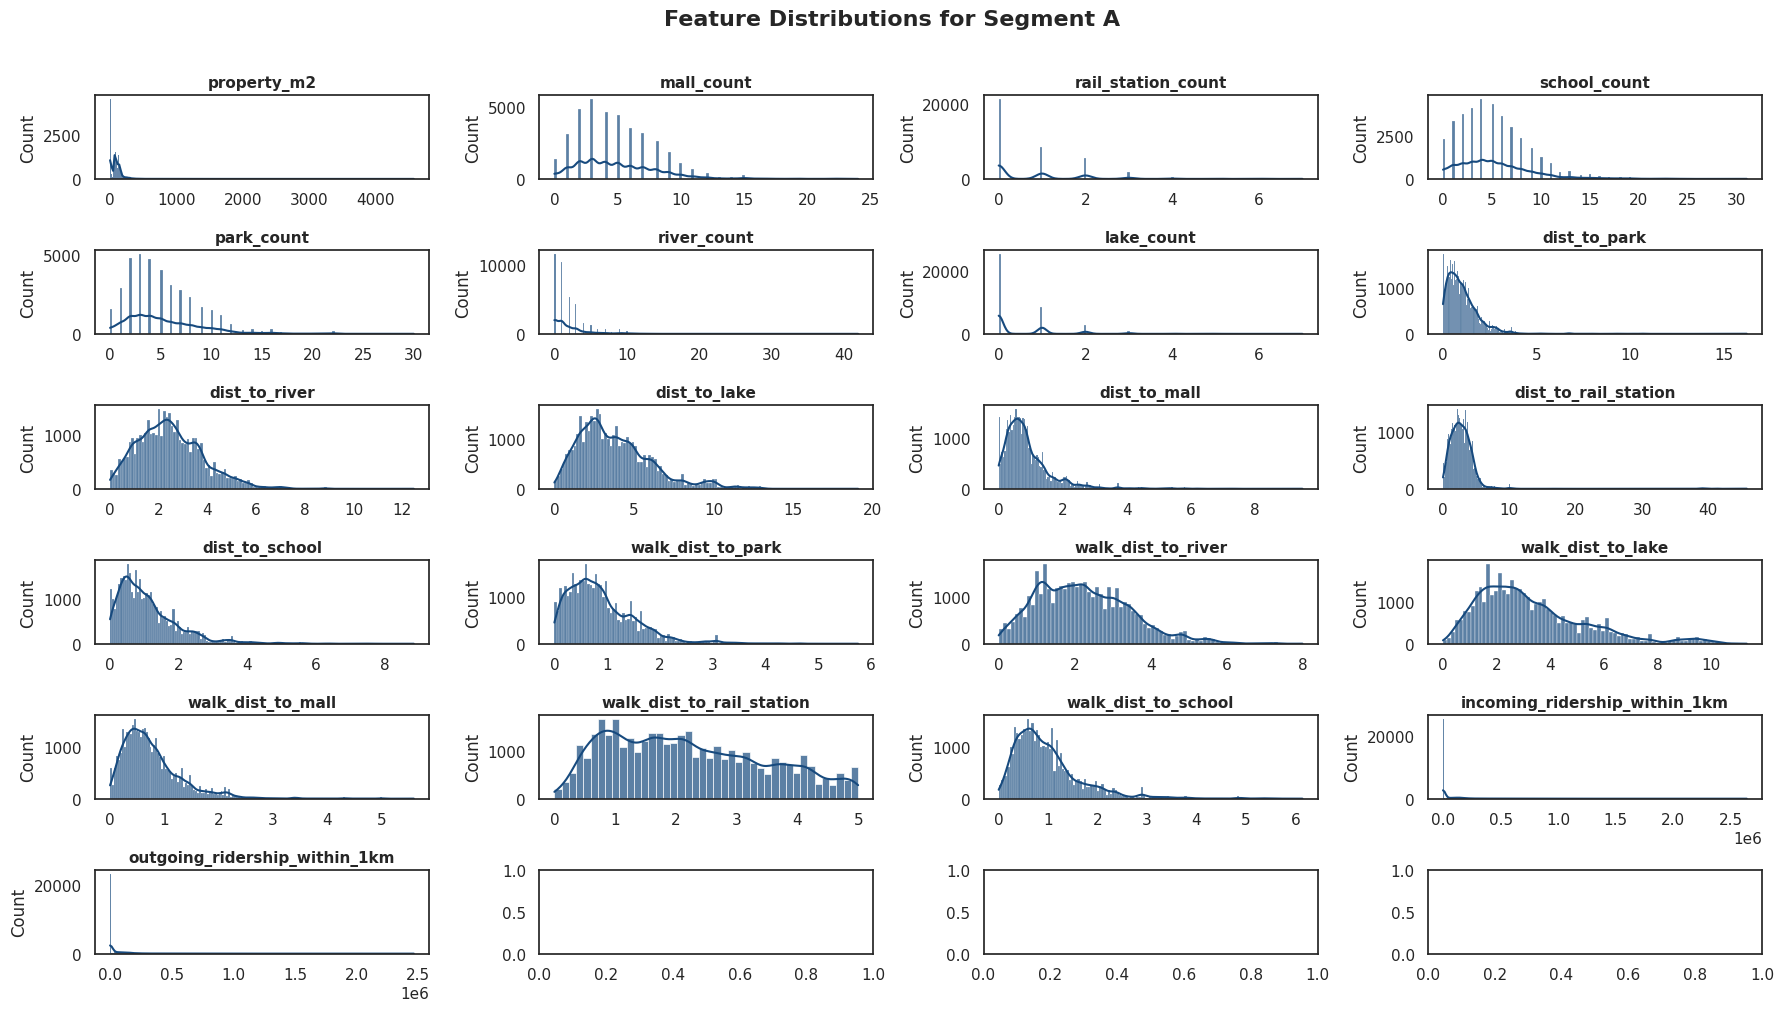

In [ ]:
# Distribution plots
key_features = ['property_m2', 'mall_count', 'rail_station_count', 'school_count', 'park_count', 'river_count',
                'lake_count', 'dist_to_park', 'dist_to_river', 'dist_to_lake', 'dist_to_mall', 'dist_to_rail_station',
                'dist_to_school', 'walk_dist_to_park', 'walk_dist_to_river', 'walk_dist_to_lake', 'walk_dist_to_mall', 'walk_dist_to_rail_station',
                'walk_dist_to_school','incoming_ridership_within_1km', 'outgoing_ridership_within_1km']

fig, axes = plt.subplots(6, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(key_features):
    sns.histplot(transit_seg[col], kde=True, ax=axes[idx], color=COLORS['blue'], alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11, weight='bold')
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions for Segment A', fontsize=16, weight='bold', y=1.01)
plt.tight_layout()
plt.show()

### Non Transit

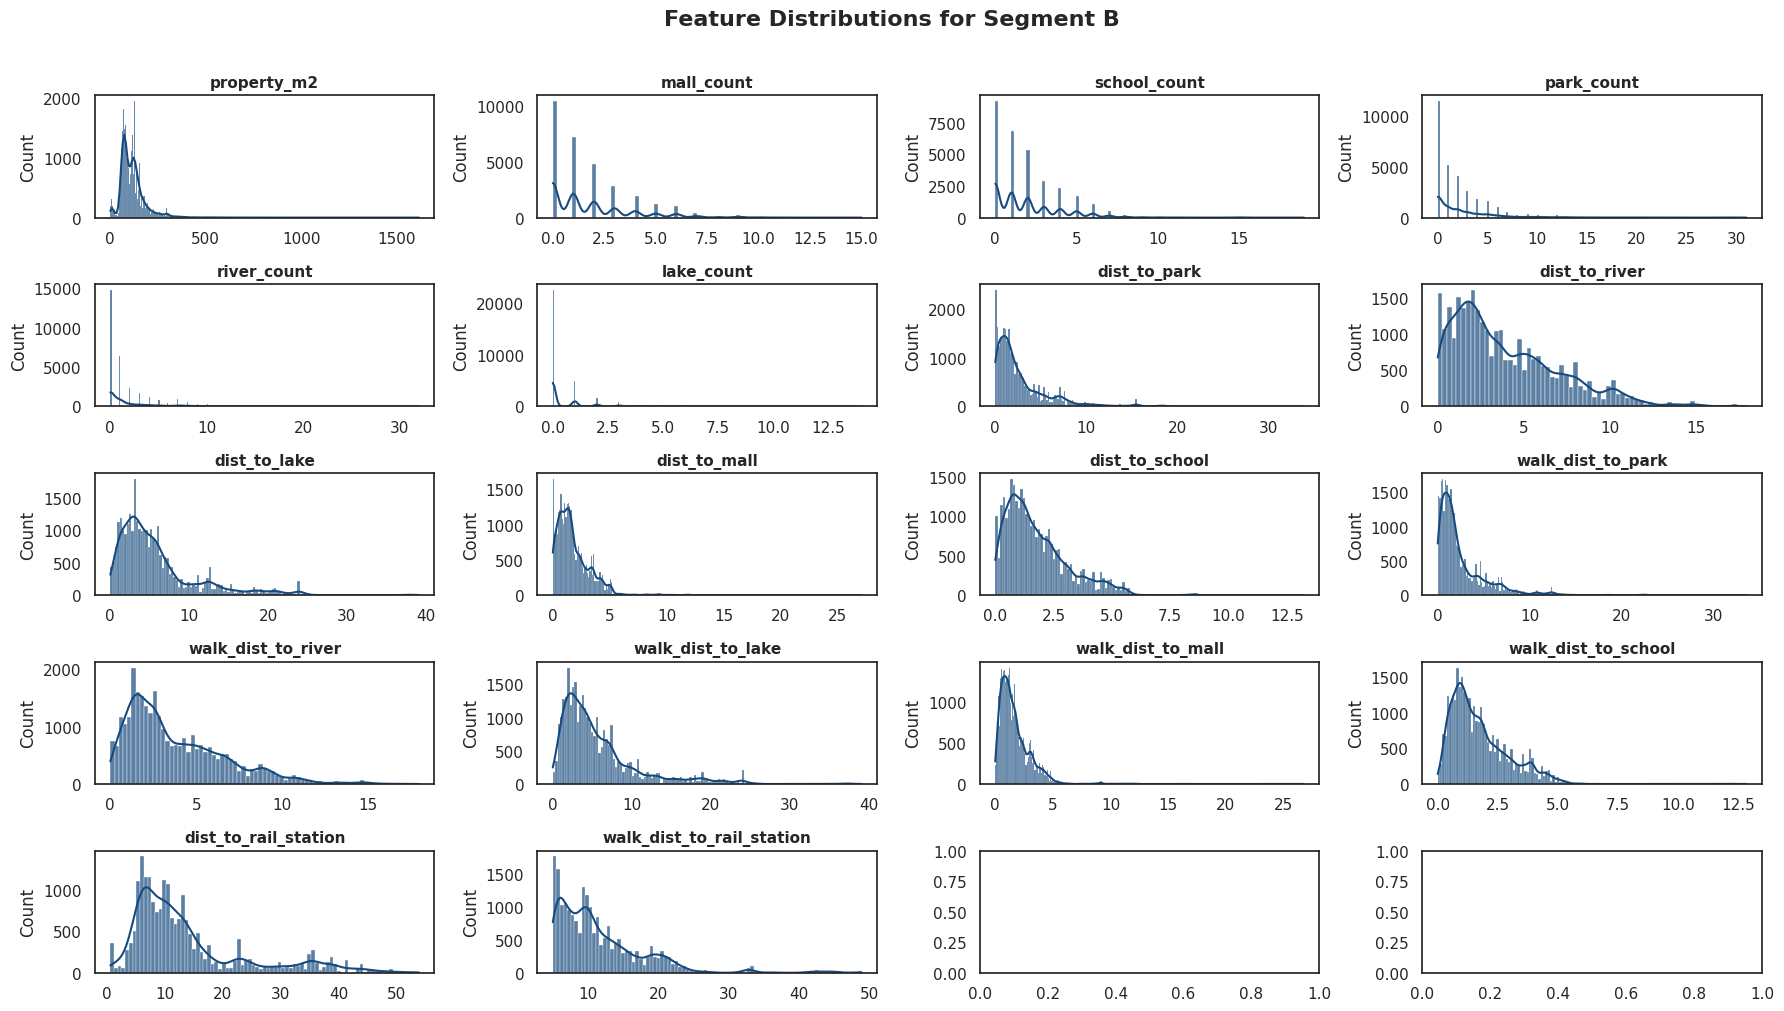

In [ ]:
# Distribution plots
key_features_non = ['property_m2', 'mall_count', 'school_count', 'park_count', 'river_count',
                'lake_count', 'dist_to_park', 'dist_to_river', 'dist_to_lake', 'dist_to_mall',
                'dist_to_school', 'walk_dist_to_park', 'walk_dist_to_river', 'walk_dist_to_lake', 'walk_dist_to_mall',
                'walk_dist_to_school', 'dist_to_rail_station', 'walk_dist_to_rail_station']

fig, axes = plt.subplots(5, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(key_features_non):
    sns.histplot(non_transit_seg[col], kde=True, ax=axes[idx], color=COLORS['blue'], alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11, weight='bold')
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions for Segment B', fontsize=16, weight='bold', y=1.01)
plt.tight_layout()
plt.show()

# ADVANCED MARKET SEGMENTATION (HYBRID CLUSTERING)

## Helper Functions

### DBSCAN Clustering

#### Plot K-Distance Graph

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from typing import Dict, List, Tuple, Optional, Any

# K-Distance Plot (Shows Real Geographic Distance)
def plot_k_distance(df, features, k=5, district_name=""):
    """
    Plot k-distance graph to help determine optimal eps
    Shows distances in KILOMETERS for geographic interpretation
    But returns standardized distances for DBSCAN
    """

    # Verify features exist
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features in dataframe: {missing_features}")

    # === GEOGRAPHIC DISTANCE (for visualization) ===
    X_geo = df[['x_coord', 'y_coord']].values
    # Haversine needs (lat, lon) order
    neighbors_geo = NearestNeighbors(n_neighbors=k, metric='haversine')
    neighbors_geo.fit(np.radians(X_geo[:, [1, 0]]))  # Swap to (lat, lon)
    distances_geo, _ = neighbors_geo.kneighbors(np.radians(X_geo[:, [1, 0]]))
    distances_km = distances_geo[:, k-1] * 6371  # Earth radius in km
    distances_km_sorted = np.sort(distances_km, axis=0)

    # === STANDARDIZED DISTANCE (for DBSCAN) ===
    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    neighbors_scaled = NearestNeighbors(n_neighbors=k)
    neighbors_scaled.fit(X_scaled)
    distances_scaled, _ = neighbors_scaled.kneighbors(X_scaled)
    distances_scaled_sorted = np.sort(distances_scaled[:, k-1], axis=0)

    # === PLOT (Geographic distances for interpretability) ===
    plt.figure(figsize=(10, 6))
    plt.plot(distances_km_sorted)
    plt.ylabel(f'{k}-NN Distance (km)', fontsize=12)
    plt.xlabel('Data Points (sorted)', fontsize=12)
    plt.title(f'K-Distance Graph for {district_name}\n(Geographic distance for interpretation)',
              fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)

    # Add horizontal lines at potential eps values (in km)
    percentiles = [90, 95, 98]
    for p in percentiles:
        val = np.percentile(distances_km_sorted, p)
        plt.axhline(y=val, color='r', linestyle='--', alpha=0.5,
                   label=f'{p}th percentile: {val:.3f} km')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # === SUGGEST EPS VALUES (in standardized units for DBSCAN) ===
    eps_suggestions = {
        'conservative': np.percentile(distances_scaled_sorted, 90),
        'balanced': np.percentile(distances_scaled_sorted, 95),
        'aggressive': np.percentile(distances_scaled_sorted, 98)
    }

    # Print geographic interpretation
    print(f"\nGeographic interpretation (approximate):")
    for approach, eps_std in eps_suggestions.items():
        # Find corresponding geographic distance
        idx = int(len(distances_scaled_sorted) * (90 if approach == 'conservative' else 95 if approach == 'balanced' else 98) / 100)
        geo_dist = distances_km_sorted[idx]
        print(f"  {approach.capitalize()}: {eps_std:.4f} (std units) ≈ {geo_dist:.3f} km")

    return distances_scaled_sorted, scaler

#### Search Visualization

In [ ]:
def plot_parameter_search_results(results, district_name=""):
    """Visualize parameter search results"""

    if len(results) == 0:
        print("No results to plot")
        return

    df_results = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'DBSCAN Parameter Search Results - {district_name}',
                 fontsize=16, weight='bold', y=1.00)

    # 1. Composite score heatmap
    pivot = df_results.pivot_table(
        values='composite_score',
        index='min_samples',
        columns='eps',
        aggfunc='mean'
    )

    sns.heatmap(pivot, annot=False, cmap='viridis', ax=axes[0, 0],
                cbar_kws={'label': 'Composite Score'})
    axes[0, 0].set_title('Composite Score by Parameters', fontsize=12, weight='bold')
    axes[0, 0].set_xlabel('eps')
    axes[0, 0].set_ylabel('min_samples')

    # 2. Number of clusters vs eps
    for min_samp in sorted(df_results['min_samples'].unique())[:10]:  # Limit legend entries
        subset = df_results[df_results['min_samples'] == min_samp]
        axes[0, 1].plot(subset['eps'], subset['n_clusters'],
                       marker='o', label=f'min_samples={min_samp}', alpha=0.6)
    axes[0, 1].set_xlabel('eps', fontsize=11)
    axes[0, 1].set_ylabel('Number of Clusters', fontsize=11)
    axes[0, 1].set_title('Clusters vs eps', fontsize=12, weight='bold')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Noise ratio vs eps
    for min_samp in sorted(df_results['min_samples'].unique())[:10]:
        subset = df_results[df_results['min_samples'] == min_samp]
        axes[1, 0].plot(subset['eps'], subset['noise_ratio'],
                       marker='o', label=f'min_samples={min_samp}', alpha=0.6)
    axes[1, 0].set_xlabel('eps', fontsize=11)
    axes[1, 0].set_ylabel('Noise Ratio', fontsize=11)
    axes[1, 0].set_title('Noise Ratio vs eps', fontsize=12, weight='bold')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='20% threshold')

    # 4. Silhouette vs composite score
    scatter = axes[1, 1].scatter(df_results['silhouette'],
                                 df_results['composite_score'],
                                 c=df_results['n_clusters'],
                                 cmap='coolwarm',
                                 s=50,
                                 alpha=0.6)
    axes[1, 1].set_xlabel('Silhouette Score', fontsize=11)
    axes[1, 1].set_ylabel('Composite Score', fontsize=11)
    axes[1, 1].set_title('Quality Metrics Comparison', fontsize=12, weight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='# Clusters')

    # Highlight best point
    best_idx = df_results['composite_score'].idxmax()
    best = df_results.loc[best_idx]
    axes[1, 1].scatter(best['silhouette'], best['composite_score'],
                      marker='*', s=500, c='gold', edgecolors='black', linewidths=2,
                      label='Best', zorder=5)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

#### Grid Search

In [ ]:
# Optimized DBSCAN with Better Parameters
def optimize_dbscan_advanced(df, features, district_name=""):
    """
    Advanced DBSCAN parameter optimization with multiple methods
    Returns best parameters and detailed analysis
    """

    # VALIDATION: Check if features exist
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        print(f"\n❌ ERROR: Missing features in dataframe: {missing_features}")
        print(f"Available columns: {df.columns.tolist()}")
        return None, []

    # Step 1: Use k-distance plot to determine eps range
    print(f"\n{'='*60}")
    print(f"Optimizing DBSCAN for {district_name}")
    print(f"{'='*60}")
    print(f"Sample size: {len(df):,}")
    print(f"Features: {features}")

    # Check for missing values
    missing_counts = df[features].isna().sum()
    if missing_counts.any():
        print(f"\n⚠ WARNING: Missing values detected:")
        print(missing_counts[missing_counts > 0])
        df = df.dropna(subset=features).copy()
        print(f"After dropping NaN: {len(df):,} samples")

    if len(df) < 10:
        print(f"\n❌ ERROR: Insufficient data after cleaning ({len(df)} samples)")
        return None, []

    # Determine target clusters based on sample size

    sample_size = len(df)
    if sample_size < 1000:
        target_clusters = 3
    elif sample_size < 5000:
        target_clusters = 5
    elif sample_size < 10000:
        target_clusters = 8
    else:
        target_clusters = 12

    # Set adaptive cluster limits
    if sample_size > 10000:  # Dense urban
        max_clusters = target_clusters * 8
    else:
        max_clusters = target_clusters * 4

    min_clusters = max(3, target_clusters // 2)

    # Determine min_samples based on dimensionality
    recommended_min_samples = len(features) + 1

    # Calculate k-distance
    k = max(5, recommended_min_samples)
    try:
        distances, scaler = plot_k_distance(df, features, k=k, district_name=district_name)
    except Exception as e:
        print(f"\n❌ ERROR in k-distance calculation: {e}")
        return None, []

    # Suggest eps range based on k-distance percentiles
    eps_suggestions = {
        'conservative': np.percentile(distances, 90),
        'balanced': np.percentile(distances, 95),
        'aggressive': np.percentile(distances, 98)
    }

    print(f"\nSuggested eps values based on k-distance:")
    for approach, eps_val in eps_suggestions.items():
        print(f"  {approach.capitalize()}: {eps_val:.4f}")

    # Step 2: Grid search with larger eps range
    eps_min = eps_suggestions['balanced'] * 2.5
    eps_max = eps_suggestions['aggressive'] * 5
    eps_range = np.linspace(eps_min, eps_max, 15)

    min_samples_range = list(range(
        max(2, recommended_min_samples - 2),
        recommended_min_samples + 9,
        1
    ))

    print(f"\nTarget clusters: {target_clusters} (range: {min_clusters}-{max_clusters})")
    print(f"Searching parameter space:")
    print(f"  eps: {eps_min:.4f} to {eps_max:.4f} ({len(eps_range)} values)")
    print(f"  min_samples: {min_samples_range[0]} to {min_samples_range[-1]}")

    # Prepare data
    X = df[features].values
    X_scaled = scaler.transform(X)

    best_score = -1
    best_params = None
    all_results = []

    print("\nSearching...", end="", flush=True)
    debug_count = 0

    # Grid search
    for min_samples in min_samples_range:
        for eps in eps_range:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
                labels = dbscan.fit_predict(X_scaled)

                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = (labels == -1).sum()
                noise_ratio = n_noise / len(labels)

                # DEBUG: Print first 10 combinations
                if debug_count < 10:
                    print(f"\n  eps={eps:.3f}, min_samples={min_samples}: "
                          f"clusters={n_clusters}, noise={noise_ratio:.1%}")
                    debug_count += 1

                # FILTER 1: Reject unrealistic cluster counts
                if n_clusters < min_clusters or n_clusters > max_clusters:
                    continue

                # FILTER 2: Reject excessive noise
                if noise_ratio > 0.4:
                    continue

                # Calculate metrics for non-noise points
                mask = labels != -1
                if mask.sum() < 10:
                    continue

                silhouette = silhouette_score(X_scaled[mask], labels[mask])

                # Skip very poor clustering quality
                if silhouette < 0.05:
                    continue

                davies_bouldin = davies_bouldin_score(X_scaled[mask], labels[mask])
                calinski_harabasz = calinski_harabasz_score(X_scaled[mask], labels[mask])

                # Composite score
                db_normalized = 1 / (1 + davies_bouldin)
                ch_normalized = min(calinski_harabasz / 1000, 1)

                # Adaptive cluster count penalty
                cluster_deviation = abs(n_clusters - target_clusters)
                if n_clusters < target_clusters:
                    cluster_score = max(0, 1 - (cluster_deviation / target_clusters) * 2)
                else:
                    cluster_score = max(0, 1 - (cluster_deviation / (target_clusters * 2)))

                # Reweighted composite score
                composite_score = (
                    0.25 * silhouette +
                    0.20 * db_normalized +
                    0.10 * ch_normalized +
                    0.25 * cluster_score +
                    0.20 * (1 - noise_ratio)
                )

                # DEBUG: Print scores for promising candidates
                if n_clusters >= min_clusters and noise_ratio < 0.2 and len(all_results) < 10:
                    print(f"     → Silhouette: {silhouette:.3f}, DB: {davies_bouldin:.3f}, "
                          f"Cluster_score: {cluster_score:.3f}, Composite: {composite_score:.3f}")

                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_ratio': noise_ratio,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz,
                    'composite_score': composite_score,
                    'cluster_score': cluster_score
                }
                all_results.append(result)

                if composite_score > best_score:
                    best_score = composite_score
                    best_params = result.copy()
                    best_params['scaler'] = scaler

            except Exception as e:
                if debug_count < 5:
                    print(f"\n  ⚠ Error at eps={eps:.3f}, min_samples={min_samples}: {e}")
                continue

    print(" Done!")

    # Display results
    if best_params:
        print(f"\n✓ Optimization complete!")
        print(f"\nBest parameters:")
        print(f"  eps: {best_params['eps']:.4f}")
        print(f"  min_samples: {best_params['min_samples']}")
        print(f"\nResulting clusters:")
        print(f"  Number of clusters: {best_params['n_clusters']}")
        print(f"  Noise points: {best_params['n_noise']} ({best_params['noise_ratio']:.1%})")
        print(f"\nQuality metrics:")
        print(f"  Silhouette score: {best_params['silhouette']:.3f}")
        print(f"  Davies-Bouldin index: {best_params['davies_bouldin']:.3f} (lower is better)")
        print(f"  Calinski-Harabasz score: {best_params['calinski_harabasz']:.1f} (higher is better)")
        print(f"  Cluster count score: {best_params['cluster_score']:.3f}")
        print(f"  Composite score: {best_params['composite_score']:.3f}")

        # Plot results if we have them
        if len(all_results) > 0:
            plot_parameter_search_results(all_results, district_name)

    else:
        print(f"\n⚠ No suitable parameters found!")
        if len(all_results) > 0:
            print(f"\nFound {len(all_results)} parameter combinations, but none met quality thresholds.")
            print(f"Top 5 results by composite score:")
            df_res = pd.DataFrame(all_results).sort_values('composite_score', ascending=False).head()
            print(df_res[['eps', 'min_samples', 'n_clusters', 'noise_ratio', 'silhouette', 'composite_score']])
        else:
            print(f"No valid combinations found. Try:")
            print(f"  - Using K-Means instead of DBSCAN")

    return best_params, all_results

### K-Means Clustering

In [ ]:
def cluster_dense_district_kmeans(df, features, target_clusters, district_name):
    """Use K-Means for dense urban districts where DBSCAN fails"""

    print(f"\n{'='*60}")
    print(f"Using K-Means for {district_name} (dense urban area)")
    print(f"{'='*60}")
    print(f"Sample size: {len(df):,}")

    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Try different K values and pick best
    best_score = -1
    best_k = target_clusters
    best_labels = None

    print(f"\nTesting K values from {max(3, target_clusters-5)} to {target_clusters+8}...")

    for k in range(max(3, target_clusters-5), target_clusters+8):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
        labels = kmeans.fit_predict(X_scaled)

        silhouette = silhouette_score(X_scaled, labels)

        if k <= target_clusters + 3:
            print(f"  K={k}: Silhouette={silhouette:.3f}")

        if silhouette > best_score:
            best_score = silhouette
            best_k = k
            best_labels = labels

    print(f"\n✓ Best K-Means result:")
    print(f"  Number of clusters: {best_k}")
    print(f"  Silhouette score: {best_score:.3f}")
    print(f"  Noise points: 0 (K-Means assigns all points)")

    return best_labels, best_k, scaler, best_score

In [ ]:
def get_kmeans_target_clusters(
    sample_size: int,
    custom_thresholds: Optional[Dict[str, int]] = None
) -> int:
    """
    Determine target number of clusters for K-Means based on sample size.

    Uses domain-informed heuristics to balance granularity with statistical validity.
    Larger districts get more clusters to capture market heterogeneity.

    Parameters
    ----------
    sample_size : int
        Number of properties in the district
    custom_thresholds : dict, optional
        Custom thresholds in format {'>15000': 20, '>10000': 15, 'default': 12}

    Returns
    -------
    int
        Target number of clusters

    Examples
    --------
    >>> get_kmeans_target_clusters(18000)
    20
    >>> get_kmeans_target_clusters(8000)
    12
    """
    if custom_thresholds is None:
        # Default thresholds based on domain knowledge
        if sample_size > 15000:
            return 20
        elif sample_size > 10000:
            return 15
        else:
            return 12
    else:
        # User-defined thresholds
        for threshold_str, n_clusters in sorted(
            custom_thresholds.items(),
            key=lambda x: int(x[0].replace('>', '').replace('default', '0')),
            reverse=True
        ):
            if threshold_str == 'default':
                return n_clusters
            threshold_val = int(threshold_str.replace('>', ''))
            if sample_size > threshold_val:
                return n_clusters
        return custom_thresholds.get('default', 12)

## Cluster Function

In [ ]:
def cluster_segment_by_districts(
    df_segment: pd.DataFrame,
    clustering_features: List[str],
    min_sample_size: int = 50,
    min_clusters: int = 6,
    min_silhouette: float = 0.15,
    kmeans_thresholds: Optional[Dict[str, int]] = None,
    strict_mode: bool = False,
    verbose: bool = True
) -> Dict[str, Any]:
    """
    Attempt DBSCAN clustering for each district, with K-Means fallback for failures.

    This function is segment-agnostic and can process any dataframe with district
    and coordinate information. It attempts DBSCAN optimization first, then applies
    K-Means to districts that fail quality thresholds.

    Parameters
    ----------
    df_segment : pd.DataFrame
        DataFrame containing properties to cluster (must have 'district' column)
    clustering_features : list of str
        Feature names to use for clustering (e.g., ['x_coord', 'y_coord'])
    min_sample_size : int, default=50
        Minimum properties required in a district to attempt clustering
    min_clusters : int, default=6
        Minimum clusters required for DBSCAN success (domain knowledge)
    min_silhouette : float, default=0.15
        Minimum silhouette score for DBSCAN success (domain knowledge)
    kmeans_thresholds : dict, optional
        Custom sample size thresholds for K-Means cluster counts
    strict_mode : bool, default=False
        If True, raise exceptions on quality violations; if False, issue warnings
    verbose : bool, default=True
        Print detailed progress and results

    Returns
    -------
    dict
        Dictionary with keys:
            - 'district_configs': Dict mapping district names to clustering configs
            - 'failed_districts': List of districts where DBSCAN failed
            - 'summary': Dict with statistics (total_districts, successful, failed, etc.)
            - 'warnings': List of warning messages generated during processing

    Raises
    ------
    ValueError
        If required columns are missing (in strict mode or always for fatal errors)
    RuntimeError
        If all districts fail clustering (in strict mode only)

    Examples
    --------
    >>> result = cluster_segment_by_districts(
    ...     transit_seg,
    ...     ['x_coord', 'y_coord'],
    ...     min_clusters=6,
    ...     min_silhouette=0.15
    ... )
    >>> print(f"Configured {len(result['district_configs'])} districts")
    >>> print(f"Failed districts: {result['failed_districts']}")
    """

    # ========================================================================
    # VALIDATION: Check required columns
    # ========================================================================
    required_cols = ['district'] + clustering_features
    missing_cols = [col for col in required_cols if col not in df_segment.columns]

    if missing_cols:
        error_msg = f"❌ ERROR: Missing required columns: {missing_cols}"
        if verbose:
            print(error_msg)
            print(f"Available columns: {df_segment.columns.tolist()}")
        raise ValueError(error_msg)

    if verbose:
        print(f"✓ All required features present: {clustering_features}")

    # ========================================================================
    # INITIALIZATION
    # ========================================================================
    district_configs = {}
    failed_districts = []
    warnings = []
    skipped_districts = []

    districts = df_segment['district'].unique()
    total_districts = len(districts)

    if verbose:
        print(f"\n{'='*80}")
        print(f"PHASE 1: DBSCAN CLUSTERING ATTEMPT")
        print(f"{'='*80}")
        print(f"Total districts to process: {total_districts}")
        print(f"Minimum sample size: {min_sample_size}")
        print(f"Quality thresholds: min_clusters={min_clusters}, min_silhouette={min_silhouette}")

    # ========================================================================
    # PHASE 1: ATTEMPT DBSCAN FOR EACH DISTRICT
    # ========================================================================
    for district in districts:
        district_data = df_segment[df_segment['district'] == district].copy()
        sample_size = len(district_data)

        # Skip districts with insufficient data
        if sample_size < min_sample_size:
            msg = f"⚠️  Skipping {district}: insufficient data ({sample_size} < {min_sample_size})"
            if verbose:
                print(f"\n{msg}")
            warnings.append(msg)
            skipped_districts.append(district)
            continue

        if verbose:
            print(f"\n{'='*60}")
            print(f"Processing: {district}")
            print(f"{'='*60}")
            print(f"Sample size: {sample_size:,}")

        # Run DBSCAN optimization (assumes function exists in environment)
        try:
            best_params, all_results = optimize_dbscan_advanced(
                district_data,
                clustering_features,
                district_name=district.upper()
            )
        except Exception as e:
            msg = f"❌ {district}: DBSCAN optimization failed with error: {str(e)}"
            if verbose:
                print(msg)
            warnings.append(msg)
            failed_districts.append(district)
            if strict_mode:
                raise RuntimeError(msg) from e
            continue

        # Evaluate DBSCAN results
        if best_params is None:
            msg = f"❌ {district}: DBSCAN failed (no valid parameters found)"
            if verbose:
                print(msg)
            warnings.append(msg)
            failed_districts.append(district)
            continue

        n_clusters = best_params['n_clusters']
        silhouette = best_params['silhouette']

        # Check quality thresholds
        if n_clusters < min_clusters:
            msg = f"⚠️  {district}: Too few clusters ({n_clusters} < {min_clusters})"
            if verbose:
                print(msg)
            warnings.append(msg)
            failed_districts.append(district)
            if strict_mode:
                raise ValueError(msg)
            continue

        if silhouette < min_silhouette:
            msg = f"⚠️  {district}: Poor silhouette ({silhouette:.3f} < {min_silhouette})"
            if verbose:
                print(msg)
            warnings.append(msg)
            failed_districts.append(district)
            if strict_mode:
                raise ValueError(msg)
            continue

        # DBSCAN SUCCESS: Store configuration
        suffix = district[:2].lower()
        district_configs[district] = {
            'method': 'dbscan',
            'eps': best_params['eps'],
            'min_samples': best_params['min_samples'],
            'n_clusters': n_clusters,
            'noise_ratio': best_params['noise_ratio'],
            'silhouette': silhouette,
            'features': clustering_features,
            'scaler': best_params['scaler'],
            'suffix': suffix
        }

        if verbose:
            print(f"✅ {district}: DBSCAN successful")
            print(f"   Clusters: {n_clusters}, Silhouette: {silhouette:.3f}")

    # ========================================================================
    # PHASE 2: K-MEANS FALLBACK FOR FAILED DISTRICTS
    # ========================================================================
    if failed_districts:
        if verbose:
            print(f"\n{'='*80}")
            print(f"PHASE 2: K-MEANS FALLBACK FOR FAILED DISTRICTS")
            print(f"{'='*80}")
            print(f"Districts needing K-Means: {len(failed_districts)}")
            for district in failed_districts:
                count = (df_segment['district'] == district).sum()
                print(f"  - {district}: {count:,} properties")

        kmeans_failures = []

        for district in failed_districts:
            district_data = df_segment[df_segment['district'] == district].copy()
            sample_size = len(district_data)

            if sample_size == 0:
                msg = f"⚠️  ERROR: No data for '{district}'"
                if verbose:
                    print(f"\n{msg}")
                warnings.append(msg)
                kmeans_failures.append(district)
                continue

            if verbose:
                print(f"\n{'='*60}")
                print(f"K-Means for {district}")
                print(f"{'='*60}")
                print(f"Sample size: {sample_size:,}")

            # Determine target clusters
            target_k = get_kmeans_target_clusters(sample_size, kmeans_thresholds)

            if verbose:
                print(f"Target clusters: {target_k}")

            # Apply K-Means (assumes function exists in environment)
            try:
                labels, n_clusters, scaler, silhouette = cluster_dense_district_kmeans(
                    district_data,
                    clustering_features,
                    target_k,
                    district
                )
            except Exception as e:
                msg = f"❌ {district}: K-Means failed with error: {str(e)}"
                if verbose:
                    print(msg)
                warnings.append(msg)
                kmeans_failures.append(district)
                if strict_mode:
                    raise RuntimeError(msg) from e
                continue

            # Store K-Means configuration
            suffix = district[:2].lower()
            district_configs[district] = {
                'method': 'kmeans',
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'features': clustering_features,
                'scaler': scaler,
                'labels': labels,
                'suffix': suffix
            }

            if verbose:
                print(f"✅ {district}: K-Means successful")
                print(f"   Clusters: {n_clusters}, Silhouette: {silhouette:.3f}")

        # Update failed districts list
        if kmeans_failures:
            msg = f"⚠️  {len(kmeans_failures)} districts failed both DBSCAN and K-Means: {kmeans_failures}"
            warnings.append(msg)
            if verbose:
                print(f"\n{msg}")

    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    successful_districts = len(district_configs)
    total_failed = len([d for d in districts if d not in district_configs and d not in skipped_districts])

    summary = {
        'total_districts': total_districts,
        'successful': successful_districts,
        'failed': total_failed,
        'skipped': len(skipped_districts),
        'dbscan_count': sum(1 for cfg in district_configs.values() if cfg['method'] == 'dbscan'),
        'kmeans_count': sum(1 for cfg in district_configs.values() if cfg['method'] == 'kmeans'),
        'success_rate': successful_districts / total_districts if total_districts > 0 else 0
    }

    if verbose:
        print(f"\n{'='*80}")
        print(f"CLUSTERING CONFIGURATION COMPLETE")
        print(f"{'='*80}")
        print(f"Total districts: {summary['total_districts']}")
        print(f"✅ Successful: {summary['successful']} ({summary['success_rate']:.1%})")
        print(f"   - DBSCAN: {summary['dbscan_count']}")
        print(f"   - K-Means: {summary['kmeans_count']}")
        print(f"❌ Failed: {summary['failed']}")
        print(f"⚠️  Skipped (too small): {summary['skipped']}")
        print(f"⚠️  Warnings generated: {len(warnings)}")

    # Check if all districts failed
    if successful_districts == 0 and total_districts > 0:
        msg = "❌ CRITICAL: All districts failed clustering!"
        warnings.append(msg)
        if strict_mode:
            raise RuntimeError(msg)
        elif verbose:
            print(f"\n{msg}")

    # ========================================================================
    # RETURN RESULTS
    # ========================================================================
    return {
        'district_configs': district_configs,
        'failed_districts': [d for d in districts if d not in district_configs and d not in skipped_districts],
        'skipped_districts': skipped_districts,
        'summary': summary,
        'warnings': warnings
    }

## Apply Cluster Function

In [ ]:
def apply_hybrid_clustering(df, district_configs):
    """Apply both DBSCAN and K-Means clustering results"""
    df_result = df.copy()

    # Initialize columns
    df_result['market_cluster'] = -1
    df_result['market_cluster_id'] = 'NOISE'
    df_result['is_noise'] = True
    df_result['clustering_method'] = 'none'

    cluster_id_counter = 0

    for district, config in district_configs.items():
        method = config.get('method', 'dbscan')
        print(f"\nApplying {method.upper()} to {district}...")

        mask = df_result['district'] == district
        df_district = df_result[mask].copy()

        if method == 'kmeans':
            # Use stored K-Means labels
            labels = config['labels']

            # Assign labels
            df_result.loc[mask, 'market_cluster'] = labels
            df_result.loc[mask, 'is_noise'] = False
            df_result.loc[mask, 'clustering_method'] = 'kmeans'

            # Create unique cluster IDs
            for cluster_num in sorted(set(labels)):
                cluster_mask = mask & (df_result['market_cluster'] == cluster_num)
                cluster_id = f"{config['suffix'].upper()}_{cluster_id_counter:03d}"
                df_result.loc[cluster_mask, 'market_cluster_id'] = cluster_id
                cluster_id_counter += 1

            n_clusters = len(set(labels))
            print(f"  ✓ {n_clusters} clusters, 0 noise points")

        else:
            # Use DBSCAN
            X = df_district[config['features']].values
            X_scaled = config['scaler'].transform(X)

            dbscan = DBSCAN(eps=config['eps'], min_samples=config['min_samples'], n_jobs=-1)
            labels = dbscan.fit_predict(X_scaled)

            df_result.loc[mask, 'market_cluster'] = labels
            df_result.loc[mask, 'is_noise'] = (labels == -1)
            df_result.loc[mask, 'clustering_method'] = 'dbscan'

            # Create unique cluster IDs
            unique_clusters = sorted([l for l in set(labels) if l != -1])
            for cluster_num in unique_clusters:
                cluster_mask = mask & (df_result['market_cluster'] == cluster_num)
                cluster_id = f"{config['suffix'].upper()}_{cluster_id_counter:03d}"
                df_result.loc[cluster_mask, 'market_cluster_id'] = cluster_id
                cluster_id_counter += 1

            n_clusters = len(unique_clusters)
            n_noise = (labels == -1).sum()
            print(f"  ✓ {n_clusters} clusters, {n_noise} noise points ({n_noise/len(df_district):.1%})")

    return df_result

In [ ]:
def apply_clustering_to_segment(
    df_segment: pd.DataFrame,
    district_configs: Dict[str, Dict[str, Any]],
    validate: bool = True,
    verbose: bool = True
) -> Tuple[pd.DataFrame, Optional[Dict[str, Any]]]:
    """
    Apply hybrid clustering configurations to the segment and validate results.

    This function applies the clustering configurations generated by
    `cluster_segment_by_districts()` and optionally performs comprehensive
    validation checks.

    Parameters
    ----------
    df_segment : pd.DataFrame
        DataFrame to apply clustering to (same as used in configuration)
    district_configs : dict
        District configurations from `cluster_segment_by_districts()`
    validate : bool, default=True
        Whether to perform validation and return validation report
    verbose : bool, default=True
        Print detailed validation results

    Returns
    -------
    tuple
        - clustered_df (pd.DataFrame): DataFrame with cluster assignments
        - validation_report (dict or None): Validation metrics and diagnostics

    Raises
    ------
    ValueError
        If district_configs is empty or invalid

    Examples
    --------
    >>> result = cluster_segment_by_districts(transit_seg, ['x_coord', 'y_coord'])
    >>> clustered_df, validation = apply_clustering_to_segment(
    ...     transit_seg,
    ...     result['district_configs'],
    ...     validate=True
    ... )
    >>> print(f"Total clusters: {validation['total_clusters']}")
    >>> print(f"Noise ratio: {validation['noise_ratio']:.2%}")
    """

    # ========================================================================
    # VALIDATION: Check inputs
    # ========================================================================
    if not district_configs:
        error_msg = "❌ ERROR: district_configs is empty. No clustering to apply."
        if verbose:
            print(error_msg)
        raise ValueError(error_msg)

    if 'district' not in df_segment.columns:
        error_msg = "❌ ERROR: df_segment must have 'district' column"
        if verbose:
            print(error_msg)
        raise ValueError(error_msg)

    # ========================================================================
    # APPLY HYBRID CLUSTERING
    # ========================================================================
    if verbose:
        print(f"\n{'='*80}")
        print(f"APPLYING HYBRID CLUSTERING")
        print(f"{'='*80}")

    # Apply clustering (assumes function exists in environment)
    try:
        clustered_df = apply_hybrid_clustering(df_segment, district_configs)
    except Exception as e:
        error_msg = f"❌ ERROR: apply_hybrid_clustering failed: {str(e)}"
        if verbose:
            print(error_msg)
        raise RuntimeError(error_msg) from e

    if verbose:
        print(f"✓ Clustering applied successfully")

    # ========================================================================
    # VALIDATION (Optional)
    # ========================================================================
    validation_report = None

    if validate:
        if verbose:
            print(f"\n{'='*80}")
            print(f"VALIDATION REPORT")
            print(f"{'='*80}")

        # Calculate validation metrics
        total_clusters = clustered_df['market_cluster_id'].nunique()
        if 'NOISE' in clustered_df['market_cluster_id'].values:
            total_clusters -= 1

        noise_count = clustered_df.get('is_noise', pd.Series([False] * len(clustered_df))).sum()
        noise_ratio = noise_count / len(clustered_df) if len(clustered_df) > 0 else 0

        # Method breakdown
        method_counts = clustered_df.groupby('clustering_method').size()
        method_breakdown = {
            method: {
                'count': int(count),
                'percentage': count / len(clustered_df)
            }
            for method, count in method_counts.items()
        }

        # District-level statistics
        district_stats = []
        for district in sorted(district_configs.keys()):
            config = district_configs[district]
            method = config['method']
            n_clust = config['n_clusters']
            sil = config.get('silhouette', 0)
            n_props = (clustered_df['district'] == district).sum()

            district_stats.append({
                'district': district,
                'method': method,
                'n_clusters': n_clust,
                'silhouette': sil,
                'n_properties': n_props
            })

        # Coverage check
        configured_districts = set(district_configs.keys())
        actual_districts = set(df_segment['district'].unique())
        missing_districts = actual_districts - configured_districts

        total_configured = sum((clustered_df['district'] == d).sum()
                              for d in configured_districts)
        coverage_ratio = total_configured / len(clustered_df) if len(clustered_df) > 0 else 0

        # Build validation report
        validation_report = {
            'total_properties': len(clustered_df),
            'total_clusters': total_clusters,
            'noise_count': int(noise_count),
            'noise_ratio': noise_ratio,
            'method_breakdown': method_breakdown,
            'district_stats': district_stats,
            'coverage': {
                'configured_properties': int(total_configured),
                'total_properties': len(clustered_df),
                'coverage_ratio': coverage_ratio,
                'missing_districts': list(missing_districts)
            }
        }

        # Print validation results
        if verbose:
            print(f"\n📊 Overall Statistics:")
            print(f"   Total properties: {validation_report['total_properties']:,}")
            print(f"   Total clusters: {validation_report['total_clusters']}")
            print(f"   Noise points: {validation_report['noise_count']:,} ({noise_ratio:.1%})")

            print(f"\n📈 Method Breakdown:")
            for method, stats in method_breakdown.items():
                print(f"   {method}: {stats['count']:,} properties ({stats['percentage']:.1%})")

            print(f"\n📍 District-Level Summary:")
            for stat in district_stats:
                print(f"   {stat['district']:20s}: {stat['n_clusters']:2d} clusters "
                      f"({stat['method']:6s}, silhouette={stat['silhouette']:.3f}, "
                      f"{stat['n_properties']:,} props)")

            print(f"\n🎯 Coverage Check:")
            print(f"   Configured: {validation_report['coverage']['configured_properties']:,} / "
                  f"{validation_report['coverage']['total_properties']:,} properties "
                  f"({coverage_ratio:.1%})")

            if missing_districts:
                print(f"\n⚠️  WARNING: {len(missing_districts)} districts not configured:")
                for district in missing_districts:
                    count = (df_segment['district'] == district).sum()
                    print(f"      - {district}: {count:,} properties")
            else:
                print(f"   ✅ All districts configured!")

    if verbose:
        print(f"\n{'='*80}")
        print(f"✓ CLUSTERING PIPELINE COMPLETE")
        print(f"{'='*80}\n")

    return clustered_df, validation_report

## Full Pipeline

In [ ]:
def run_full_clustering_pipeline(
    df_segment: pd.DataFrame,
    clustering_features: List[str],
    min_sample_size: int = 50,
    min_clusters: int = 6,
    min_silhouette: float = 0.15,
    kmeans_thresholds: Optional[Dict[str, int]] = None,
    validate: bool = True,
    strict_mode: bool = False,
    verbose: bool = True
) -> Tuple[pd.DataFrame, Dict[str, Any], Optional[Dict[str, Any]]]:
    """
    Orchestrator function that runs the complete clustering pipeline.

    This convenience function combines configuration, application, and validation
    into a single call. Use this for quick pipeline execution or when you don't
    need to inspect intermediate results.

    Parameters
    ----------
    df_segment : pd.DataFrame
        DataFrame to cluster (must have 'district' column and clustering features)
    clustering_features : list of str
        Feature names for clustering (e.g., ['x_coord', 'y_coord'])
    min_sample_size : int, default=50
        Minimum properties required per district
    min_clusters : int, default=6
        Minimum clusters for DBSCAN success
    min_silhouette : float, default=0.15
        Minimum silhouette for DBSCAN success
    kmeans_thresholds : dict, optional
        Custom K-Means cluster count thresholds
    validate : bool, default=True
        Perform validation after clustering
    strict_mode : bool, default=False
        Raise exceptions on quality violations
    verbose : bool, default=True
        Print detailed progress

    Returns
    -------
    tuple
        - clustered_df (pd.DataFrame): DataFrame with cluster assignments
        - config_result (dict): Configuration results from Phase 1
        - validation_report (dict or None): Validation metrics

    Examples
    --------
    >>> # Quick pipeline execution
    >>> clustered_df, config, validation = run_full_clustering_pipeline(
    ...     transit_seg,
    ...     ['x_coord', 'y_coord'],
    ...     min_clusters=6,
    ...     min_silhouette=0.15
    ... )
    >>>
    >>> # Access configuration details
    >>> print(f"Configured {config['summary']['successful']} districts")
    >>> print(f"DBSCAN: {config['summary']['dbscan_count']}, K-Means: {config['summary']['kmeans_count']}")
    >>>
    >>> # Access validation metrics
    >>> print(f"Total clusters: {validation['total_clusters']}")
    >>> print(f"Noise ratio: {validation['noise_ratio']:.2%}")
    """

    if verbose:
        print(f"\n{'='*80}")
        print(f"FULL CLUSTERING PIPELINE START")
        print(f"{'='*80}")
        print(f"Segment size: {len(df_segment):,} properties")
        print(f"Features: {clustering_features}")
        print(f"Quality thresholds: clusters≥{min_clusters}, silhouette≥{min_silhouette}")

    # Phase 1: Configure clustering
    config_result = cluster_segment_by_districts(
        df_segment=df_segment,
        clustering_features=clustering_features,
        min_sample_size=min_sample_size,
        min_clusters=min_clusters,
        min_silhouette=min_silhouette,
        kmeans_thresholds=kmeans_thresholds,
        strict_mode=strict_mode,
        verbose=verbose
    )

    # Phase 2: Apply clustering and validate
    clustered_df, validation_report = apply_clustering_to_segment(
        df_segment=df_segment,
        district_configs=config_result['district_configs'],
        validate=validate,
        verbose=verbose
    )

    return clustered_df, config_result, validation_report


FULL CLUSTERING PIPELINE START
Segment size: 38,260 properties
Features: ['x_coord', 'y_coord']
Quality thresholds: clusters≥6, silhouette≥0.15
✓ All required features present: ['x_coord', 'y_coord']

PHASE 1: DBSCAN CLUSTERING ATTEMPT
Total districts to process: 8
Minimum sample size: 50
Quality thresholds: min_clusters=6, min_silhouette=0.15

Processing: gombak
Sample size: 939

Optimizing DBSCAN for GOMBAK
Sample size: 939
Features: ['x_coord', 'y_coord']


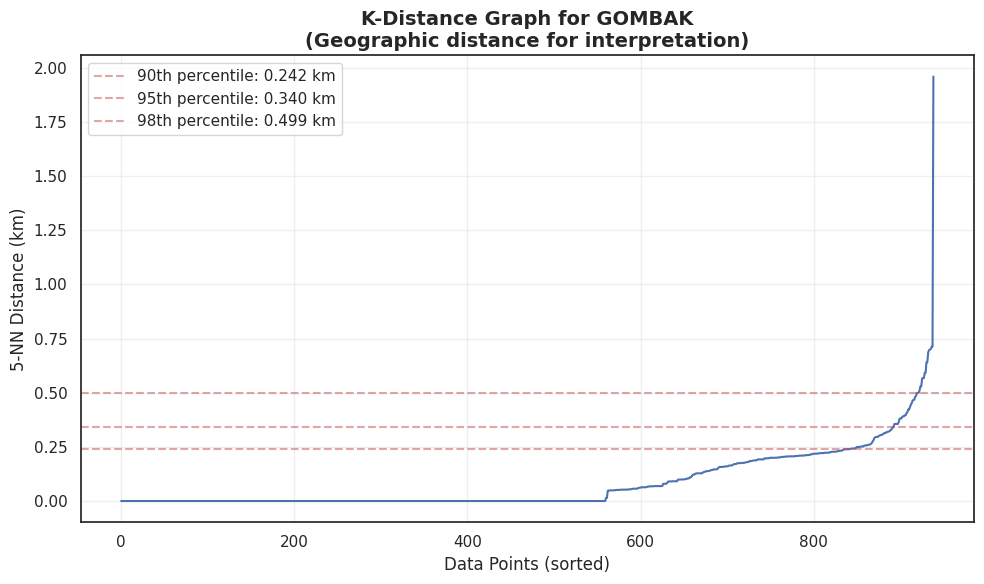


Geographic interpretation (approximate):
  Conservative: 0.0558 (std units) ≈ 0.242 km
  Balanced: 0.0691 (std units) ≈ 0.341 km
  Aggressive: 0.1003 (std units) ≈ 0.499 km

Suggested eps values based on k-distance:
  Conservative: 0.0558
  Balanced: 0.0691
  Aggressive: 0.1003

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 0.1727 to 0.5013 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.173, min_samples=2: clusters=6, noise=0.1%
     → Silhouette: 0.761, DB: 0.575, Cluster_score: 0.500, Composite: 0.742

  eps=0.196, min_samples=2: clusters=5, noise=0.1%
     → Silhouette: 0.774, DB: 0.424, Cluster_score: 0.667, Composite: 0.801

  eps=0.220, min_samples=2: clusters=4, noise=0.1%
     → Silhouette: 0.829, DB: 0.306, Cluster_score: 0.833, Composite: 0.869

  eps=0.243, min_samples=2: clusters=4, noise=0.1%
     → Silhouette: 0.829, DB: 0.306, Cluster_score: 0.833, Composite: 0.869

  eps=0.267, min_samples=2: clusters=4, noise=0.1%
     → Silhouette: 0.82

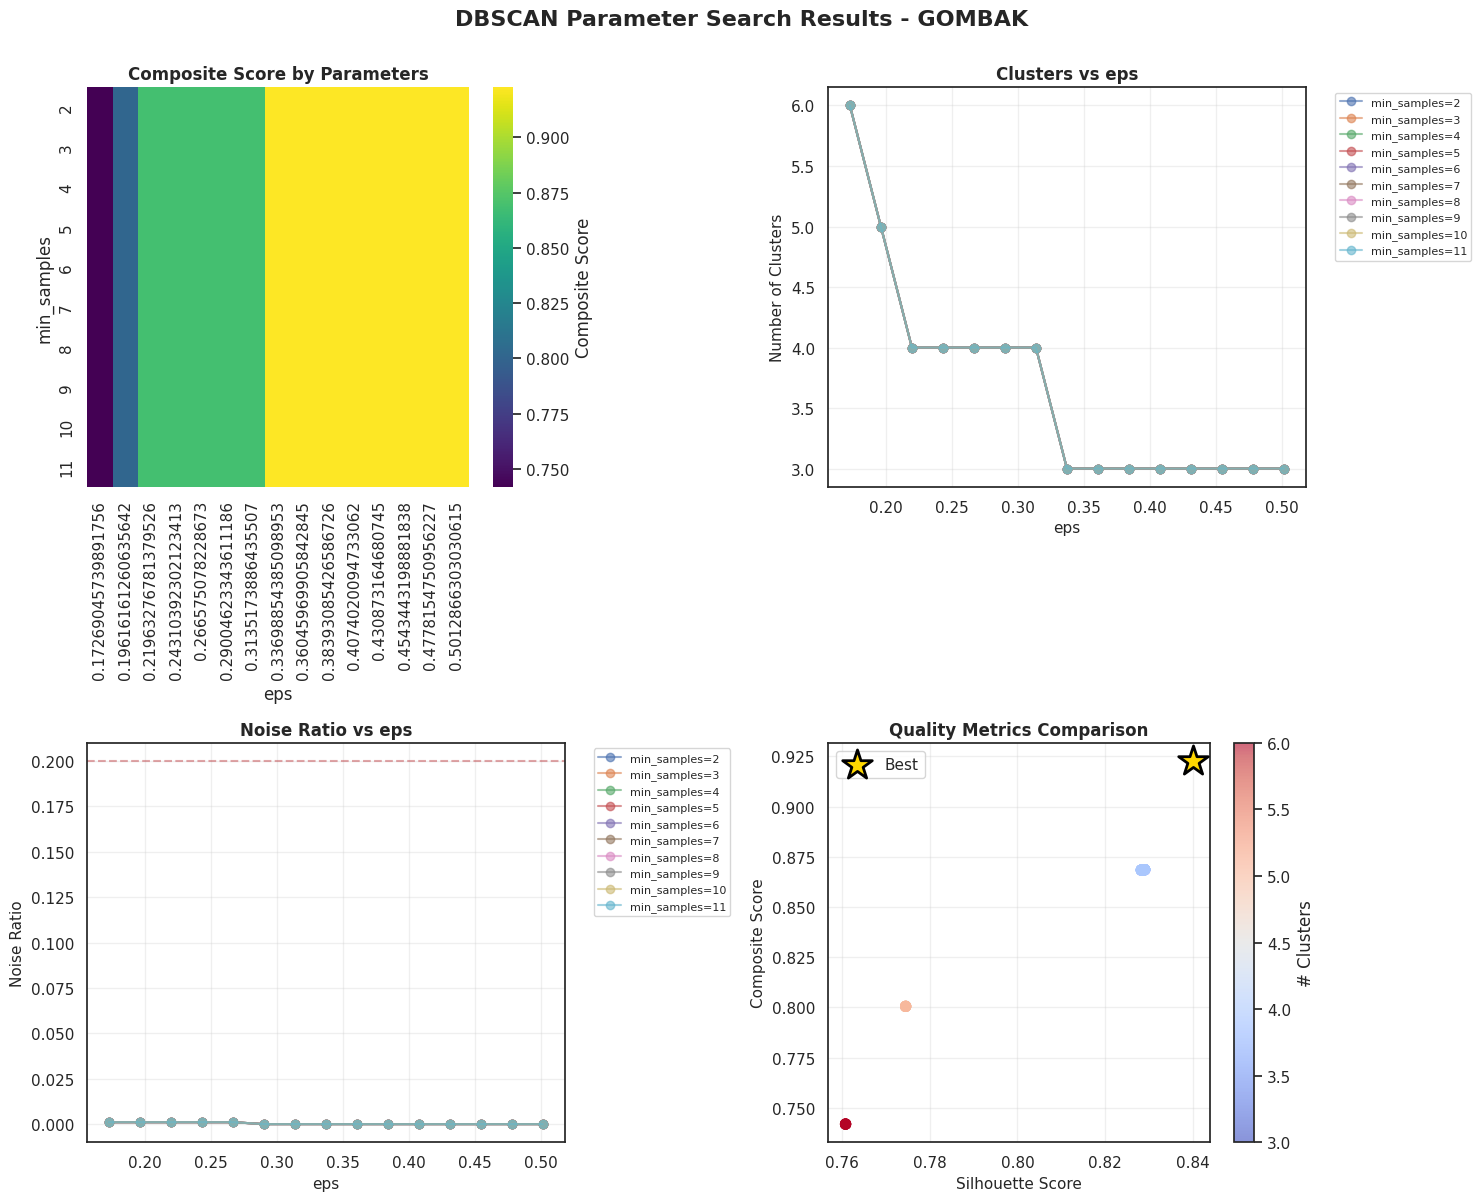

⚠️  gombak: Too few clusters (3 < 6)

Processing: hulu langat
Sample size: 6,773

Optimizing DBSCAN for HULU LANGAT
Sample size: 6,773
Features: ['x_coord', 'y_coord']


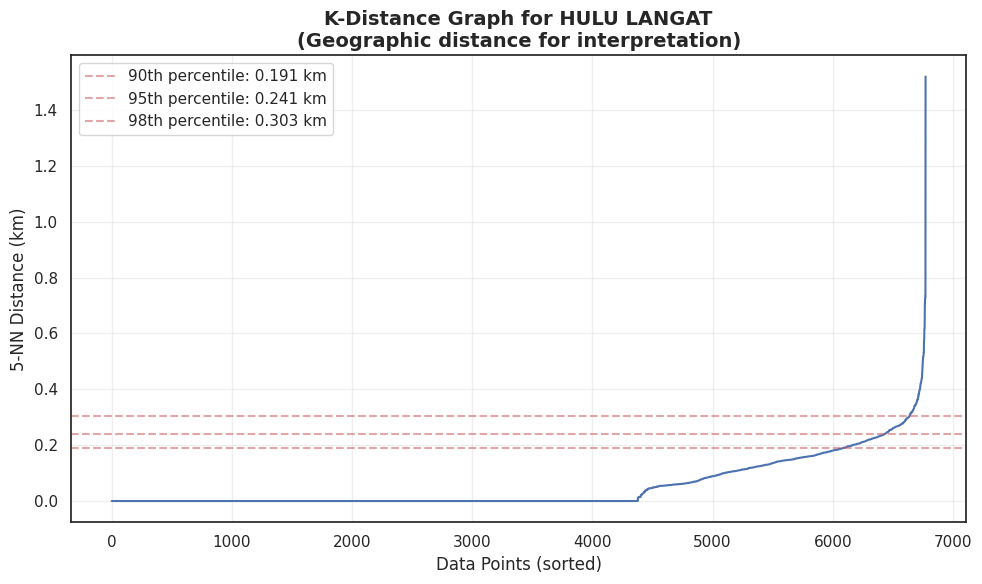


Geographic interpretation (approximate):
  Conservative: 0.0512 (std units) ≈ 0.191 km
  Balanced: 0.0657 (std units) ≈ 0.241 km
  Aggressive: 0.0844 (std units) ≈ 0.303 km

Suggested eps values based on k-distance:
  Conservative: 0.0512
  Balanced: 0.0657
  Aggressive: 0.0844

Target clusters: 8 (range: 4-32)
Searching parameter space:
  eps: 0.1643 to 0.4222 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.164, min_samples=2: clusters=6, noise=0.0%

  eps=0.183, min_samples=2: clusters=4, noise=0.0%

  eps=0.201, min_samples=2: clusters=3, noise=0.0%

  eps=0.220, min_samples=2: clusters=1, noise=0.0%

  eps=0.238, min_samples=2: clusters=1, noise=0.0%

  eps=0.256, min_samples=2: clusters=1, noise=0.0%

  eps=0.275, min_samples=2: clusters=1, noise=0.0%

  eps=0.293, min_samples=2: clusters=1, noise=0.0%

  eps=0.312, min_samples=2: clusters=1, noise=0.0%

  eps=0.330, min_samples=2: clusters=1, noise=0.0%
     → Silhouette: 0.101, DB: 0.823, Cluster_score: 0.500, Composit

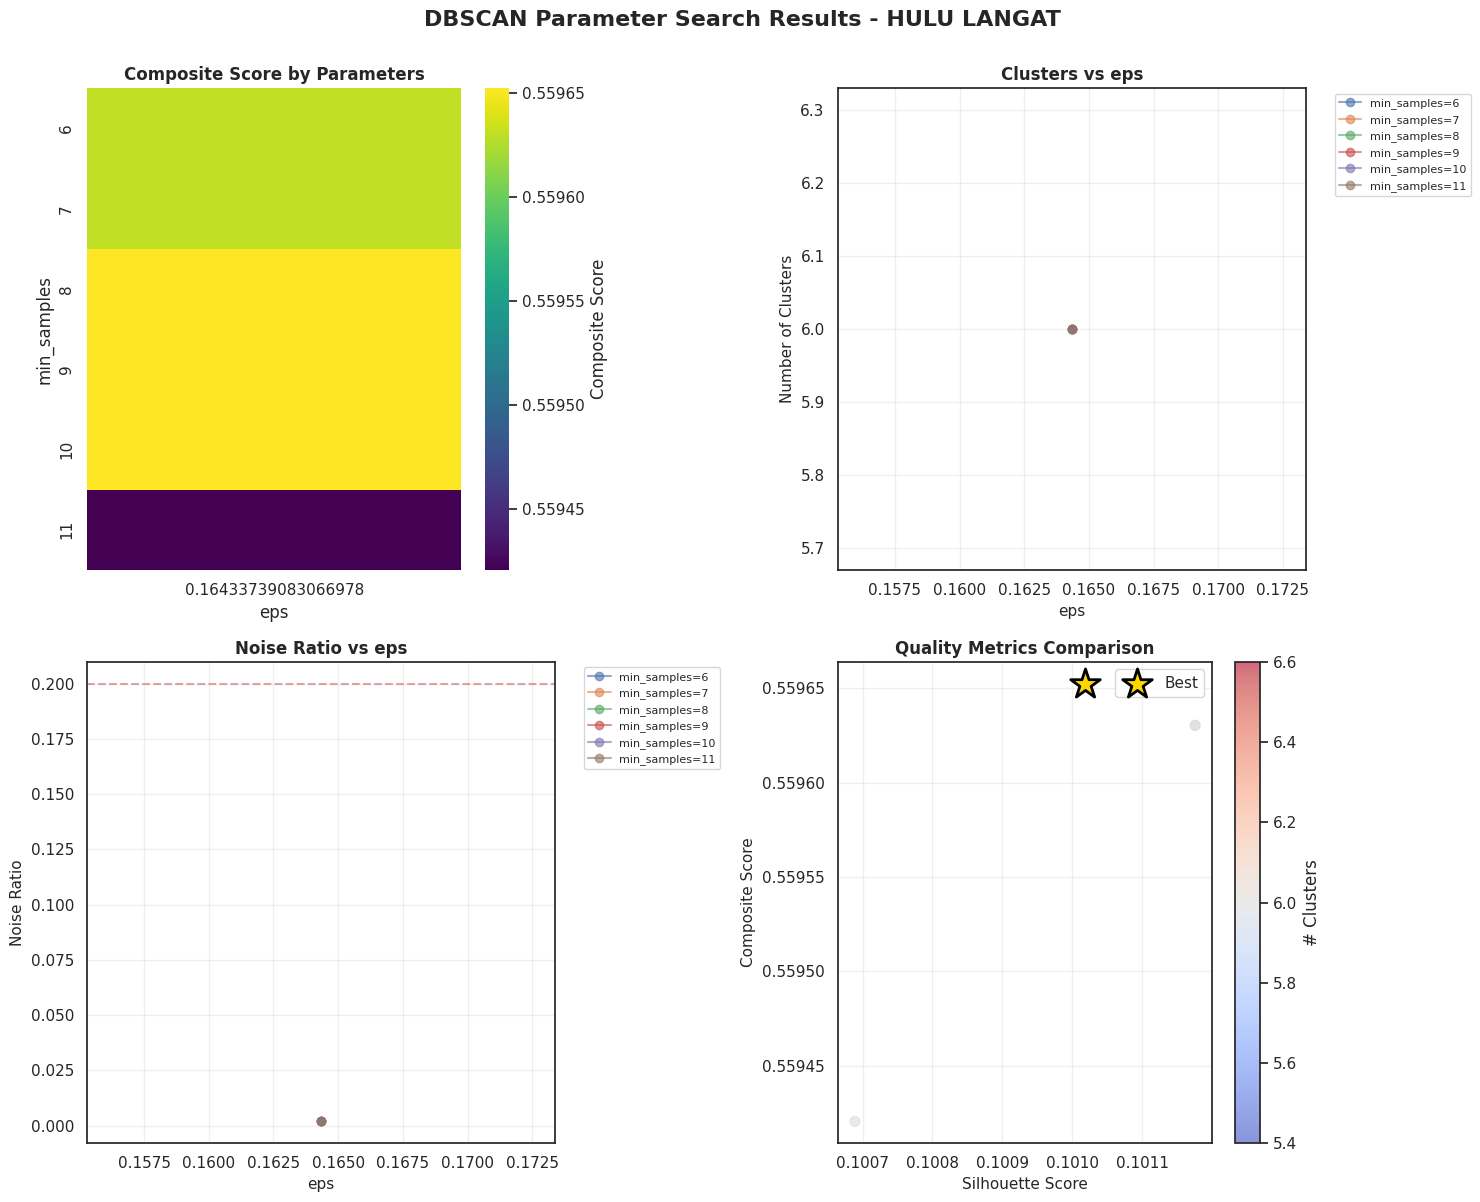

⚠️  hulu langat: Poor silhouette (0.101 < 0.15)

Processing: klang
Sample size: 4,170

Optimizing DBSCAN for KLANG
Sample size: 4,170
Features: ['x_coord', 'y_coord']


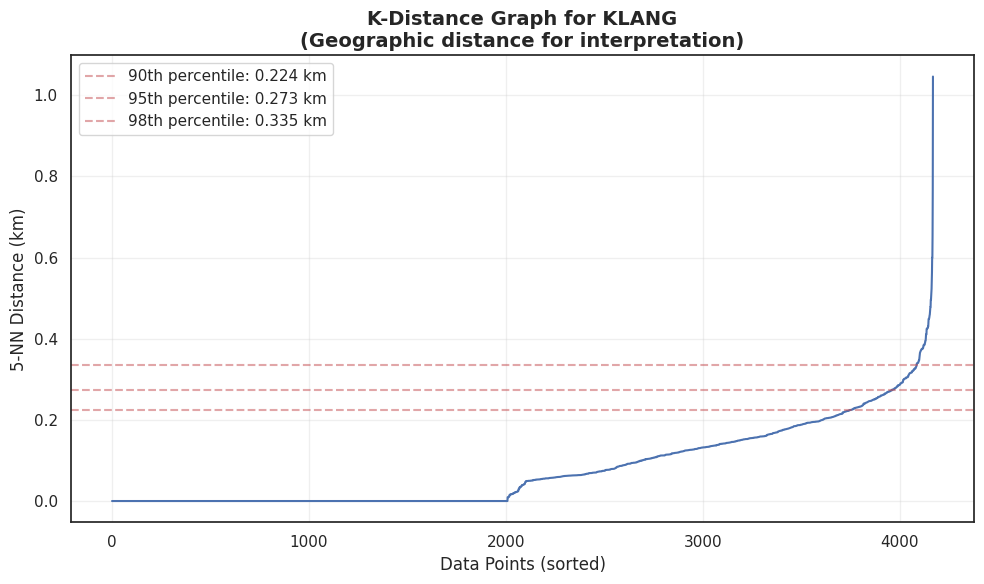


Geographic interpretation (approximate):
  Conservative: 0.0797 (std units) ≈ 0.225 km
  Balanced: 0.0972 (std units) ≈ 0.273 km
  Aggressive: 0.1236 (std units) ≈ 0.337 km

Suggested eps values based on k-distance:
  Conservative: 0.0797
  Balanced: 0.0972
  Aggressive: 0.1236

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.2430 to 0.6182 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.243, min_samples=2: clusters=5, noise=0.0%

  eps=0.270, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.077, DB: 0.545, Cluster_score: 0.600, Composite: 0.514

  eps=0.297, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.077, DB: 0.545, Cluster_score: 0.600, Composite: 0.514

  eps=0.323, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.077, DB: 0.545, Cluster_score: 0.600, Composite: 0.514

  eps=0.350, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.077, DB: 0.545, Cluster_score: 0.600, Composite: 0.514

  eps=0.377, min_sampl

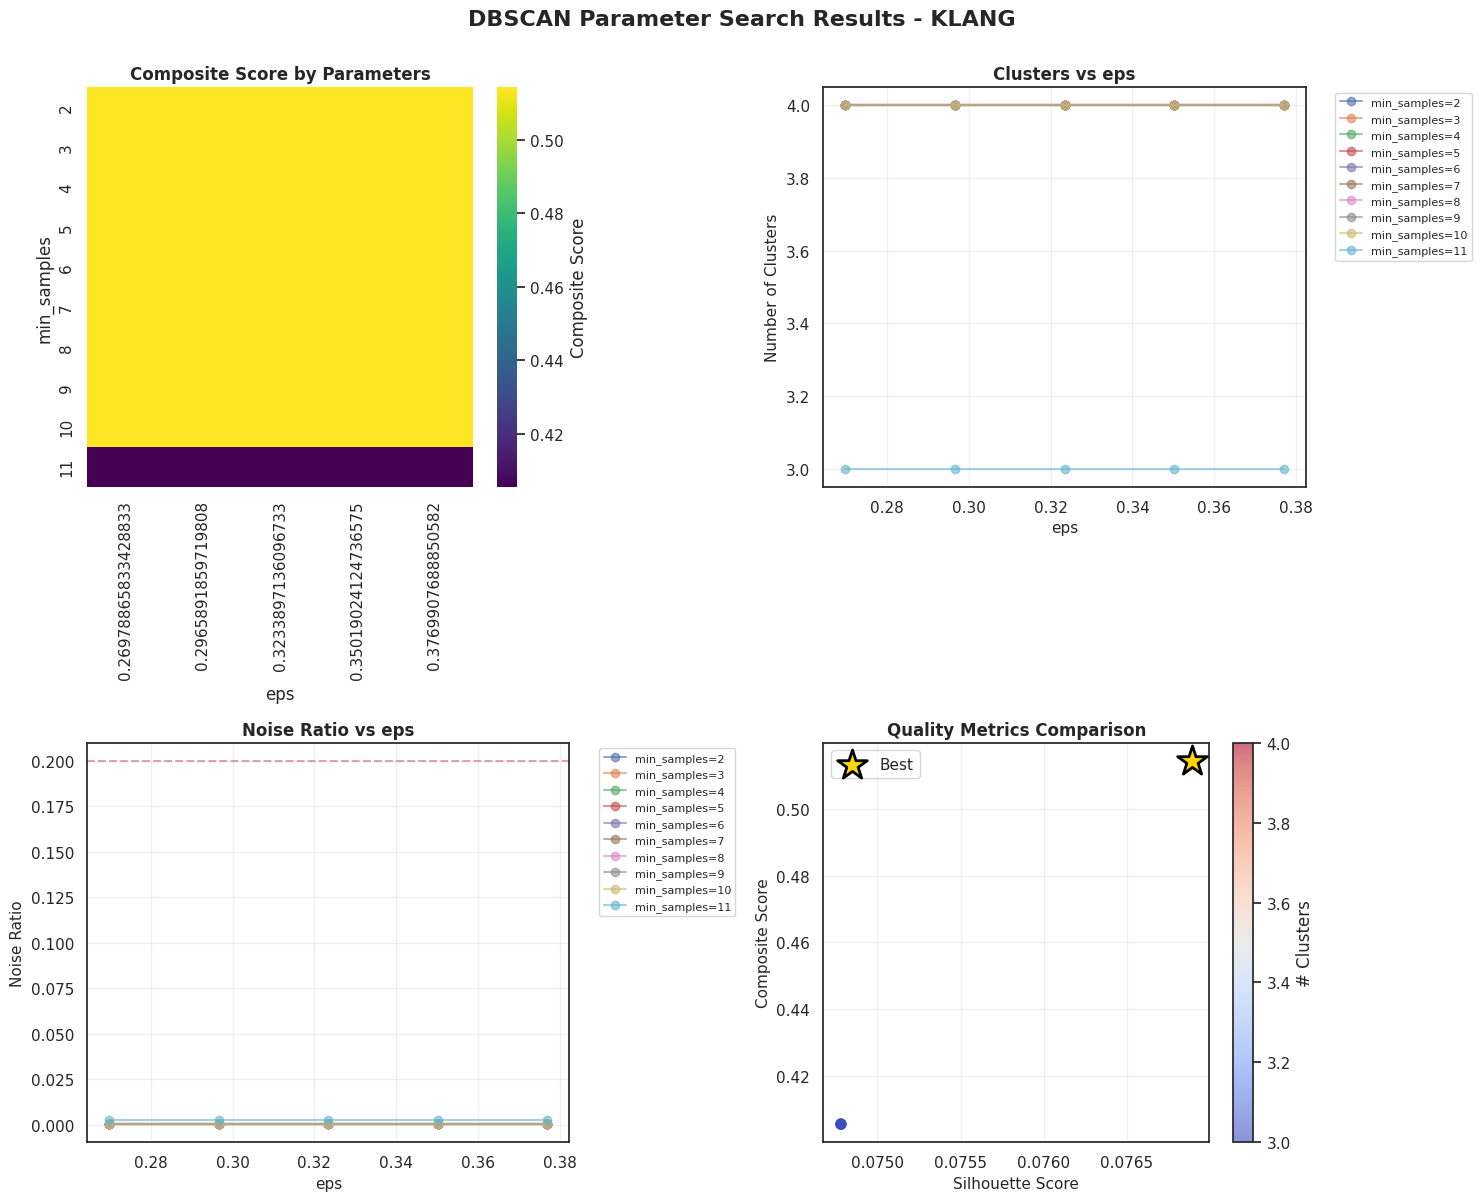

⚠️  klang: Too few clusters (4 < 6)

Processing: kuala lumpur
Sample size: 12,288

Optimizing DBSCAN for KUALA LUMPUR
Sample size: 12,288
Features: ['x_coord', 'y_coord']


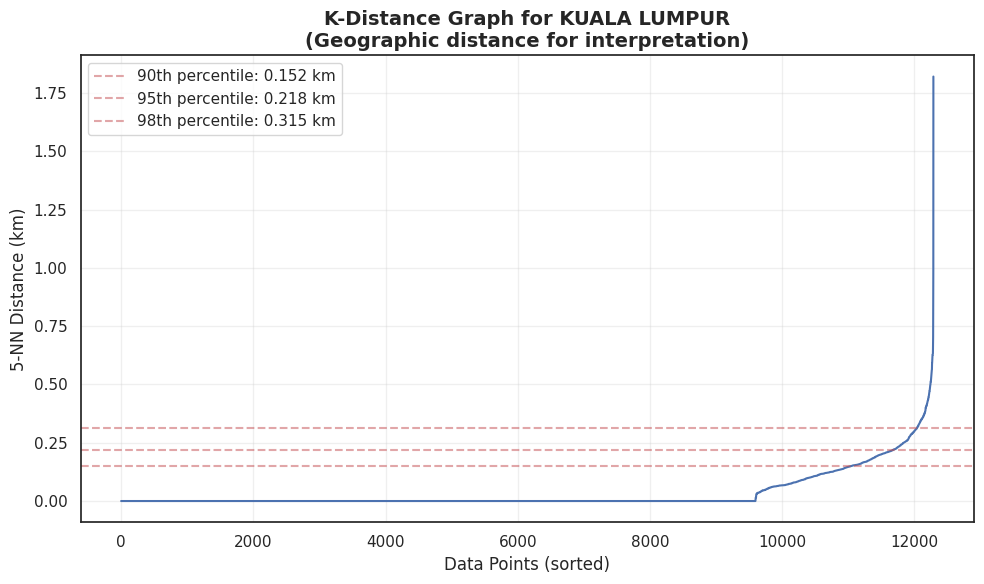


Geographic interpretation (approximate):
  Conservative: 0.0314 (std units) ≈ 0.152 km
  Balanced: 0.0468 (std units) ≈ 0.218 km
  Aggressive: 0.0661 (std units) ≈ 0.315 km

Suggested eps values based on k-distance:
  Conservative: 0.0314
  Balanced: 0.0468
  Aggressive: 0.0661

Target clusters: 12 (range: 6-96)
Searching parameter space:
  eps: 0.1169 to 0.3304 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.117, min_samples=2: clusters=37, noise=0.0%

  eps=0.132, min_samples=2: clusters=16, noise=0.0%

  eps=0.147, min_samples=2: clusters=12, noise=0.0%

  eps=0.163, min_samples=2: clusters=7, noise=0.0%

  eps=0.178, min_samples=2: clusters=4, noise=0.0%

  eps=0.193, min_samples=2: clusters=2, noise=0.0%

  eps=0.208, min_samples=2: clusters=1, noise=0.0%

  eps=0.224, min_samples=2: clusters=1, noise=0.0%

  eps=0.239, min_samples=2: clusters=1, noise=0.0%

  eps=0.254, min_samples=2: clusters=1, noise=0.0%
 Done!

⚠ No suitable parameters found!
No valid combinations f

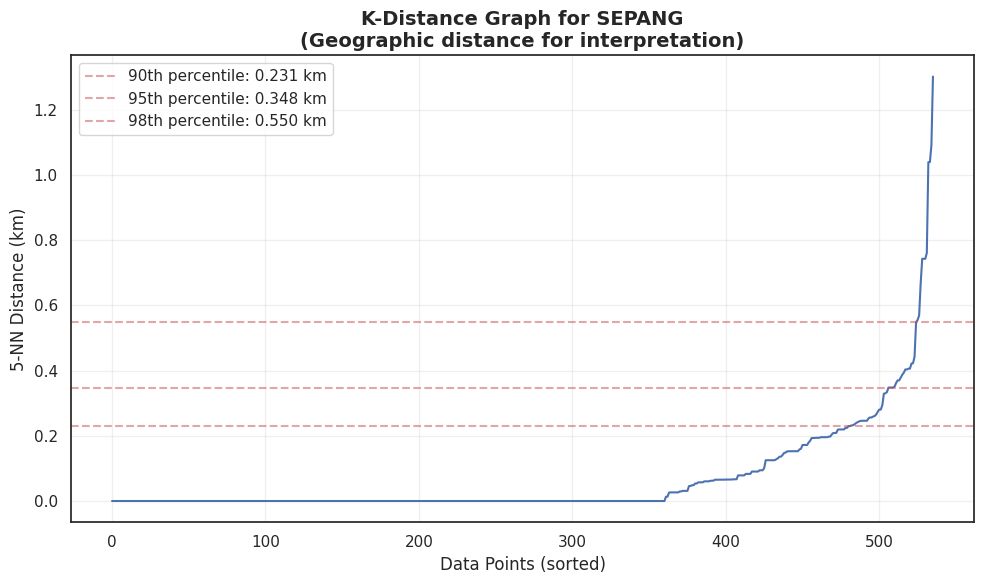


Geographic interpretation (approximate):
  Conservative: 0.0833 (std units) ≈ 0.232 km
  Balanced: 0.1445 (std units) ≈ 0.348 km
  Aggressive: 0.1957 (std units) ≈ 0.555 km

Suggested eps values based on k-distance:
  Conservative: 0.0833
  Balanced: 0.1445
  Aggressive: 0.1957

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 0.3613 to 0.9787 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.361, min_samples=2: clusters=6, noise=0.0%
     → Silhouette: 0.628, DB: 0.390, Cluster_score: 0.500, Composite: 0.714

  eps=0.405, min_samples=2: clusters=6, noise=0.0%
     → Silhouette: 0.628, DB: 0.390, Cluster_score: 0.500, Composite: 0.714

  eps=0.449, min_samples=2: clusters=6, noise=0.0%
     → Silhouette: 0.628, DB: 0.390, Cluster_score: 0.500, Composite: 0.714

  eps=0.494, min_samples=2: clusters=5, noise=0.0%
     → Silhouette: 0.593, DB: 0.408, Cluster_score: 0.667, Composite: 0.754

  eps=0.538, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.59

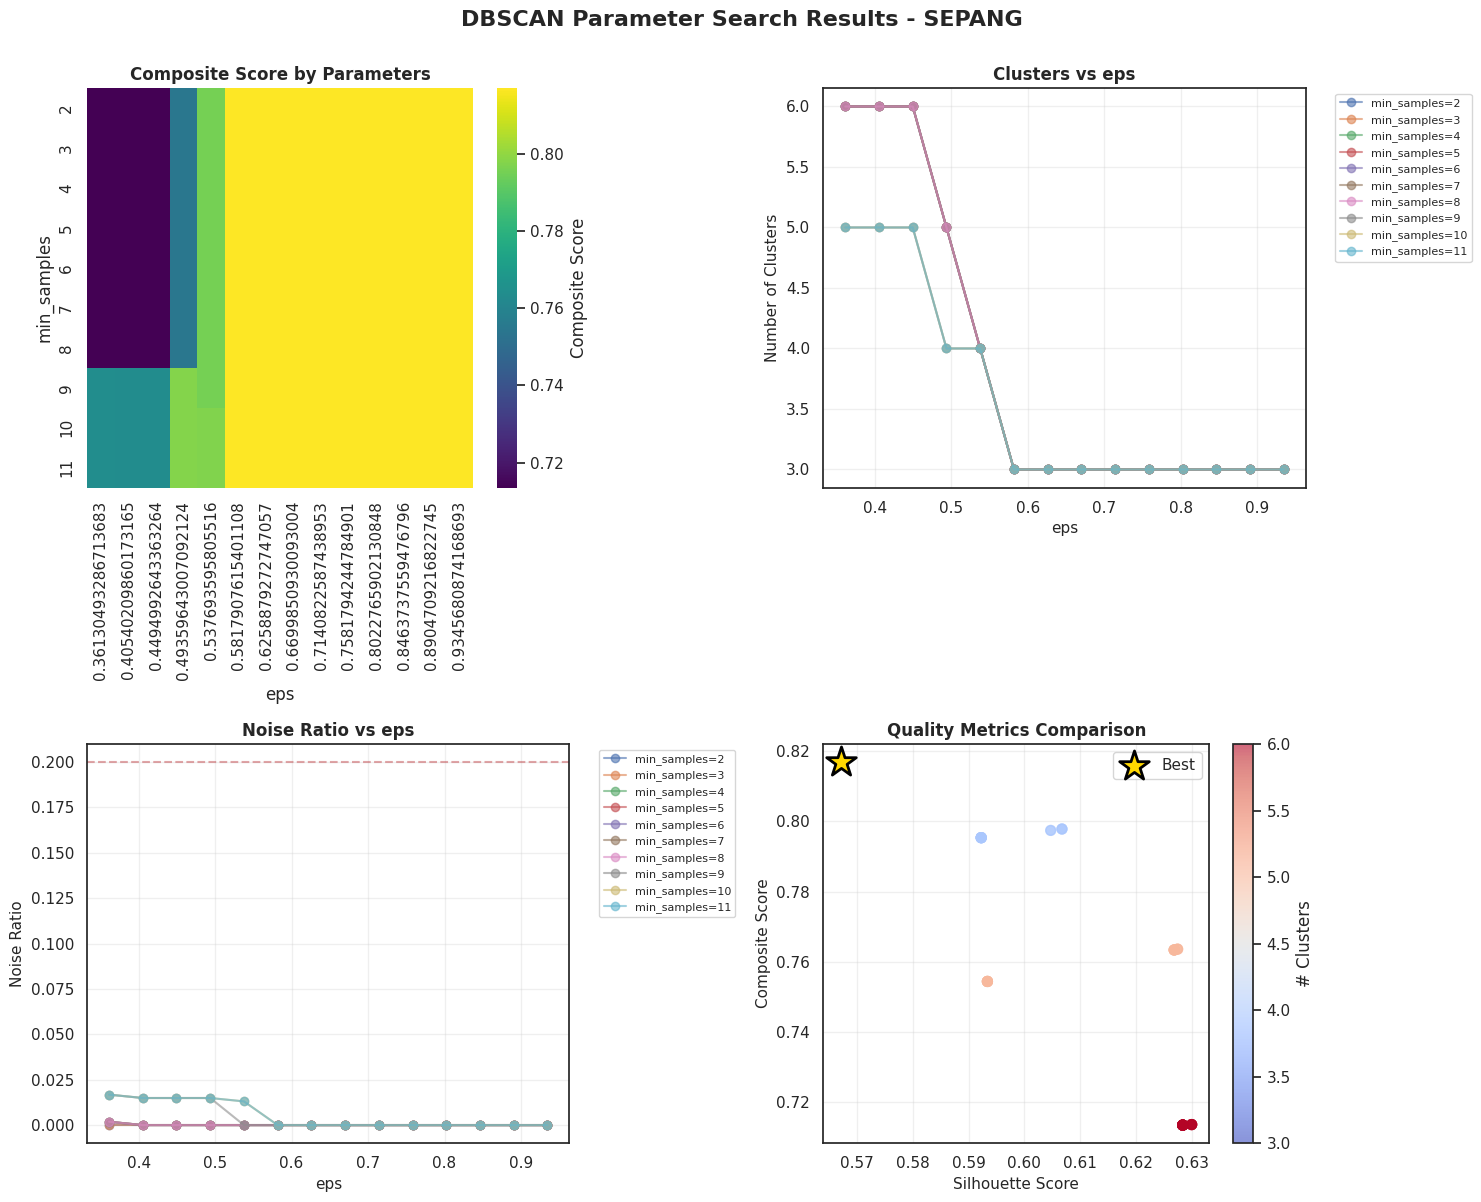

⚠️  sepang: Too few clusters (3 < 6)

Processing: petaling
Sample size: 13,415

Optimizing DBSCAN for PETALING
Sample size: 13,415
Features: ['x_coord', 'y_coord']


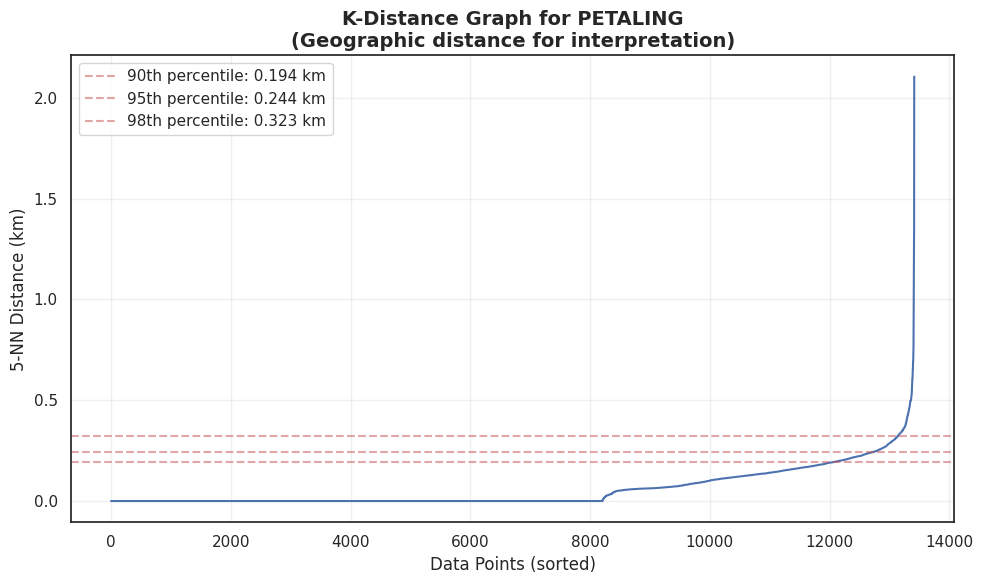


Geographic interpretation (approximate):
  Conservative: 0.0348 (std units) ≈ 0.194 km
  Balanced: 0.0455 (std units) ≈ 0.244 km
  Aggressive: 0.0590 (std units) ≈ 0.323 km

Suggested eps values based on k-distance:
  Conservative: 0.0348
  Balanced: 0.0455
  Aggressive: 0.0590

Target clusters: 12 (range: 6-96)
Searching parameter space:
  eps: 0.1138 to 0.2948 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.114, min_samples=2: clusters=28, noise=0.0%

  eps=0.127, min_samples=2: clusters=21, noise=0.0%

  eps=0.140, min_samples=2: clusters=17, noise=0.0%

  eps=0.153, min_samples=2: clusters=14, noise=0.0%

  eps=0.165, min_samples=2: clusters=12, noise=0.0%

  eps=0.178, min_samples=2: clusters=9, noise=0.0%

  eps=0.191, min_samples=2: clusters=9, noise=0.0%

  eps=0.204, min_samples=2: clusters=6, noise=0.0%

  eps=0.217, min_samples=2: clusters=6, noise=0.0%

  eps=0.230, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.095, DB: 0.554, Cluster_score: 0.000, Co

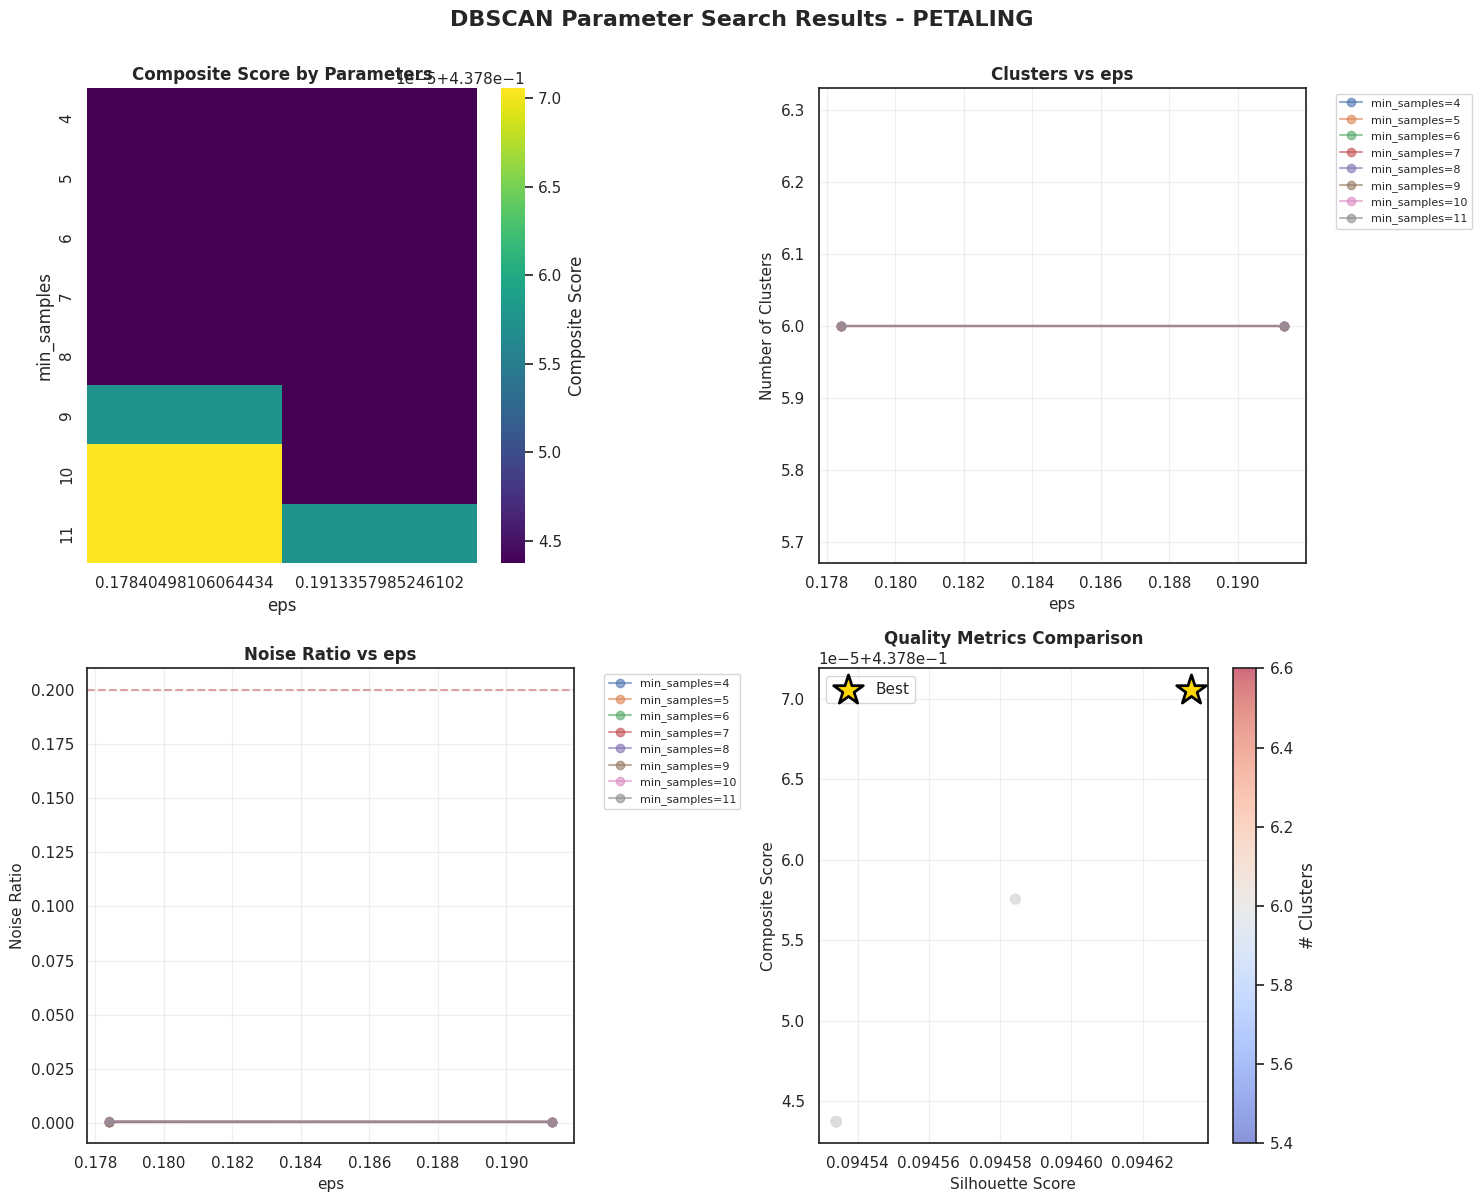

⚠️  petaling: Poor silhouette (0.095 < 0.15)

Processing: putrajaya
Sample size: 138

Optimizing DBSCAN for PUTRAJAYA
Sample size: 138
Features: ['x_coord', 'y_coord']


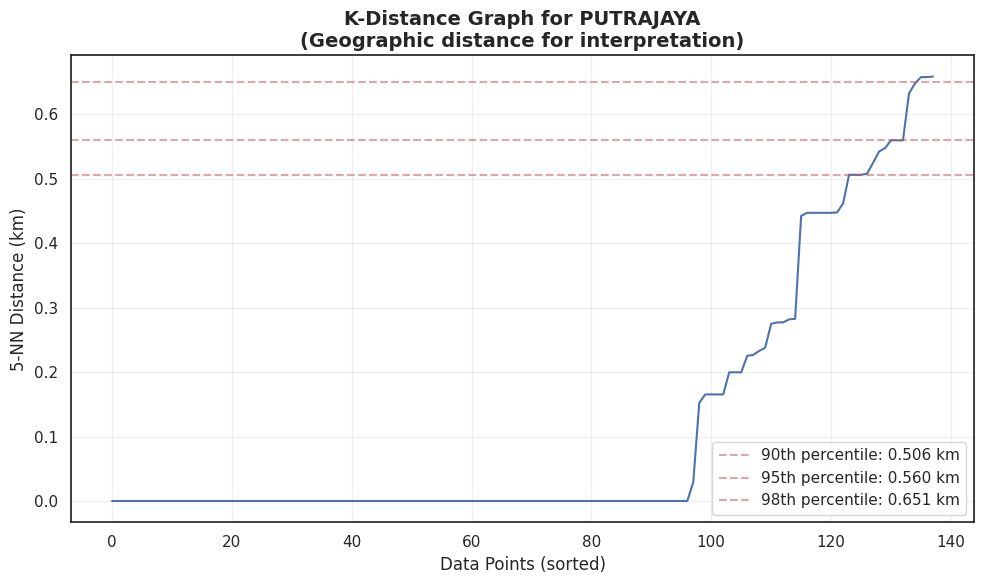


Geographic interpretation (approximate):
  Conservative: 0.4930 (std units) ≈ 0.506 km
  Balanced: 0.5238 (std units) ≈ 0.560 km
  Aggressive: 0.6055 (std units) ≈ 0.658 km

Suggested eps values based on k-distance:
  Conservative: 0.4930
  Balanced: 0.5238
  Aggressive: 0.6055

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 1.3096 to 3.0276 (15 values)
  min_samples: 2 to 11

Searching...
  eps=1.310, min_samples=2: clusters=3, noise=0.0%
     → Silhouette: 0.631, DB: 0.401, Cluster_score: 1.000, Composite: 0.764

  eps=1.432, min_samples=2: clusters=3, noise=0.0%
     → Silhouette: 0.631, DB: 0.401, Cluster_score: 1.000, Composite: 0.764

  eps=1.555, min_samples=2: clusters=3, noise=0.0%
     → Silhouette: 0.631, DB: 0.401, Cluster_score: 1.000, Composite: 0.764

  eps=1.678, min_samples=2: clusters=1, noise=0.0%

  eps=1.800, min_samples=2: clusters=1, noise=0.0%

  eps=1.923, min_samples=2: clusters=1, noise=0.0%

  eps=2.046, min_samples=2: clusters=1, noise=

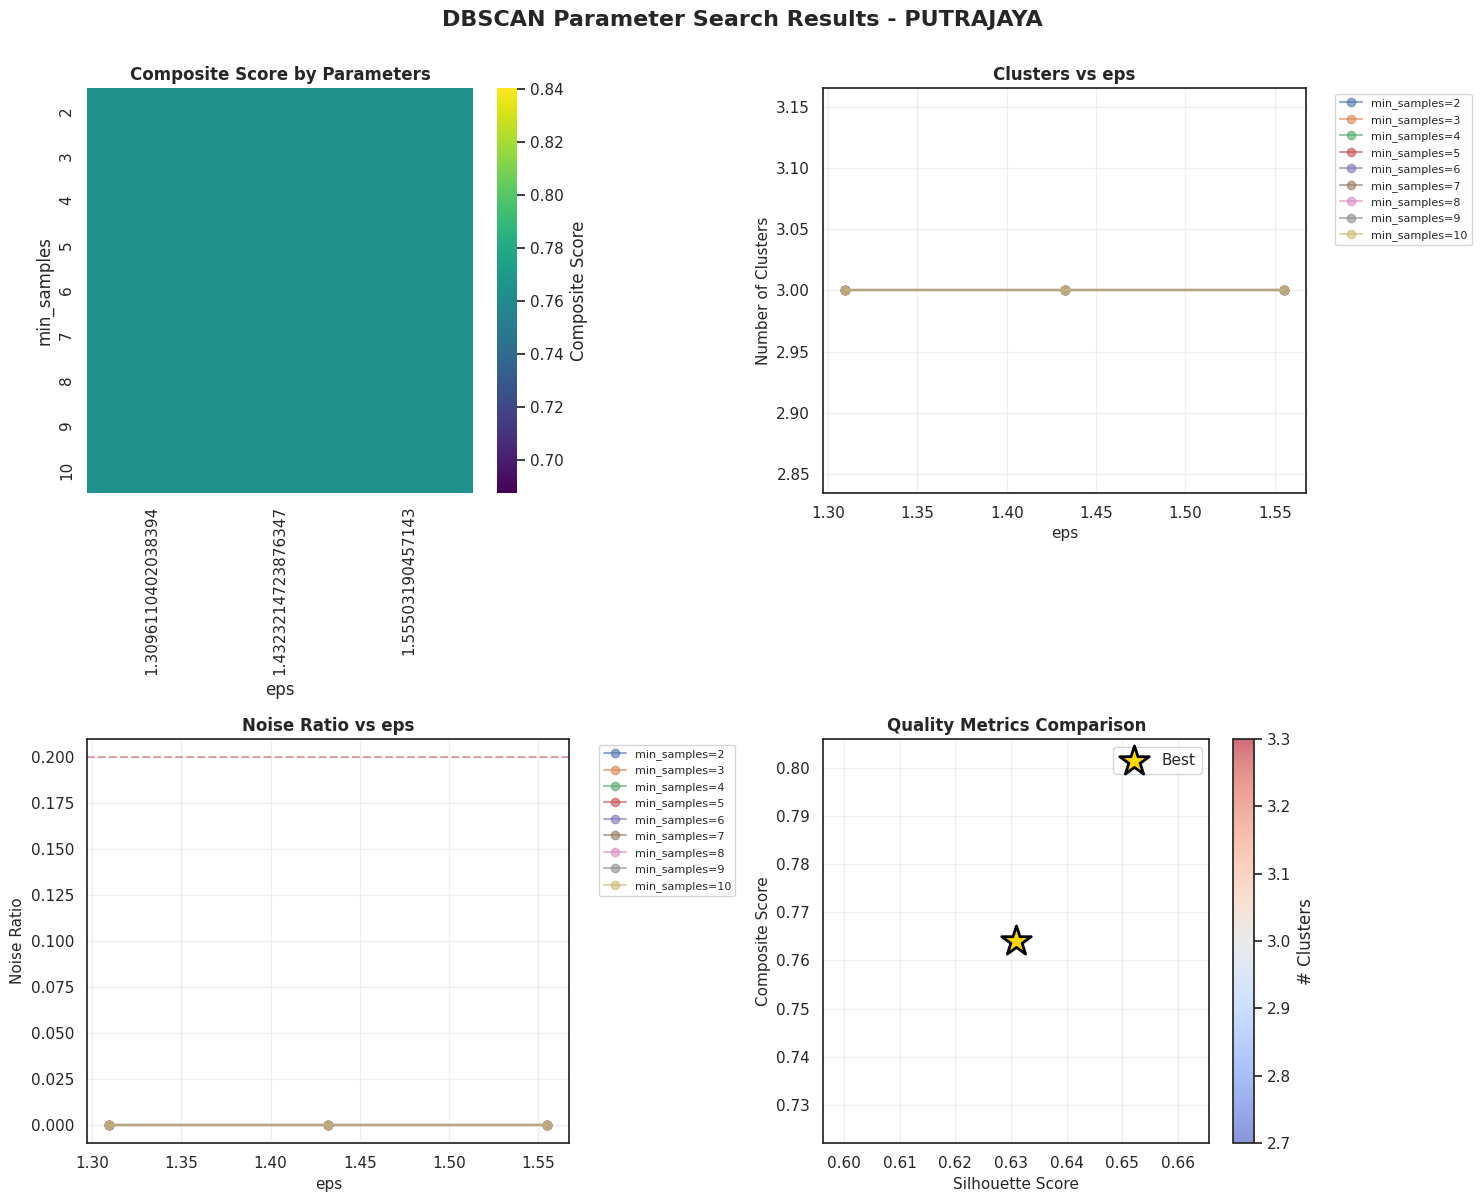

⚠️  putrajaya: Too few clusters (3 < 6)

⚠️  Skipping sabak bernam: insufficient data (1 < 50)

PHASE 2: K-MEANS FALLBACK FOR FAILED DISTRICTS
Districts needing K-Means: 7
  - gombak: 939 properties
  - hulu langat: 6,773 properties
  - klang: 4,170 properties
  - kuala lumpur: 12,288 properties
  - sepang: 536 properties
  - petaling: 13,415 properties
  - putrajaya: 138 properties

K-Means for gombak
Sample size: 939
Target clusters: 12

Using K-Means for gombak (dense urban area)
Sample size: 939

Testing K values from 7 to 20...
  K=7: Silhouette=0.642
  K=8: Silhouette=0.666
  K=9: Silhouette=0.664
  K=10: Silhouette=0.673
  K=11: Silhouette=0.640
  K=12: Silhouette=0.643
  K=13: Silhouette=0.633
  K=14: Silhouette=0.629
  K=15: Silhouette=0.602

✓ Best K-Means result:
  Number of clusters: 10
  Silhouette score: 0.673
  Noise points: 0 (K-Means assigns all points)
✅ gombak: K-Means successful
   Clusters: 10, Silhouette: 0.673

K-Means for hulu langat
Sample size: 6,773
Target cl

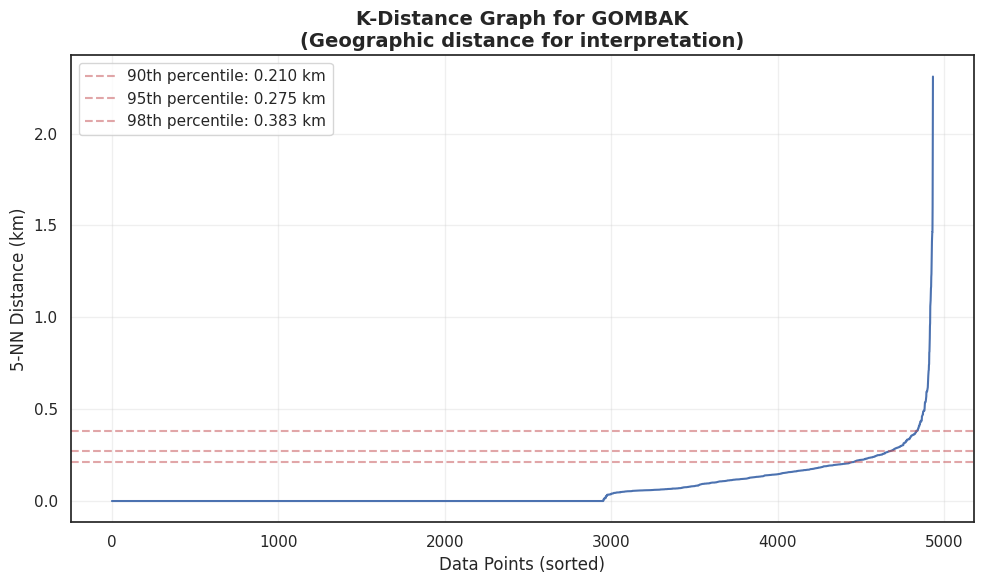


Geographic interpretation (approximate):
  Conservative: 0.0314 (std units) ≈ 0.210 km
  Balanced: 0.0408 (std units) ≈ 0.275 km
  Aggressive: 0.0545 (std units) ≈ 0.383 km

Suggested eps values based on k-distance:
  Conservative: 0.0314
  Balanced: 0.0408
  Aggressive: 0.0545

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1021 to 0.2727 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.102, min_samples=2: clusters=25, noise=0.1%

  eps=0.114, min_samples=2: clusters=23, noise=0.1%

  eps=0.126, min_samples=2: clusters=21, noise=0.1%

  eps=0.139, min_samples=2: clusters=19, noise=0.1%
     → Silhouette: 0.331, DB: 0.540, Cluster_score: 0.000, Composite: 0.512

  eps=0.151, min_samples=2: clusters=16, noise=0.1%
     → Silhouette: 0.368, DB: 0.494, Cluster_score: 0.000, Composite: 0.526

  eps=0.163, min_samples=2: clusters=13, noise=0.1%
     → Silhouette: 0.397, DB: 0.545, Cluster_score: 0.200, Composite: 0.579

  eps=0.175, min_samples=2: clusters=11,

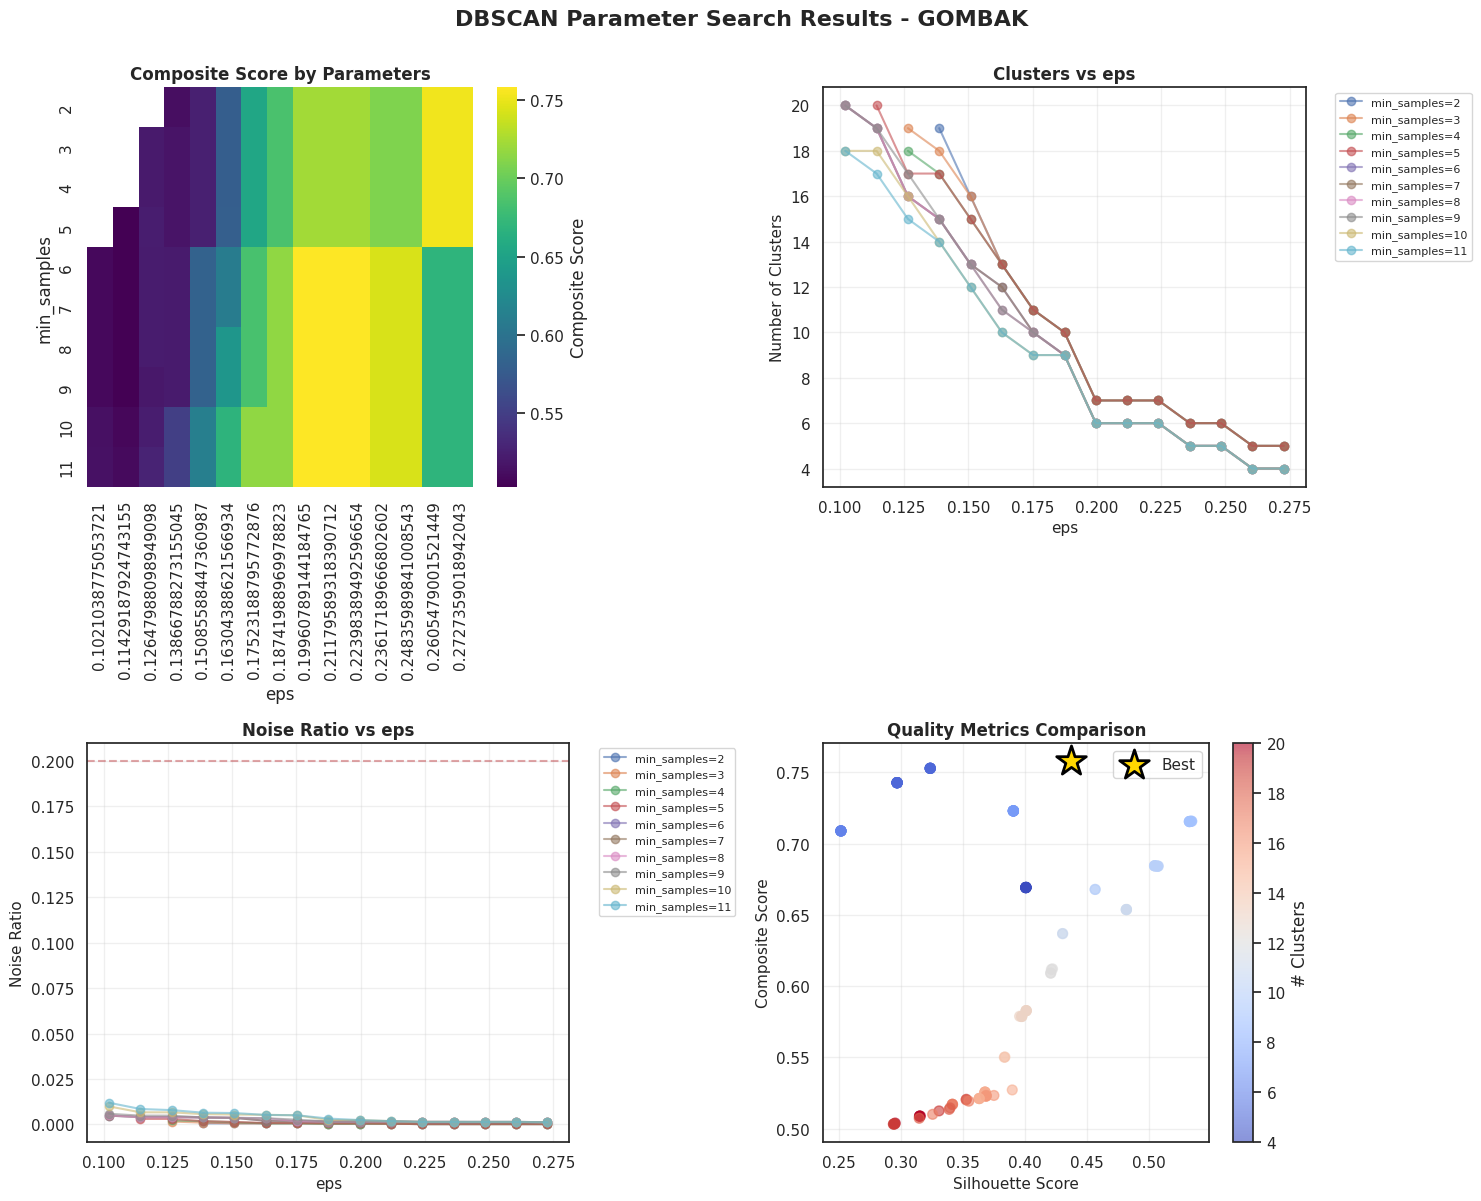

✅ gombak: DBSCAN successful
   Clusters: 6, Silhouette: 0.437

Processing: hulu langat
Sample size: 4,251

Optimizing DBSCAN for HULU LANGAT
Sample size: 4,251
Features: ['x_coord', 'y_coord']


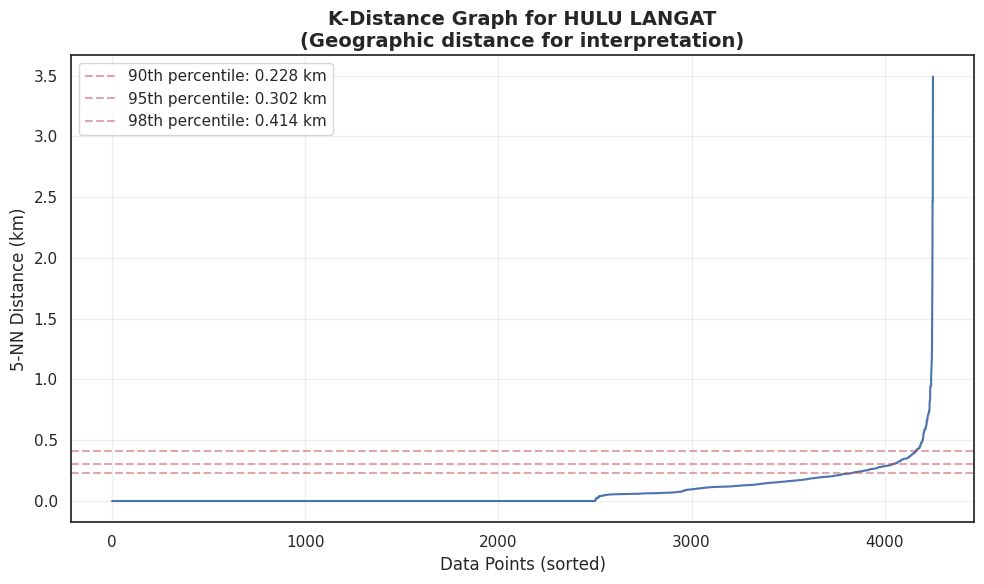


Geographic interpretation (approximate):
  Conservative: 0.0336 (std units) ≈ 0.228 km
  Balanced: 0.0456 (std units) ≈ 0.302 km
  Aggressive: 0.0651 (std units) ≈ 0.414 km

Suggested eps values based on k-distance:
  Conservative: 0.0336
  Balanced: 0.0456
  Aggressive: 0.0651

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1139 to 0.3255 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.114, min_samples=2: clusters=27, noise=0.1%

  eps=0.129, min_samples=2: clusters=21, noise=0.0%

  eps=0.144, min_samples=2: clusters=16, noise=0.0%

  eps=0.159, min_samples=2: clusters=14, noise=0.0%
     → Silhouette: 0.067, DB: 0.681, Cluster_score: 0.100, Composite: 0.461

  eps=0.174, min_samples=2: clusters=11, noise=0.0%

  eps=0.189, min_samples=2: clusters=9, noise=0.0%

  eps=0.205, min_samples=2: clusters=7, noise=0.0%
     → Silhouette: 0.173, DB: 0.645, Cluster_score: 0.800, Composite: 0.622

  eps=0.220, min_samples=2: clusters=7, noise=0.0%
     → Silhoue

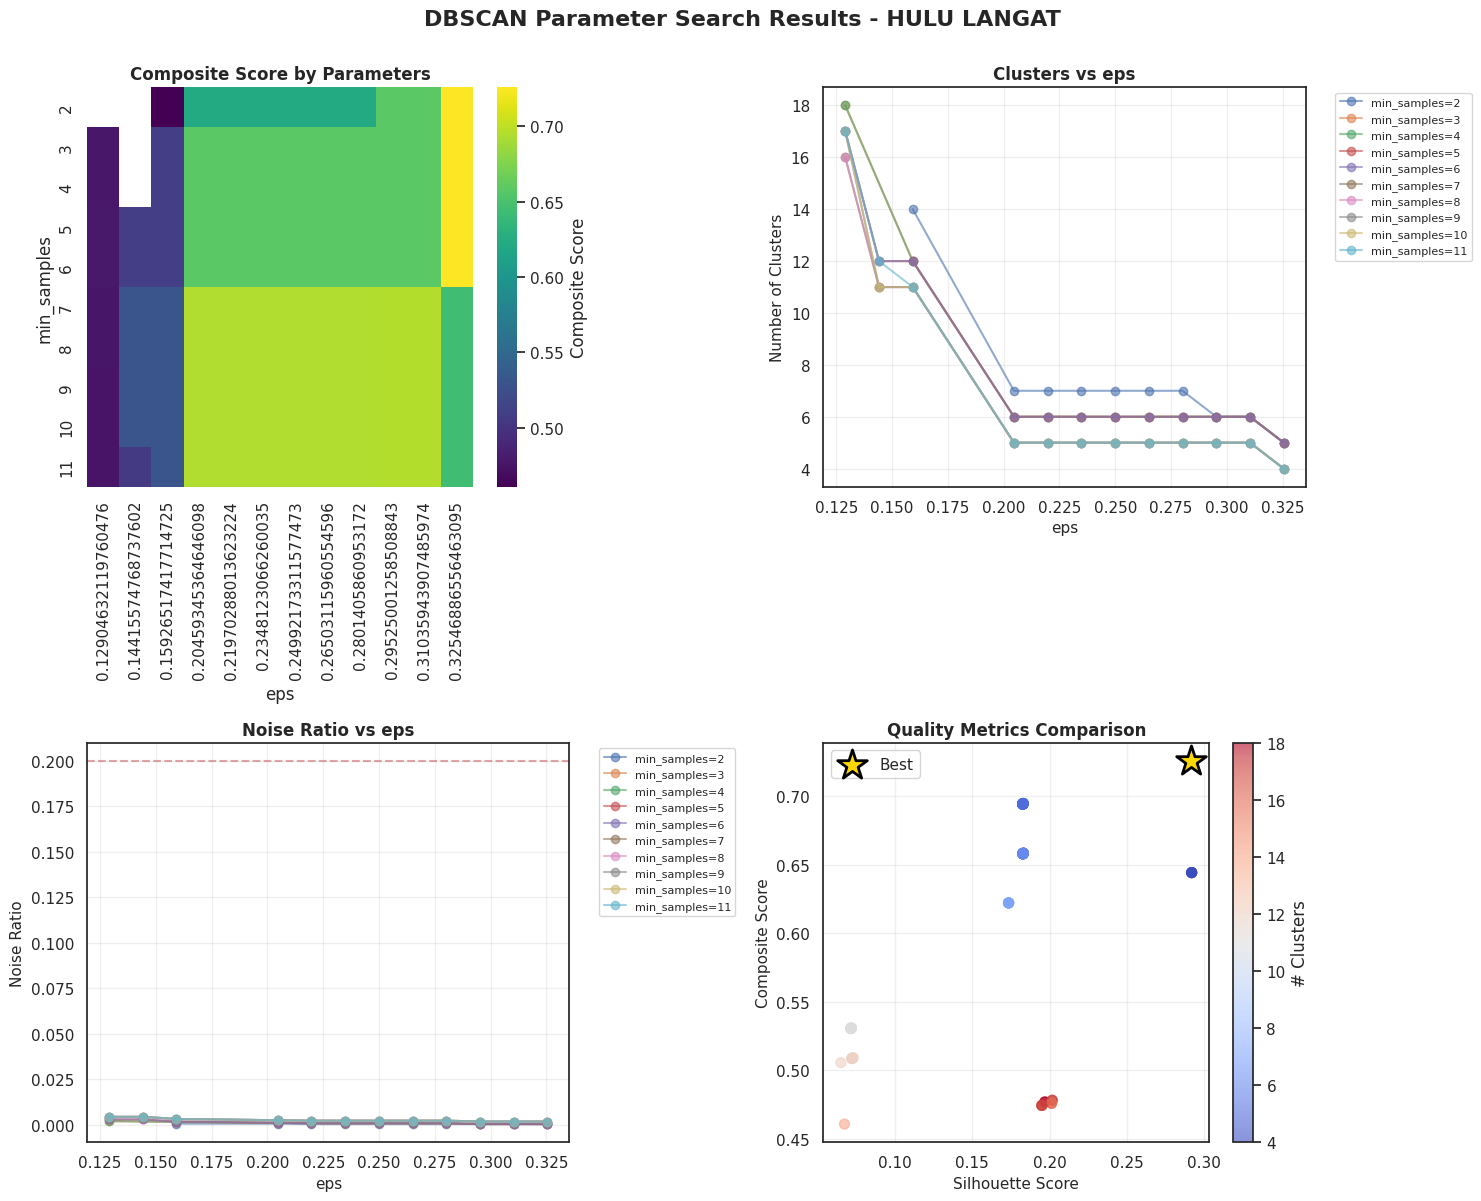

⚠️  hulu langat: Too few clusters (5 < 6)

Processing: hulu selangor
Sample size: 2,852

Optimizing DBSCAN for HULU SELANGOR
Sample size: 2,852
Features: ['x_coord', 'y_coord']


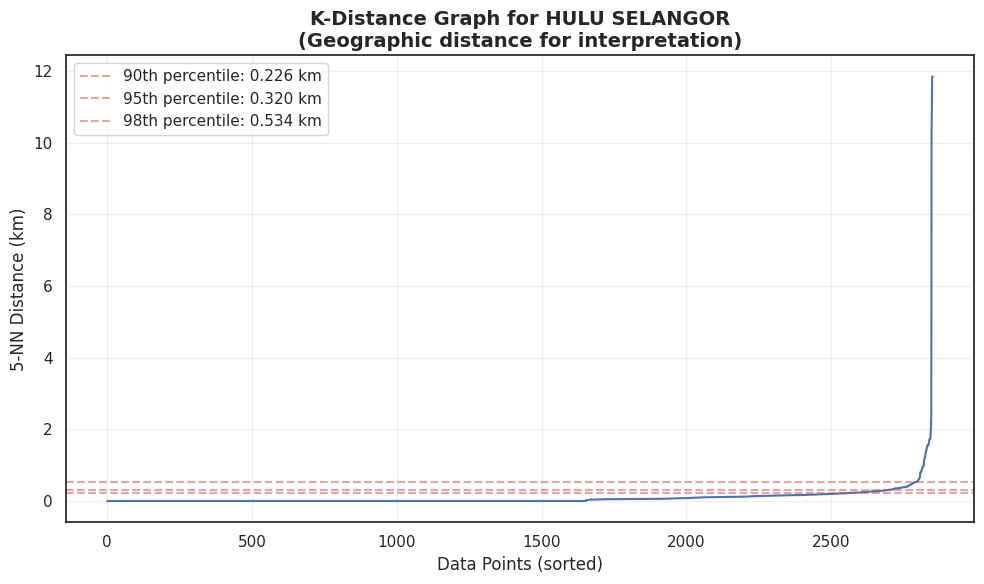


Geographic interpretation (approximate):
  Conservative: 0.0367 (std units) ≈ 0.226 km
  Balanced: 0.0576 (std units) ≈ 0.320 km
  Aggressive: 0.0953 (std units) ≈ 0.534 km

Suggested eps values based on k-distance:
  Conservative: 0.0367
  Balanced: 0.0576
  Aggressive: 0.0953

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1439 to 0.4763 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.144, min_samples=2: clusters=29, noise=0.3%

  eps=0.168, min_samples=2: clusters=26, noise=0.2%

  eps=0.191, min_samples=2: clusters=22, noise=0.1%

  eps=0.215, min_samples=2: clusters=17, noise=0.1%
     → Silhouette: 0.491, DB: 0.354, Cluster_score: 0.000, Composite: 0.570

  eps=0.239, min_samples=2: clusters=15, noise=0.1%
     → Silhouette: 0.475, DB: 0.355, Cluster_score: 0.000, Composite: 0.566

  eps=0.263, min_samples=2: clusters=13, noise=0.1%
     → Silhouette: 0.332, DB: 0.409, Cluster_score: 0.200, Composite: 0.575

  eps=0.286, min_samples=2: clusters=10,

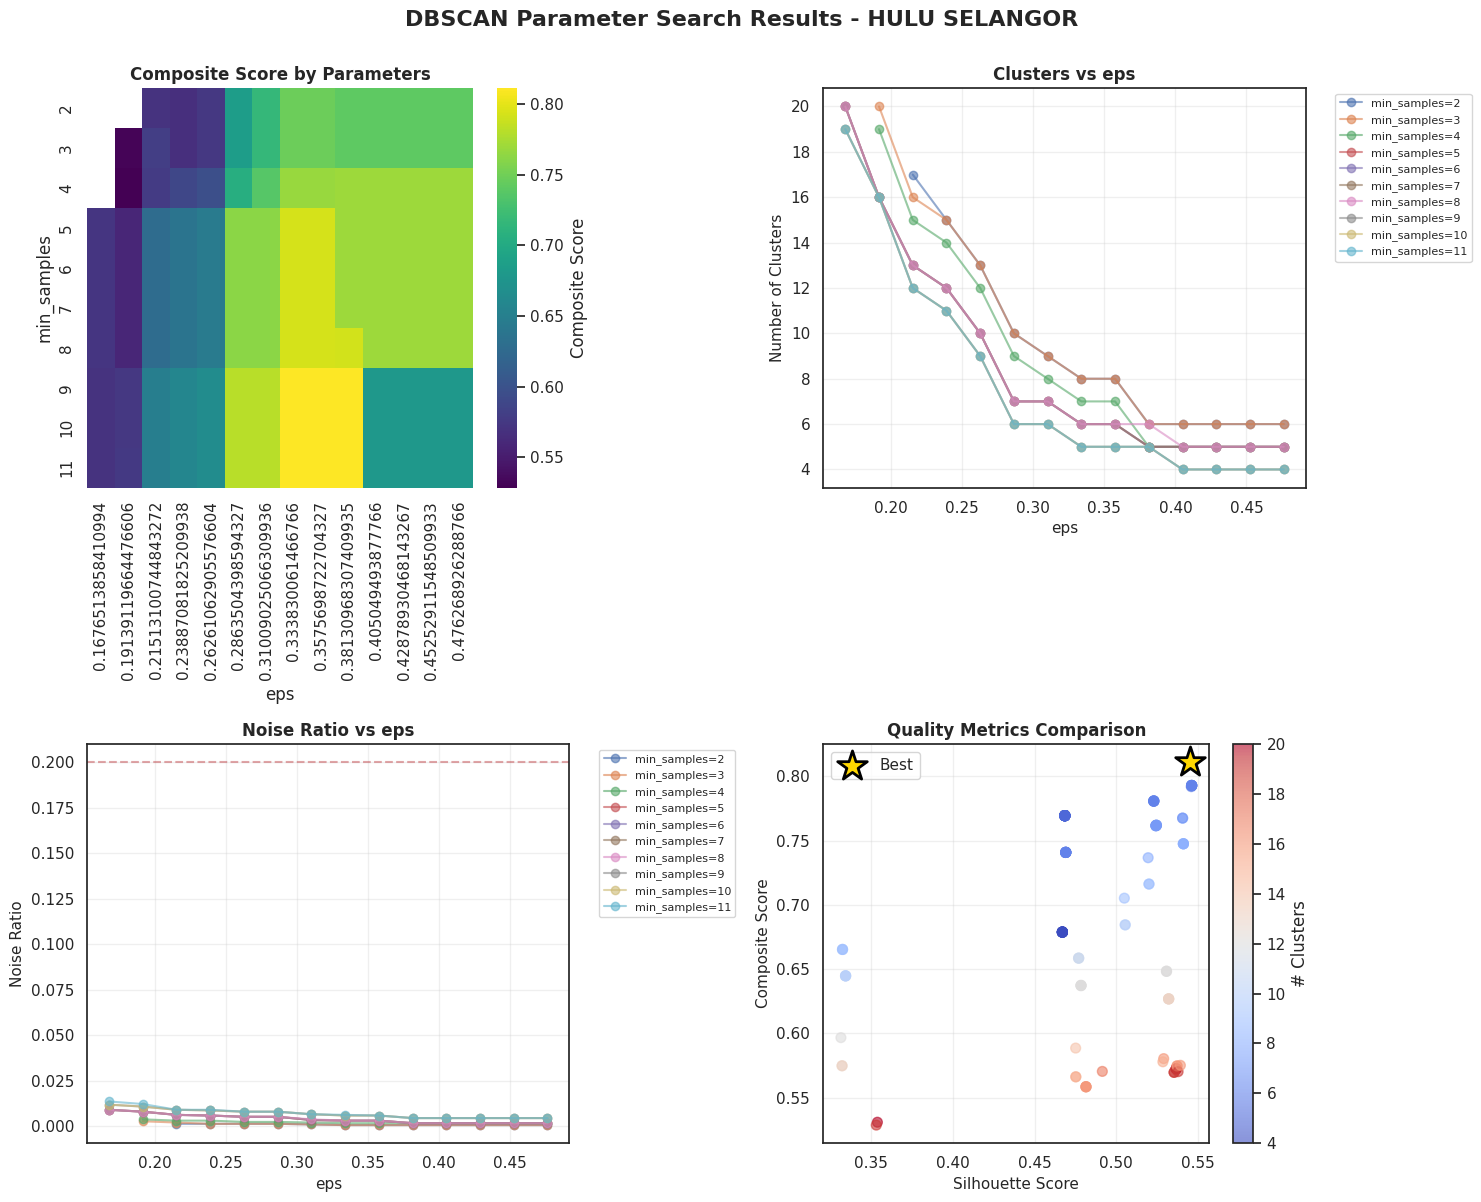

⚠️  hulu selangor: Too few clusters (5 < 6)

Processing: klang
Sample size: 4,951

Optimizing DBSCAN for KLANG
Sample size: 4,951
Features: ['x_coord', 'y_coord']


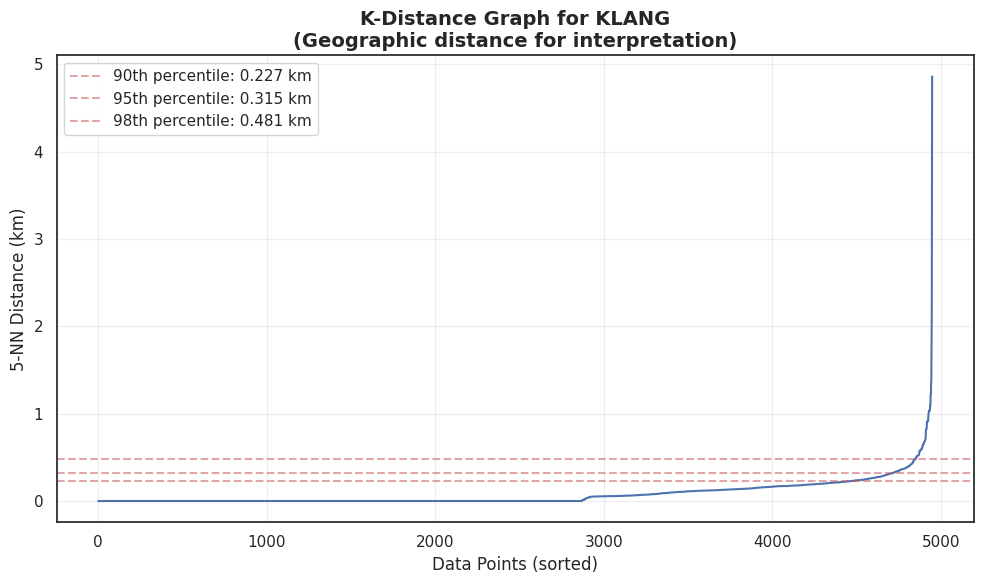


Geographic interpretation (approximate):
  Conservative: 0.0292 (std units) ≈ 0.227 km
  Balanced: 0.0407 (std units) ≈ 0.315 km
  Aggressive: 0.0626 (std units) ≈ 0.481 km

Suggested eps values based on k-distance:
  Conservative: 0.0292
  Balanced: 0.0407
  Aggressive: 0.0626

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1018 to 0.3132 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.102, min_samples=2: clusters=32, noise=0.2%

  eps=0.117, min_samples=2: clusters=27, noise=0.1%

  eps=0.132, min_samples=2: clusters=23, noise=0.1%

  eps=0.147, min_samples=2: clusters=17, noise=0.1%
     → Silhouette: 0.307, DB: 0.500, Cluster_score: 0.000, Composite: 0.510

  eps=0.162, min_samples=2: clusters=15, noise=0.1%
     → Silhouette: 0.480, DB: 0.502, Cluster_score: 0.000, Composite: 0.553

  eps=0.177, min_samples=2: clusters=11, noise=0.1%
     → Silhouette: 0.376, DB: 0.496, Cluster_score: 0.400, Composite: 0.628

  eps=0.192, min_samples=2: clusters=11,

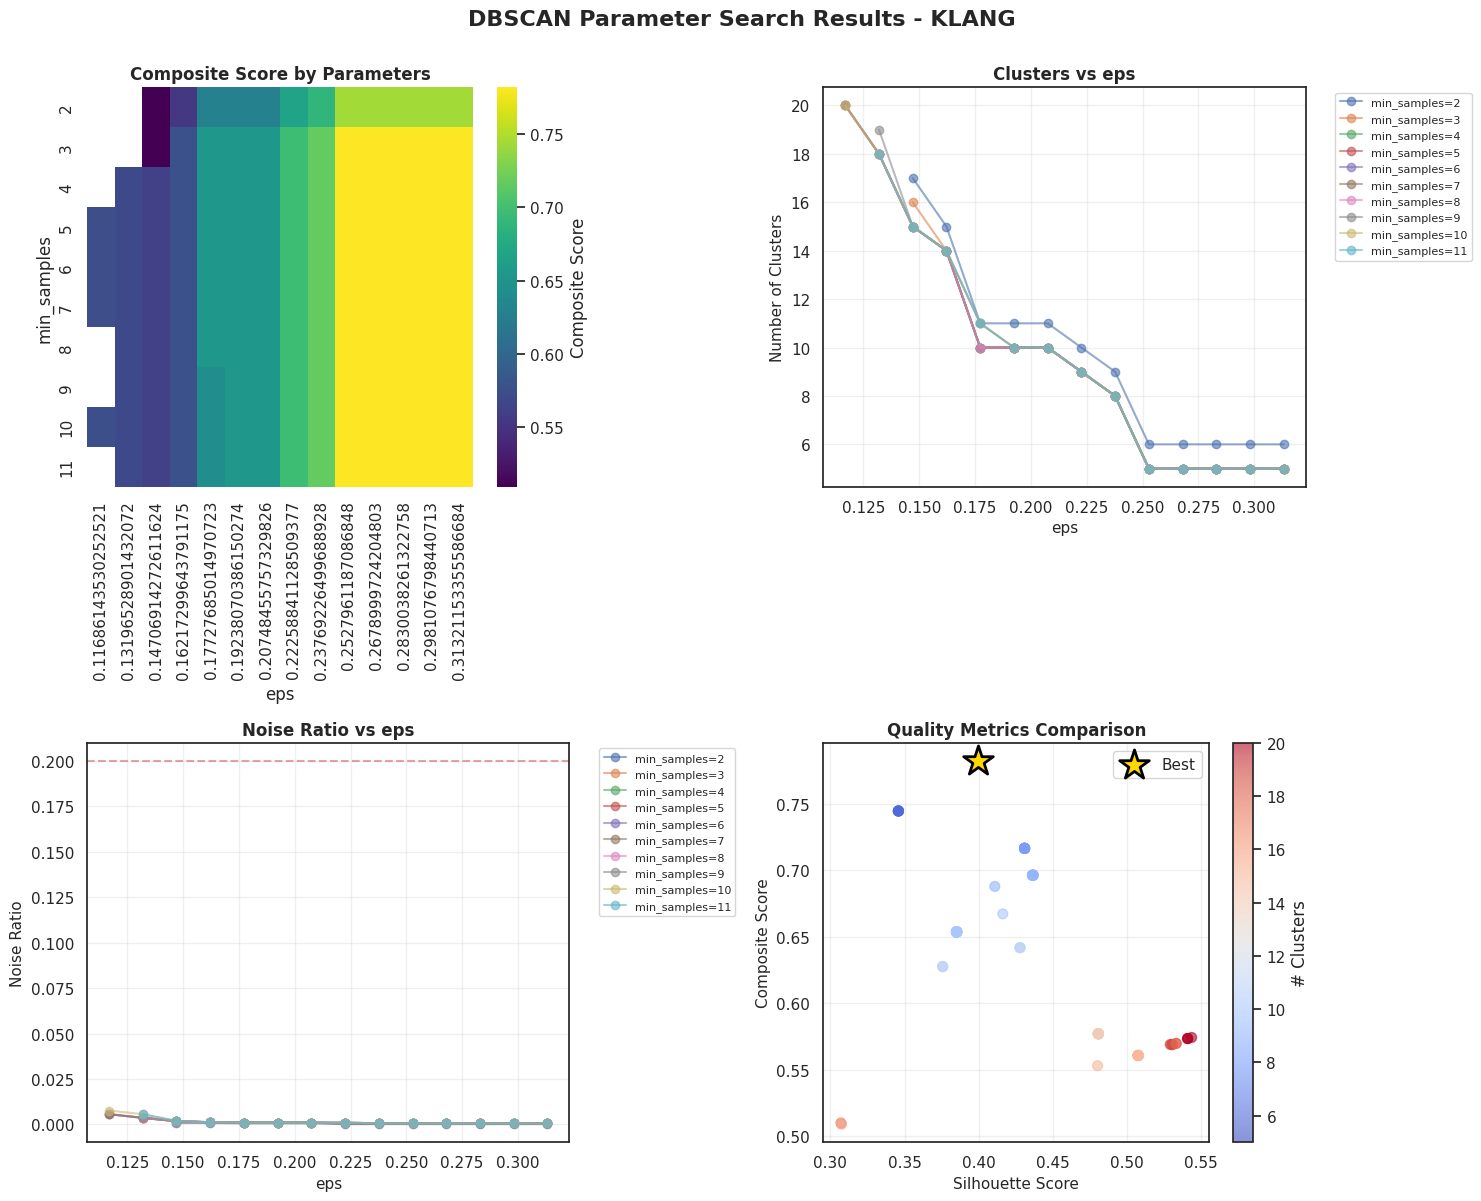

⚠️  klang: Too few clusters (5 < 6)

Processing: kuala langat
Sample size: 3,108

Optimizing DBSCAN for KUALA LANGAT
Sample size: 3,108
Features: ['x_coord', 'y_coord']


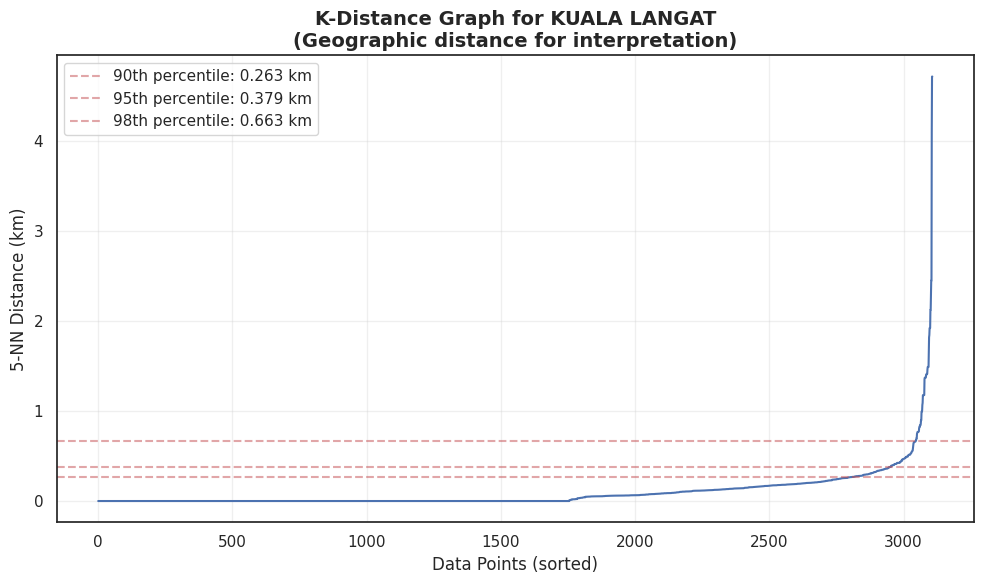


Geographic interpretation (approximate):
  Conservative: 0.0385 (std units) ≈ 0.263 km
  Balanced: 0.0555 (std units) ≈ 0.379 km
  Aggressive: 0.0973 (std units) ≈ 0.664 km

Suggested eps values based on k-distance:
  Conservative: 0.0385
  Balanced: 0.0555
  Aggressive: 0.0973

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1386 to 0.4863 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.139, min_samples=2: clusters=33, noise=0.2%

  eps=0.163, min_samples=2: clusters=30, noise=0.2%

  eps=0.188, min_samples=2: clusters=28, noise=0.1%

  eps=0.213, min_samples=2: clusters=21, noise=0.1%

  eps=0.238, min_samples=2: clusters=18, noise=0.1%
     → Silhouette: 0.258, DB: 0.474, Cluster_score: 0.000, Composite: 0.500

  eps=0.263, min_samples=2: clusters=15, noise=0.1%
     → Silhouette: 0.129, DB: 0.530, Cluster_score: 0.000, Composite: 0.457

  eps=0.288, min_samples=2: clusters=12, noise=0.1%
     → Silhouette: 0.083, DB: 0.613, Cluster_score: 0.300, Compo

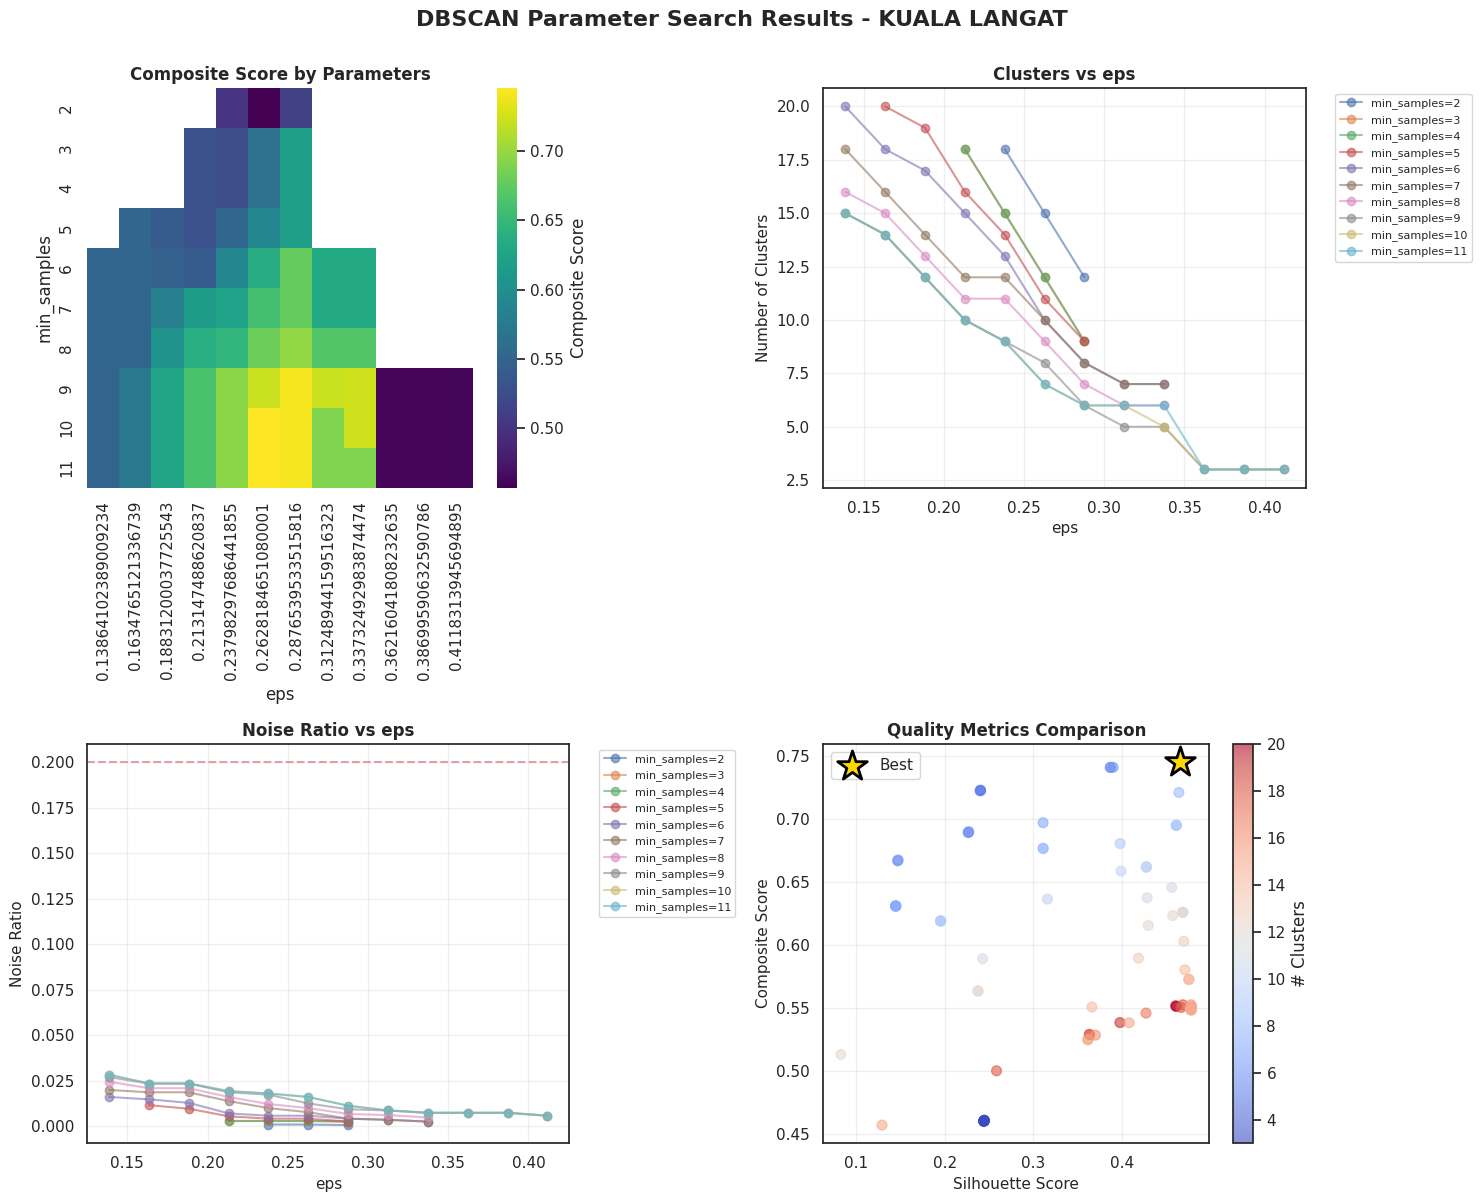

✅ kuala langat: DBSCAN successful
   Clusters: 7, Silhouette: 0.466

Processing: kuala selangor
Sample size: 2,507

Optimizing DBSCAN for KUALA SELANGOR
Sample size: 2,507
Features: ['x_coord', 'y_coord']


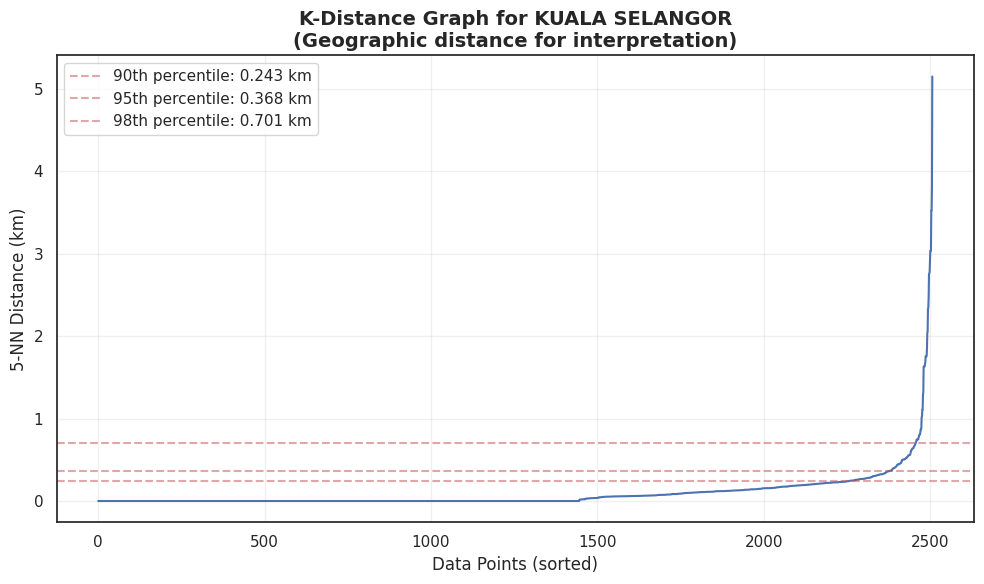


Geographic interpretation (approximate):
  Conservative: 0.0320 (std units) ≈ 0.244 km
  Balanced: 0.0509 (std units) ≈ 0.368 km
  Aggressive: 0.0880 (std units) ≈ 0.702 km

Suggested eps values based on k-distance:
  Conservative: 0.0320
  Balanced: 0.0509
  Aggressive: 0.0880

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1273 to 0.4398 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.127, min_samples=2: clusters=29, noise=0.3%

  eps=0.150, min_samples=2: clusters=27, noise=0.3%

  eps=0.172, min_samples=2: clusters=23, noise=0.3%

  eps=0.194, min_samples=2: clusters=20, noise=0.2%
     → Silhouette: 0.411, DB: 0.405, Cluster_score: 0.000, Composite: 0.545

  eps=0.217, min_samples=2: clusters=20, noise=0.2%
     → Silhouette: 0.411, DB: 0.406, Cluster_score: 0.000, Composite: 0.545

  eps=0.239, min_samples=2: clusters=17, noise=0.2%
     → Silhouette: 0.342, DB: 0.423, Cluster_score: 0.000, Composite: 0.526

  eps=0.261, min_samples=2: clusters=16,

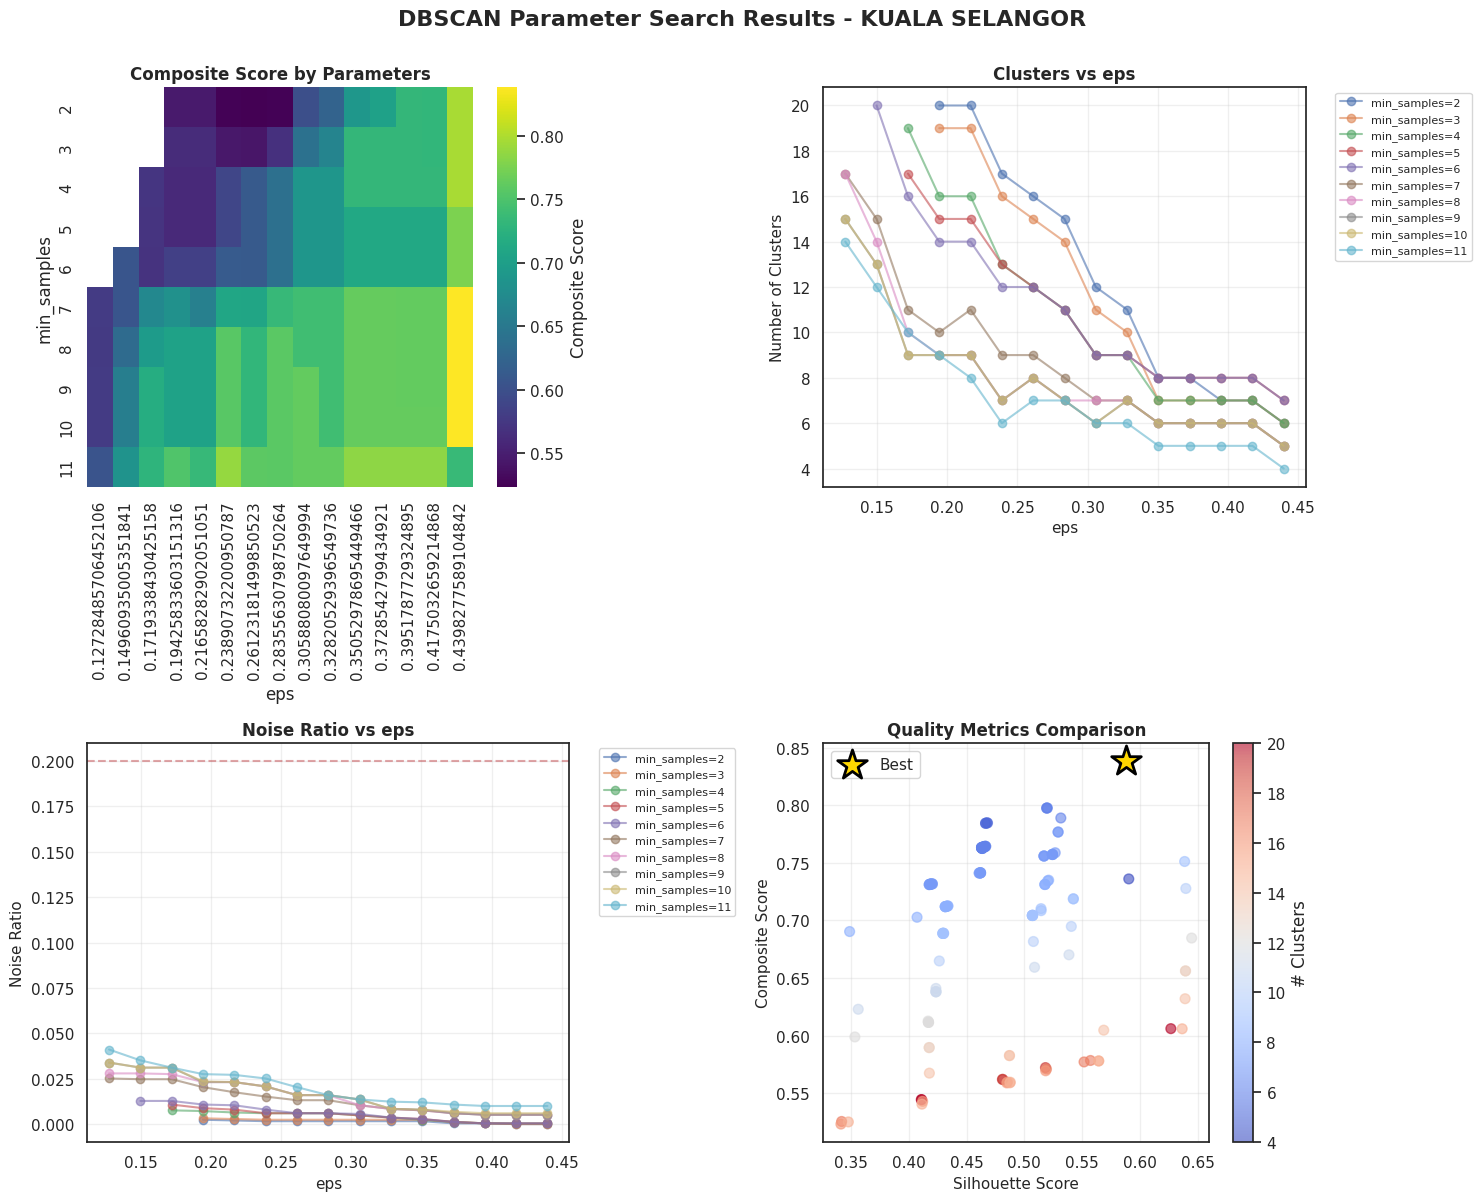

⚠️  kuala selangor: Too few clusters (5 < 6)

Processing: sabak bernam
Sample size: 470

Optimizing DBSCAN for SABAK BERNAM
Sample size: 470
Features: ['x_coord', 'y_coord']


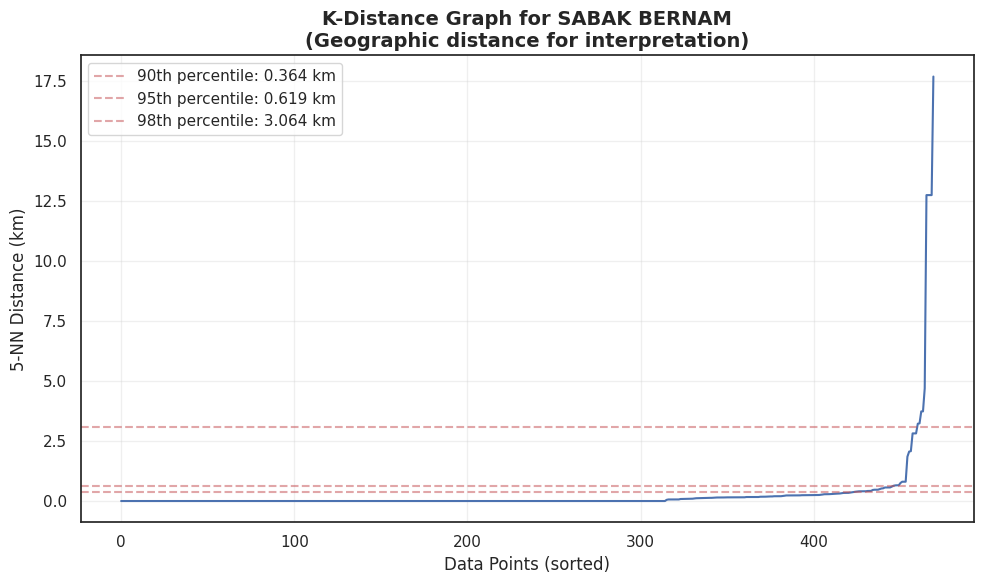


Geographic interpretation (approximate):
  Conservative: 0.0457 (std units) ≈ 0.381 km
  Balanced: 0.0762 (std units) ≈ 0.635 km
  Aggressive: 0.4118 (std units) ≈ 3.218 km

Suggested eps values based on k-distance:
  Conservative: 0.0457
  Balanced: 0.0762
  Aggressive: 0.4118

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 0.1906 to 2.0592 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.191, min_samples=2: clusters=11, noise=0.9%
     → Silhouette: 0.711, DB: 0.213, Cluster_score: 0.000, Composite: 0.641

  eps=0.324, min_samples=2: clusters=9, noise=0.6%
     → Silhouette: 0.605, DB: 0.317, Cluster_score: 0.000, Composite: 0.602

  eps=0.458, min_samples=2: clusters=4, noise=0.6%
     → Silhouette: 0.582, DB: 0.285, Cluster_score: 0.833, Composite: 0.808

  eps=0.591, min_samples=2: clusters=3, noise=0.4%
     → Silhouette: 0.796, DB: 0.205, Cluster_score: 1.000, Composite: 0.914

  eps=0.725, min_samples=2: clusters=3, noise=0.2%
     → Silhouette: 0.7

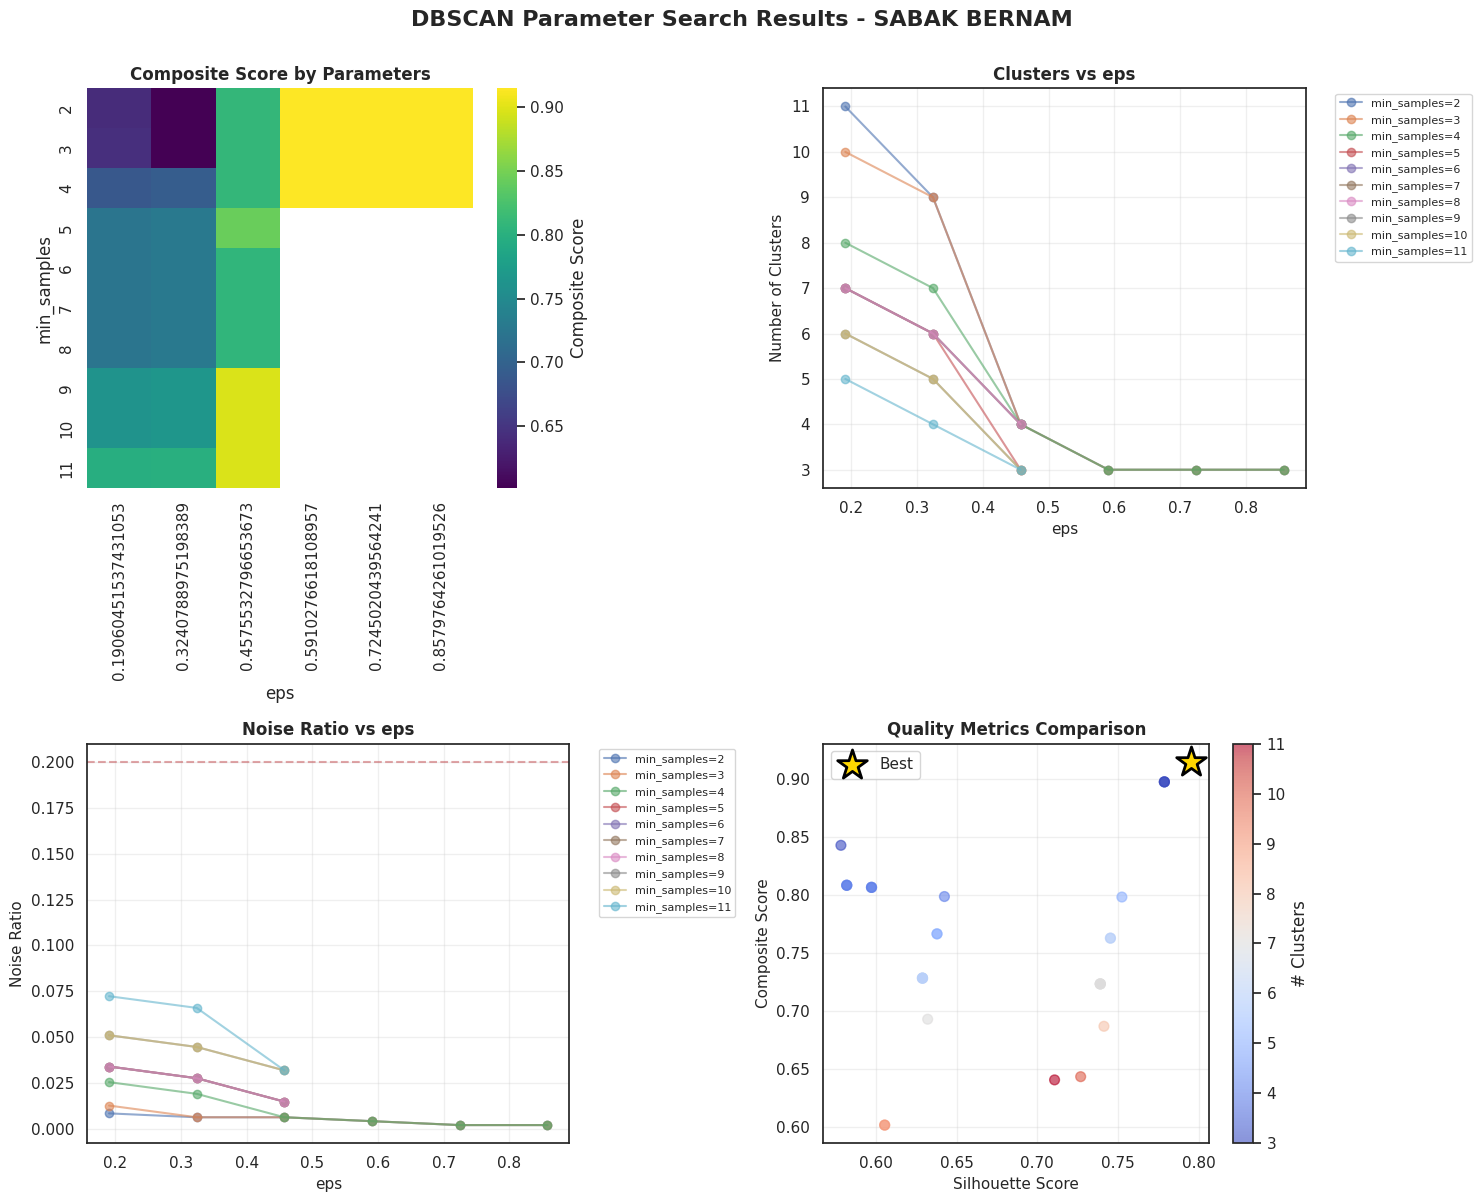

⚠️  sabak bernam: Too few clusters (3 < 6)

Processing: sepang
Sample size: 3,018

Optimizing DBSCAN for SEPANG
Sample size: 3,018
Features: ['x_coord', 'y_coord']


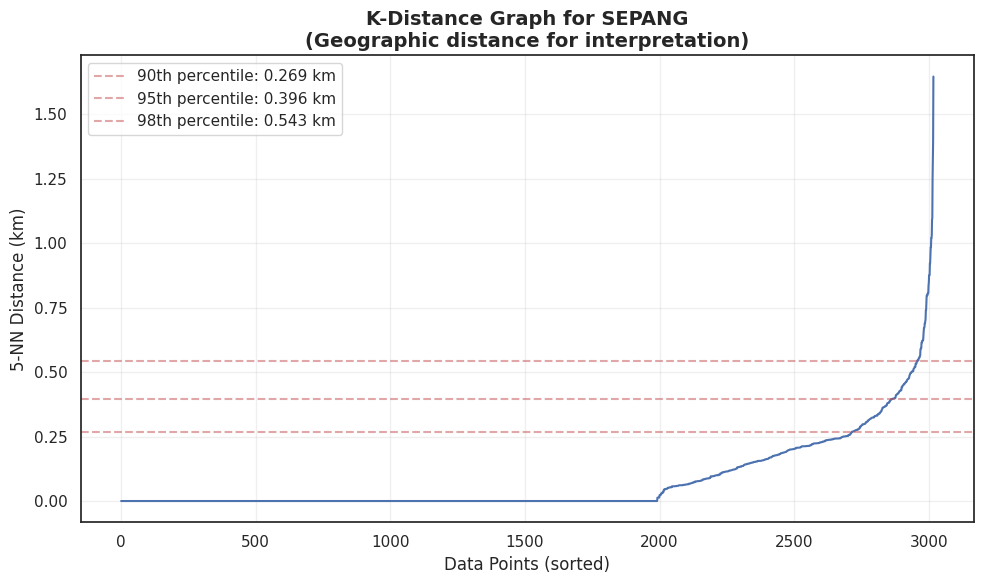


Geographic interpretation (approximate):
  Conservative: 0.0395 (std units) ≈ 0.269 km
  Balanced: 0.0557 (std units) ≈ 0.397 km
  Aggressive: 0.0777 (std units) ≈ 0.545 km

Suggested eps values based on k-distance:
  Conservative: 0.0395
  Balanced: 0.0557
  Aggressive: 0.0777

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1392 to 0.3883 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.139, min_samples=2: clusters=24, noise=0.1%

  eps=0.157, min_samples=2: clusters=17, noise=0.1%
     → Silhouette: 0.395, DB: 0.575, Cluster_score: 0.000, Composite: 0.526

  eps=0.175, min_samples=2: clusters=14, noise=0.0%
     → Silhouette: 0.329, DB: 0.421, Cluster_score: 0.100, Composite: 0.548

  eps=0.193, min_samples=2: clusters=13, noise=0.0%
     → Silhouette: 0.341, DB: 0.396, Cluster_score: 0.200, Composite: 0.578

  eps=0.210, min_samples=2: clusters=8, noise=0.0%
     → Silhouette: 0.375, DB: 0.387, Cluster_score: 0.700, Composite: 0.713

  eps=0.228, min_s

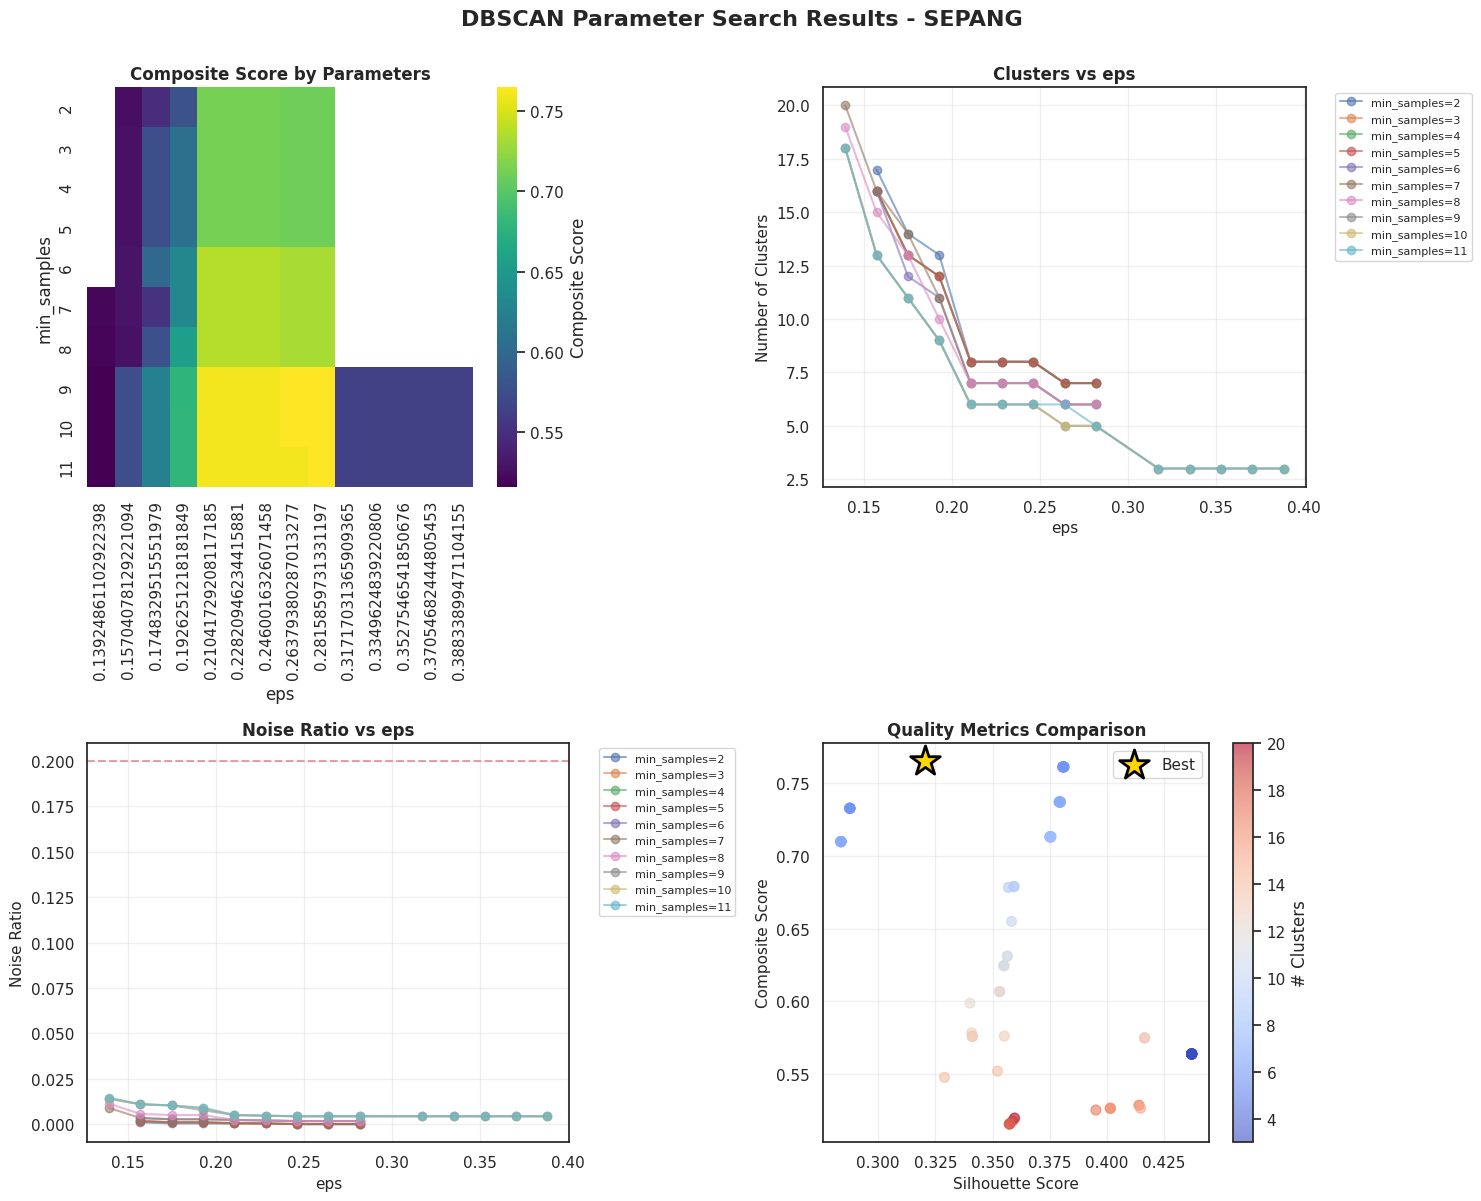

⚠️  sepang: Too few clusters (5 < 6)

Processing: petaling
Sample size: 3,562

Optimizing DBSCAN for PETALING
Sample size: 3,562
Features: ['x_coord', 'y_coord']


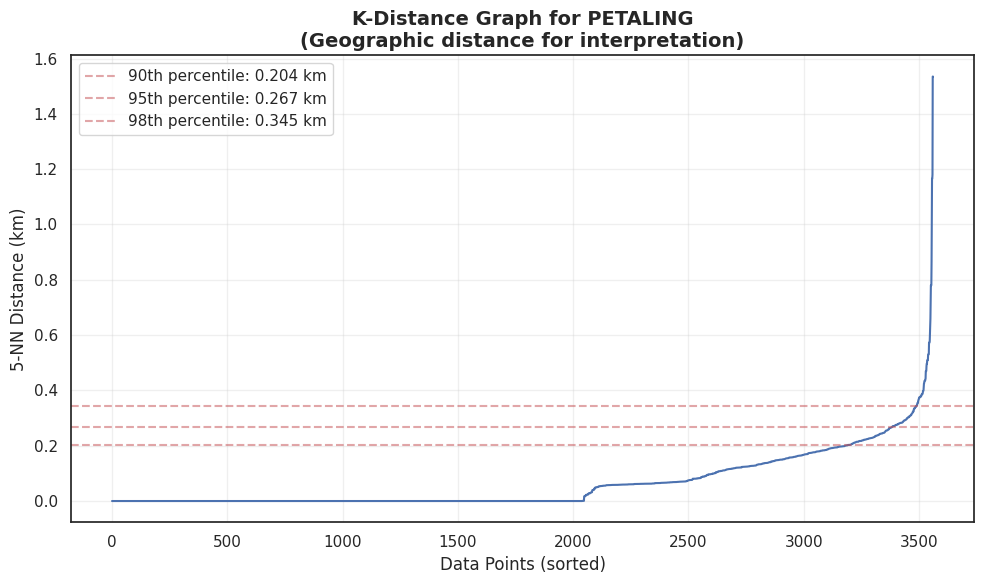


Geographic interpretation (approximate):
  Conservative: 0.0319 (std units) ≈ 0.204 km
  Balanced: 0.0409 (std units) ≈ 0.267 km
  Aggressive: 0.0532 (std units) ≈ 0.345 km

Suggested eps values based on k-distance:
  Conservative: 0.0319
  Balanced: 0.0409
  Aggressive: 0.0532

Target clusters: 5 (range: 3-20)
Searching parameter space:
  eps: 0.1024 to 0.2662 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.102, min_samples=2: clusters=24, noise=0.1%

  eps=0.114, min_samples=2: clusters=21, noise=0.1%

  eps=0.126, min_samples=2: clusters=17, noise=0.0%
     → Silhouette: 0.502, DB: 0.516, Cluster_score: 0.000, Composite: 0.557

  eps=0.137, min_samples=2: clusters=17, noise=0.0%
     → Silhouette: 0.502, DB: 0.516, Cluster_score: 0.000, Composite: 0.557

  eps=0.149, min_samples=2: clusters=14, noise=0.0%
     → Silhouette: 0.461, DB: 0.479, Cluster_score: 0.100, Composite: 0.575

  eps=0.161, min_samples=2: clusters=13, noise=0.0%
     → Silhouette: 0.292, DB: 0.433, Clus

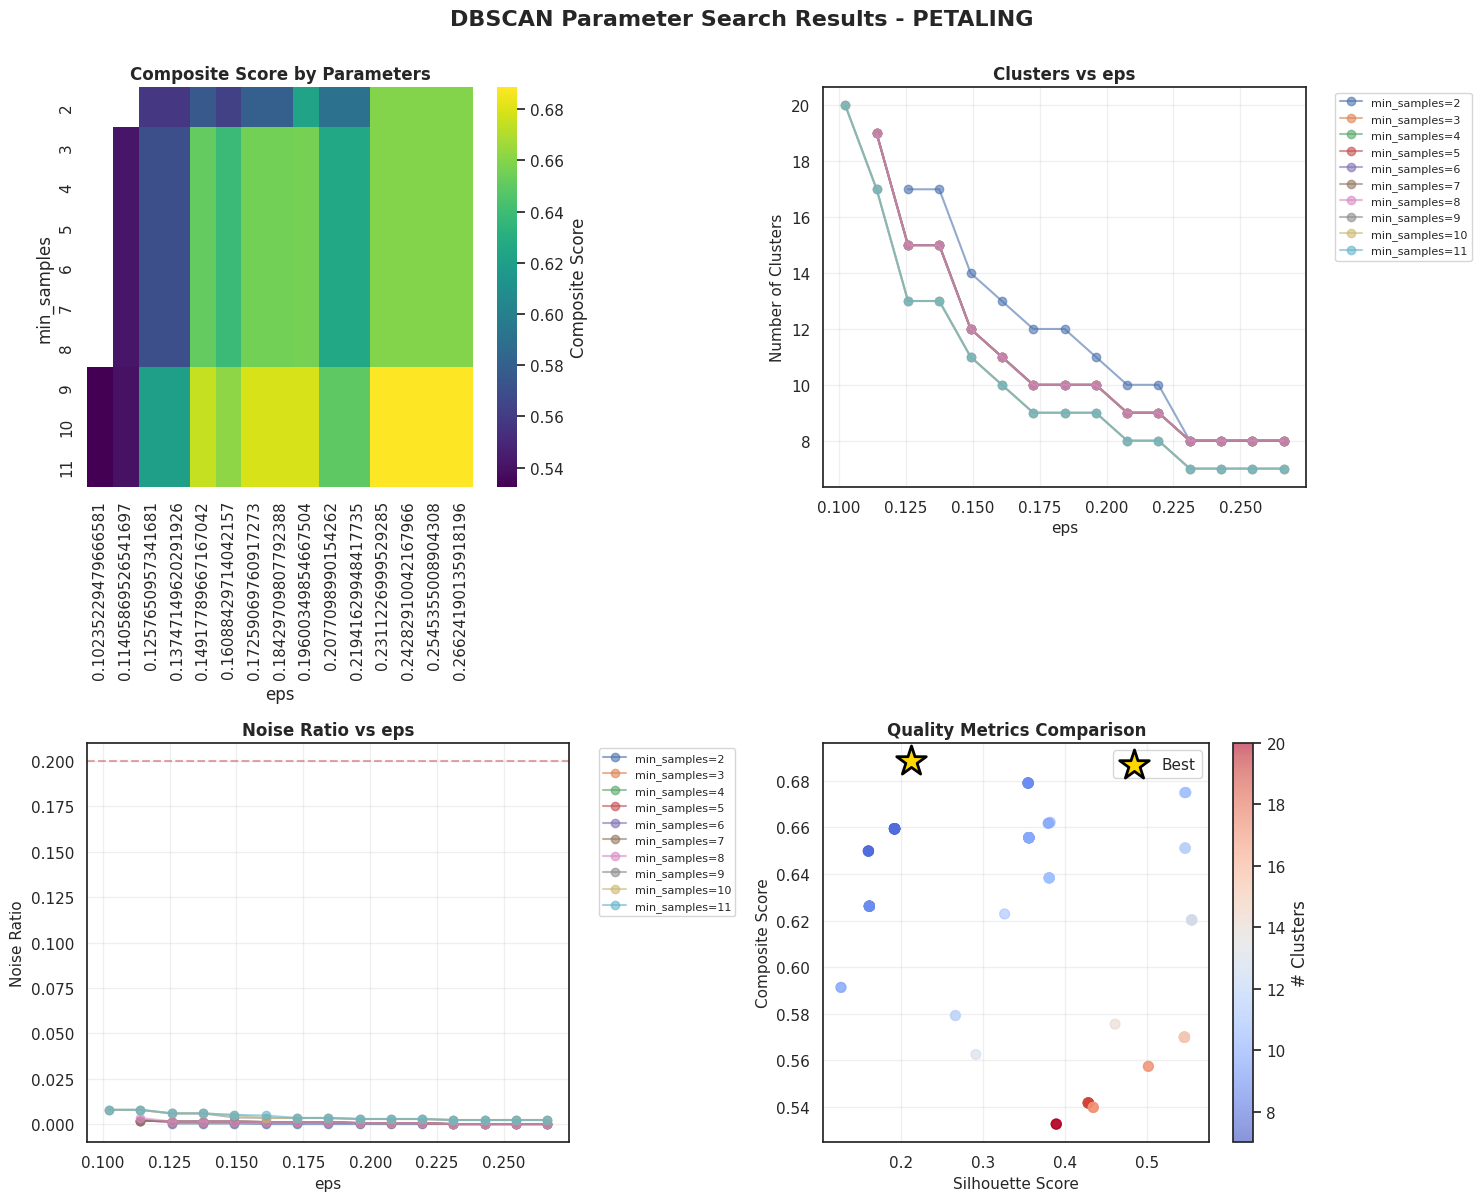

✅ petaling: DBSCAN successful
   Clusters: 7, Silhouette: 0.213

Processing: kuala lumpur
Sample size: 489

Optimizing DBSCAN for KUALA LUMPUR
Sample size: 489
Features: ['x_coord', 'y_coord']


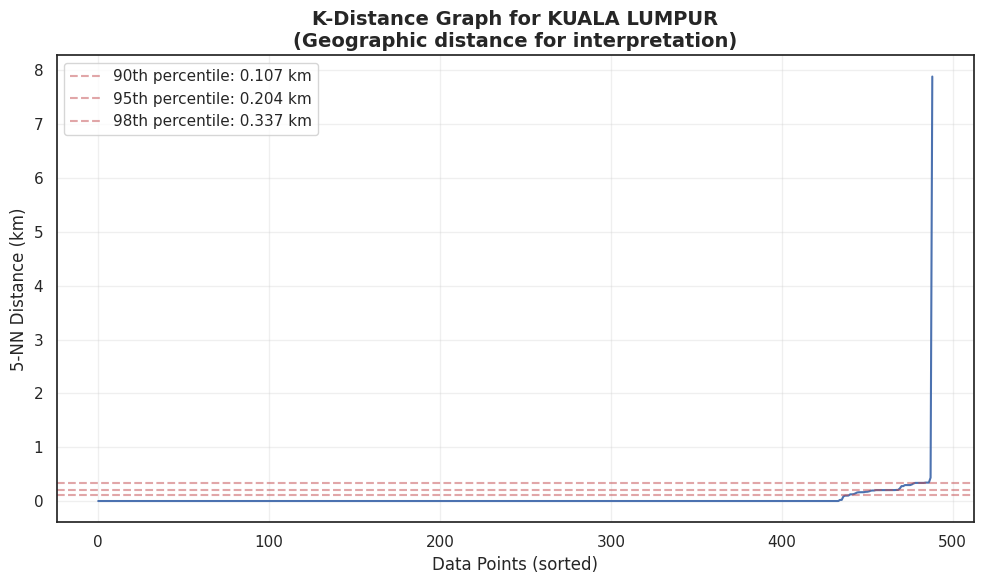


Geographic interpretation (approximate):
  Conservative: 0.0457 (std units) ≈ 0.124 km
  Balanced: 0.0734 (std units) ≈ 0.204 km
  Aggressive: 0.1873 (std units) ≈ 0.337 km

Suggested eps values based on k-distance:
  Conservative: 0.0457
  Balanced: 0.0734
  Aggressive: 0.1873

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 0.1836 to 0.9365 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.184, min_samples=2: clusters=11, noise=0.2%
     → Silhouette: 0.722, DB: 0.215, Cluster_score: 0.000, Composite: 0.645

  eps=0.237, min_samples=2: clusters=8, noise=0.2%
     → Silhouette: 0.697, DB: 0.223, Cluster_score: 0.167, Composite: 0.679

  eps=0.291, min_samples=2: clusters=6, noise=0.2%
     → Silhouette: 0.818, DB: 0.121, Cluster_score: 0.500, Composite: 0.808

  eps=0.345, min_samples=2: clusters=6, noise=0.2%
     → Silhouette: 0.818, DB: 0.121, Cluster_score: 0.500, Composite: 0.808

  eps=0.399, min_samples=2: clusters=6, noise=0.2%
     → Silhouette: 0.8

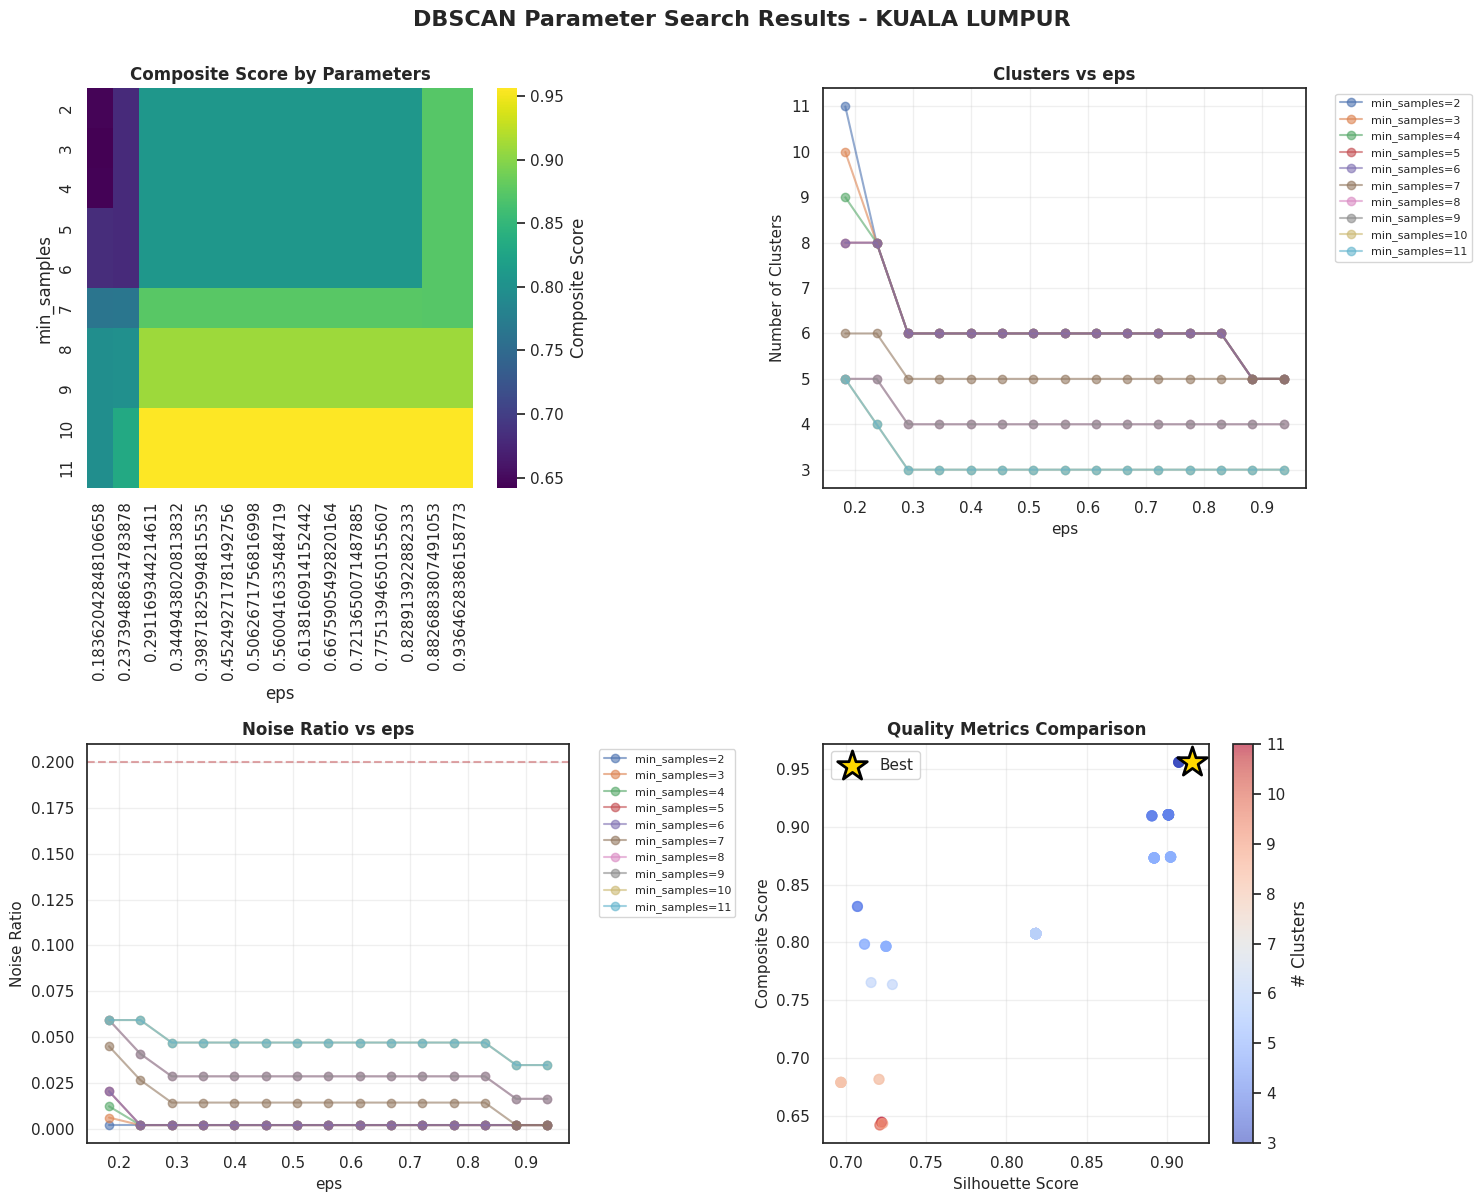

⚠️  kuala lumpur: Too few clusters (3 < 6)

Processing: putrajaya
Sample size: 275

Optimizing DBSCAN for PUTRAJAYA
Sample size: 275
Features: ['x_coord', 'y_coord']


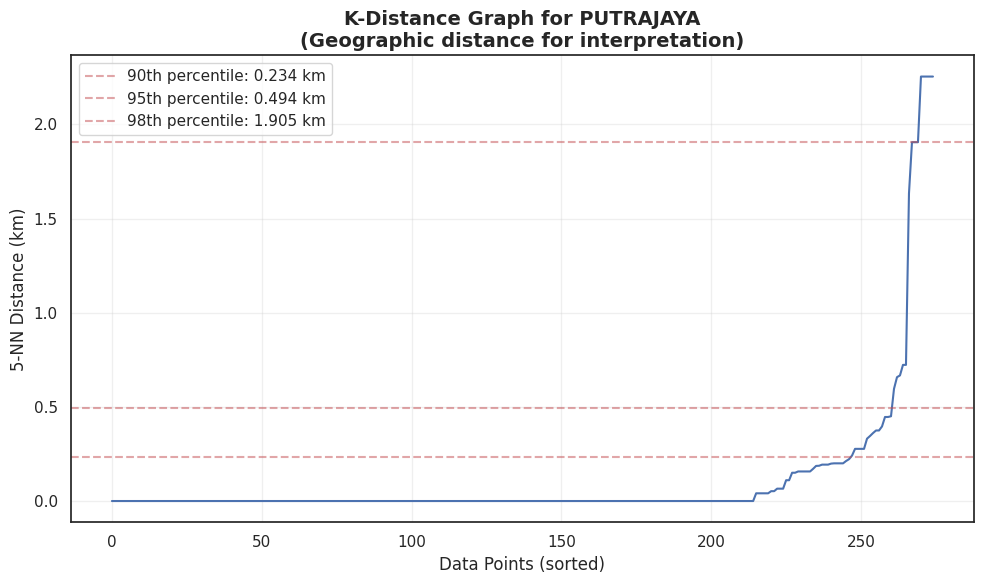


Geographic interpretation (approximate):
  Conservative: 0.1275 (std units) ≈ 0.242 km
  Balanced: 0.2768 (std units) ≈ 0.596 km
  Aggressive: 1.0327 (std units) ≈ 1.905 km

Suggested eps values based on k-distance:
  Conservative: 0.1275
  Balanced: 0.2768
  Aggressive: 1.0327

Target clusters: 3 (range: 3-12)
Searching parameter space:
  eps: 0.6920 to 5.1634 (15 values)
  min_samples: 2 to 11

Searching...
  eps=0.692, min_samples=2: clusters=7, noise=0.0%
     → Silhouette: 0.789, DB: 0.291, Cluster_score: 0.333, Composite: 0.735

  eps=1.011, min_samples=2: clusters=4, noise=0.0%
     → Silhouette: 0.670, DB: 0.319, Cluster_score: 0.833, Composite: 0.762

  eps=1.331, min_samples=2: clusters=2, noise=0.0%

  eps=1.650, min_samples=2: clusters=2, noise=0.0%

  eps=1.970, min_samples=2: clusters=1, noise=0.0%

  eps=2.289, min_samples=2: clusters=1, noise=0.0%

  eps=2.608, min_samples=2: clusters=1, noise=0.0%

  eps=2.928, min_samples=2: clusters=1, noise=0.0%

  eps=3.247, min_s

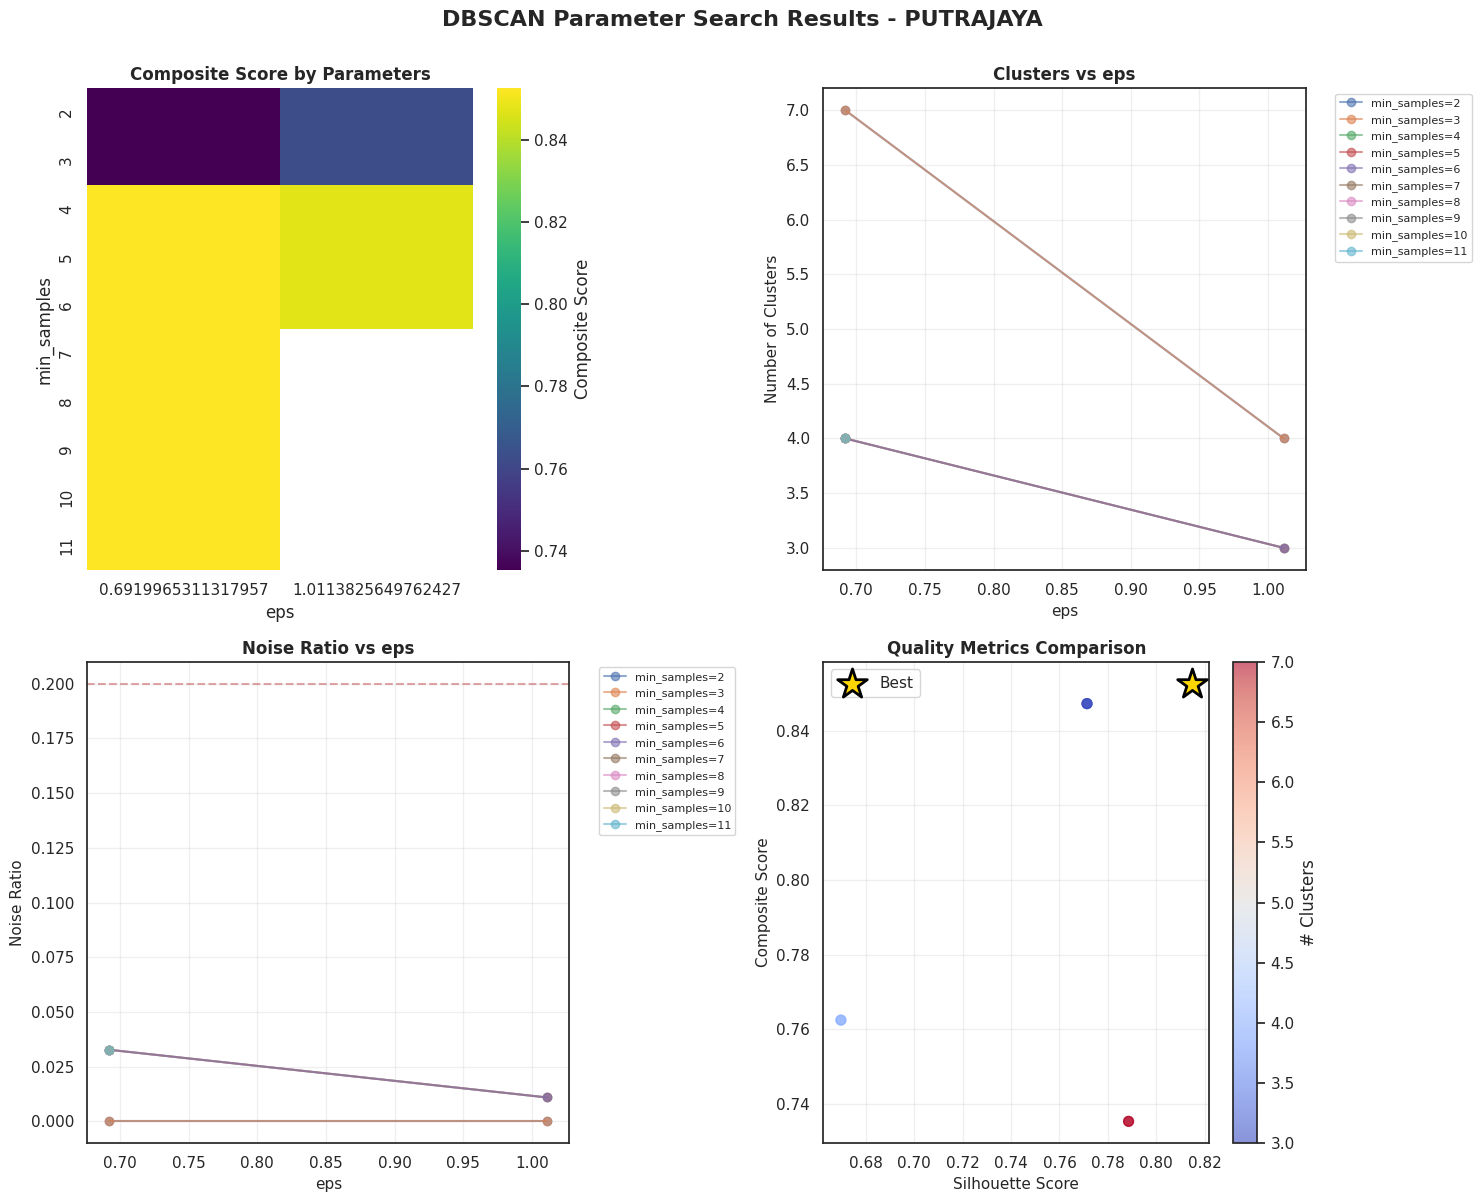

⚠️  putrajaya: Too few clusters (4 < 6)

PHASE 2: K-MEANS FALLBACK FOR FAILED DISTRICTS
Districts needing K-Means: 8
  - hulu langat: 4,251 properties
  - hulu selangor: 2,852 properties
  - klang: 4,951 properties
  - kuala selangor: 2,507 properties
  - sabak bernam: 470 properties
  - sepang: 3,018 properties
  - kuala lumpur: 489 properties
  - putrajaya: 275 properties

K-Means for hulu langat
Sample size: 4,251
Target clusters: 12

Using K-Means for hulu langat (dense urban area)
Sample size: 4,251

Testing K values from 7 to 20...
  K=7: Silhouette=0.492
  K=8: Silhouette=0.499
  K=9: Silhouette=0.514
  K=10: Silhouette=0.526
  K=11: Silhouette=0.534
  K=12: Silhouette=0.532
  K=13: Silhouette=0.519
  K=14: Silhouette=0.528
  K=15: Silhouette=0.518

✓ Best K-Means result:
  Number of clusters: 19
  Silhouette score: 0.551
  Noise points: 0 (K-Means assigns all points)
✅ hulu langat: K-Means successful
   Clusters: 19, Silhouette: 0.551

K-Means for hulu selangor
Sample size: 2,8

In [ ]:
# Set clustering features
clustering_features = ['x_coord', 'y_coord']

# Transit segment
transit_clustered, transit_config, transit_validation = run_full_clustering_pipeline(
    df_segment=transit_seg,
    clustering_features=clustering_features,
    verbose=True
)

# Non-transit segment
non_transit_clustered, non_transit_config, non_transit_validation = run_full_clustering_pipeline(
    df_segment=non_transit_seg,
    clustering_features=clustering_features,
    verbose=True
)
# Combine results
df_full_clustered = pd.concat([transit_clustered, non_transit_clustered], ignore_index=True)

print(f"\n✓ Full dataset clustered: {len(df_full_clustered):,} properties")
print(f"   Transit: {len(transit_clustered):,} ({len(transit_clustered)/len(df_full_clustered):.1%})")
print(f"   Non-transit: {len(non_transit_clustered):,} ({len(non_transit_clustered)/len(df_full_clustered):.1%})")

In [ ]:
print(transit_clustered.shape)
print(non_transit_clustered.shape)

print(transit_clustered['price_m2'].describe())
print(non_transit_clustered['price_m2'].describe())

(38260, 45)
(30417, 45)
count    38,260.00
mean     17,386.60
std      26,478.57
min         297.50
25%       4,087.25
50%       5,903.81
75%      13,937.67
max     424,318.18
Name: price_m2, dtype: float64
count    30,417.00
mean      6,580.44
std      12,216.71
min         313.14
25%       3,375.00
50%       4,388.89
75%       5,621.10
max     246,666.67
Name: price_m2, dtype: float64


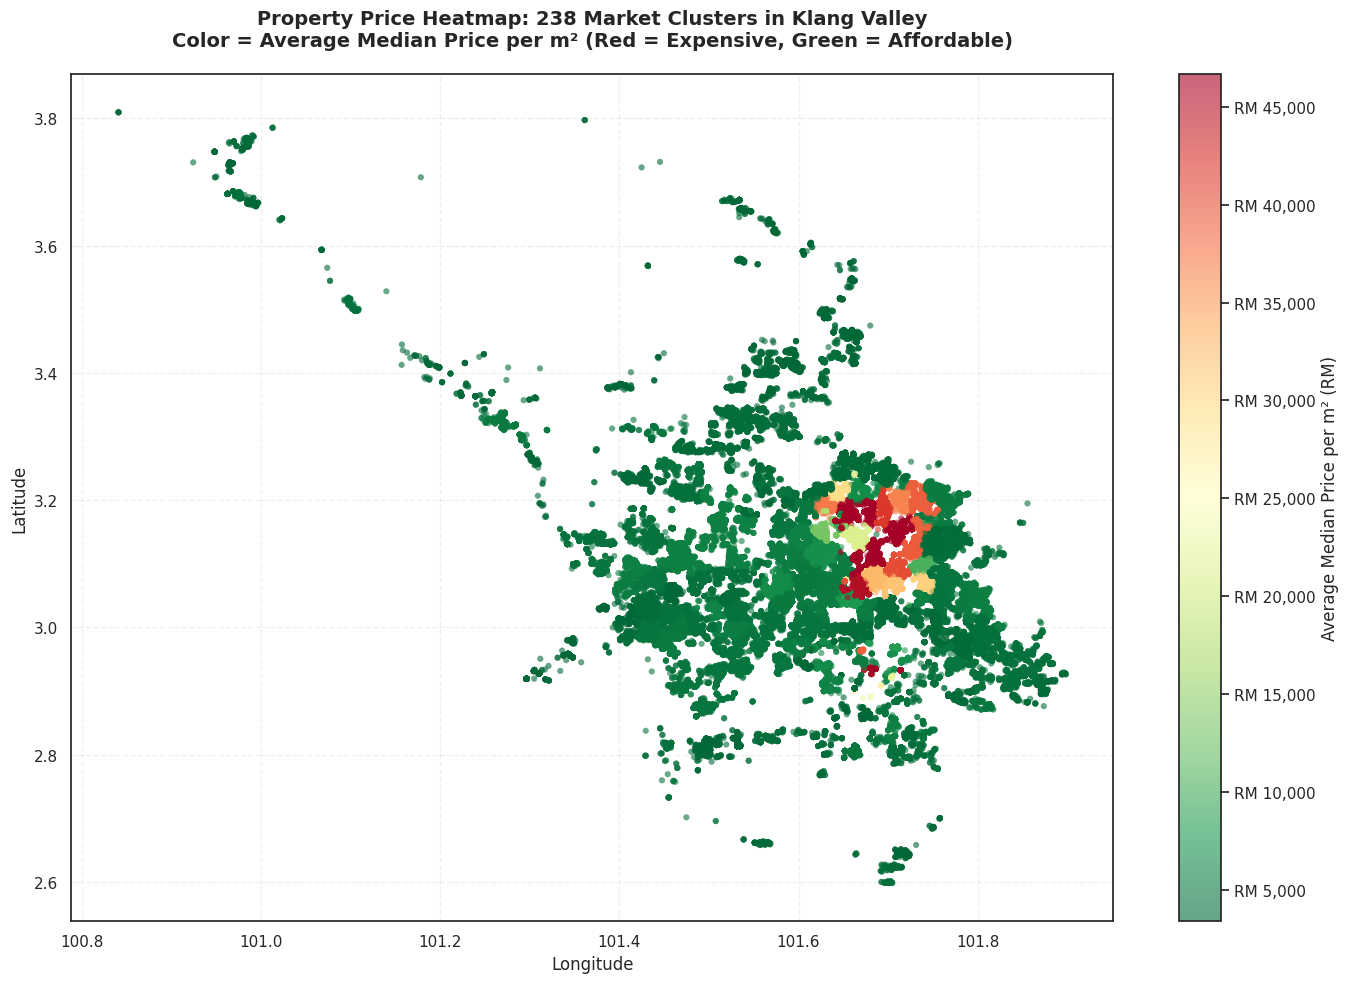

In [ ]:
# Calculate average price per m² for each cluster
cluster_avg_price = df_full_clustered.groupby('market_cluster_id')['price_m2'].median()

# Map average prices back to each property
df_full_clustered['cluster_avg_price'] = df_full_clustered['market_cluster_id'].map(cluster_avg_price)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot - color by average cluster price
scatter = ax.scatter(
    df_full_clustered['x_coord'],
    df_full_clustered['y_coord'],
    c=df_full_clustered['cluster_avg_price'],  # Color by price
    cmap='RdYlGn_r',  # Red (expensive) → Yellow → Green (cheap)
    alpha=0.6,
    s=20,
    edgecolors='none',
    vmin=df_full_clustered['cluster_avg_price'].quantile(0.05),  # Clip extreme outliers
    vmax=df_full_clustered['cluster_avg_price'].quantile(0.95)
)

# Add labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Property Price Heatmap: 238 Market Clusters in Klang Valley\nColor = Average Median Price per m² (Red = Expensive, Green = Affordable)',
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar with RM formatting
cbar = plt.colorbar(scatter, ax=ax, label='Average Median Price per m² (RM)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'RM {x:,.0f}'))

# Add grid for readability
ax.grid(True, alpha=0.3, linestyle='--')

# Make it look professional
plt.tight_layout()

# Save the figure
#plt.savefig('/content/cluster_map_by_price.png', dpi=300, bbox_inches='tight', facecolor='white')
#print("✅ Saved: cluster_map_by_price.png")
plt.show()

# Download the file
#from google.colab import files
#files.download('/content/cluster_map_by_price.png')

CREATING TRANSIT ACCESSIBILITY MAP
✅ Saved: transit_accessibility_map.png


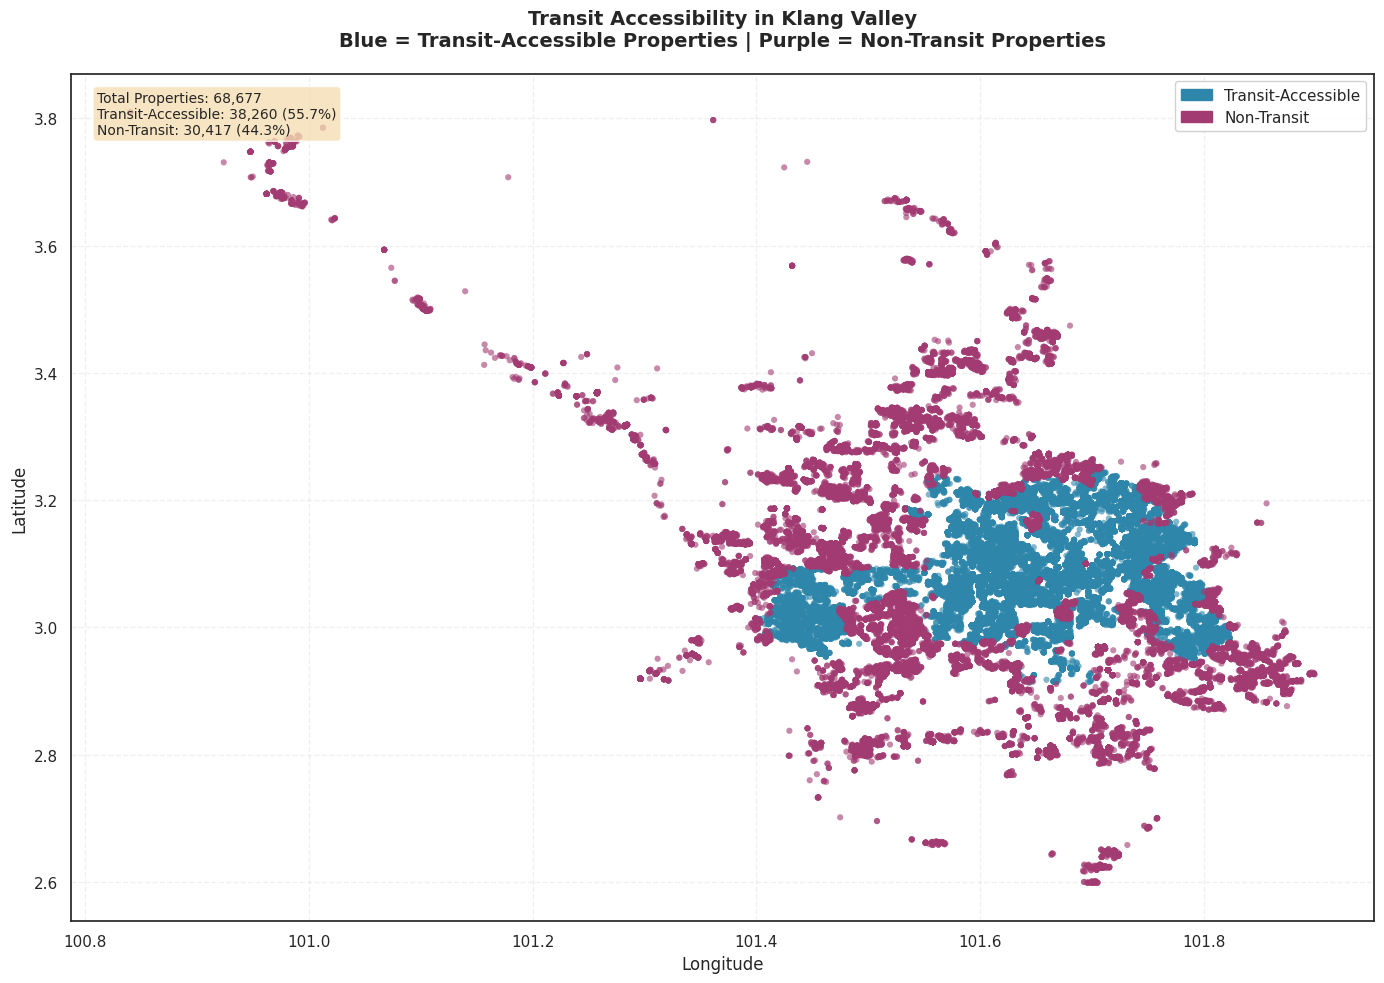


✅ Transit Accessibility Map Complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#CREATING TRANSIT ACCESSIBILITY MAP
# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for transit vs non-transit
# Assuming 'transit' column is binary (1 = has transit access, 0 = no transit)
transit_colors = {1: '#2E86AB', 0: '#A23B72'}  # Blue for transit, Purple for non-transit
colors = df_full_clustered['transit'].map(transit_colors)

# Create scatter plot
scatter = ax.scatter(
    df_full_clustered['x_coord'],
    df_full_clustered['y_coord'],
    c=colors,
    alpha=0.6,
    s=20,
    edgecolors='none'
)

# Add title and labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Transit Accessibility in Klang Valley\nBlue = Transit-Accessible Properties | Grey = Non-Transit Properties',
             fontsize=14, fontweight='bold', pad=20)

# Create custom legend
transit_patch = mpatches.Patch(color=COLORS['blue'], label='Transit-Accessible')
non_transit_patch = mpatches.Patch(color=COLORS['grey'], label='Non-Transit')
ax.legend(handles=[transit_patch, non_transit_patch],
         loc='upper right', fontsize=11, framealpha=0.9)

# Add grid for readability
ax.grid(True, alpha=0.3, linestyle='--')

# Add statistics text box
transit_count = (df_full_clustered['transit'] == 1).sum()
non_transit_count = (df_full_clustered['transit'] == 0).sum()
total_count = len(df_full_clustered)
transit_pct = (transit_count / total_count) * 100

textstr = f'Total Properties: {total_count:,}\n'
textstr += f'Transit-Accessible: {transit_count:,} ({transit_pct:.1f}%)\n'
textstr += f'Non-Transit: {non_transit_count:,} ({100-transit_pct:.1f}%)'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Make it look professional
plt.tight_layout()

# Optional: Save the figure
#plt.savefig('transit_accessibility_map.png', dpi=300, bbox_inches='tight', facecolor='white')
#print("✅ Saved: transit_accessibility_map.png")

plt.show()

print("\n✅ Transit Accessibility Map Complete!")

# Download the file
#from google.colab import files
#files.download('/content/transit_accessibility_map.png')

In [ ]:
#df_full_clustered.to_excel('/content/drive/MyDrive/Colab/Capstone 1/clustered.xlsx')